## Obligatorio: Analisis Predictivo de Series Temporales

   ### Análisis de transacciones de TC (enero_2016 - mayo_2021)

##### Costa Liliana (134429)

##### Deleon Natalia (162328)

##### Possamay Antonella (253253)

In [1]:
library(astsa)
library(forecast)
library(ggplot2)
options(repr.plot.width=12, repr.plot.height=7) #ajusta tamaño de graficas

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff


Attaching package: ‘forecast’


The following object is masked from ‘package:astsa’:

    gas




### Introducción: Series utilizadas

##### En este obligatorio trabajamos con dos series con informacion real de transacciones de tarjetas de crédito. Una de las series tiene todas las transacciones y la otra tiene las transacciones de Mercado Pago. De esta última solo tenemos 60 muestras, por lo tanto para el análisis de correlación cruzada filtramos la serie completa para poder hacer un correcto análisis.


##### Las series tienen informacion mensual dividida cada 10 dìas, de esta forma contamos con las transacciones de los primeros dias, los 10 días del medio y los ultimos días del mes.

##### El período considerado para la serie general es desde enero de 2016 hasta mayo de 2021, mientras que para la de mercado pago el periodo es de octubre de 2019 a mayo de 2021.

In [2]:
datos = read.csv("datos_nuevos.csv", sep=",", header=TRUE)
datos_mp= read.csv("datos_MP.csv", sep=",", header=TRUE)

In [3]:
datos$Fecha = as.Date(datos$Fecha,format="%d/%m/%y")
str(datos)

'data.frame':	195 obs. of  2 variables:
 $ Fecha        : Date, format: "2020-01-01" "2020-01-10" ...
 $ Transacciones: int  275463 314152 369147 318266 315779 324747 347009 330038 265119 274217 ...


In [4]:
datos_mp$Fecha = as.Date(datos_mp$Fecha,format="%d/%m/%y")
str(datos_mp)

'data.frame':	60 obs. of  2 variables:
 $ Fecha        : Date, format: "2020-10-01" "2020-10-10" ...
 $ Transacciones: int  679 528 735 2062 763 740 881 1033 694 657 ...


In [5]:
datos_st=(ts(datos$Transacciones,frequency=36))
str(datos_st)

 Time-Series [1:195] from 1 to 6.39: 275463 314152 369147 318266 315779 324747 347009 330038 265119 274217 ...


In [6]:
datosmp_st=(ts(datos_mp$Transacciones,frequency=36))
str(datosmp_st)

 Time-Series [1:60] from 1 to 2.64: 679 528 735 2062 763 740 881 1033 694 657 ...


Análisis exploratorio de series temporales:

Cuando se estudia una serie temporal, lo primero que se tiene que hacer es graficar 
y considerar las medidas descriptivas básicas. Así, se tiene que considerar:

a) Si los datos presentan forma creciente (tendencia).

b) Si existe influencia de ciertos periodos de cualquier unidad de tiempo (estacionalidad).

c) Si aparecen outliers (observaciones extrañas o discordantes):Ruido.

Serie temporal = Tendencia + Estacionalidad + Ruido

Como a y b son deterministicas es necesario aislar de alguna manera la componente aleatoria y estudiar qué modelo
probabilístico es el más adecuado.

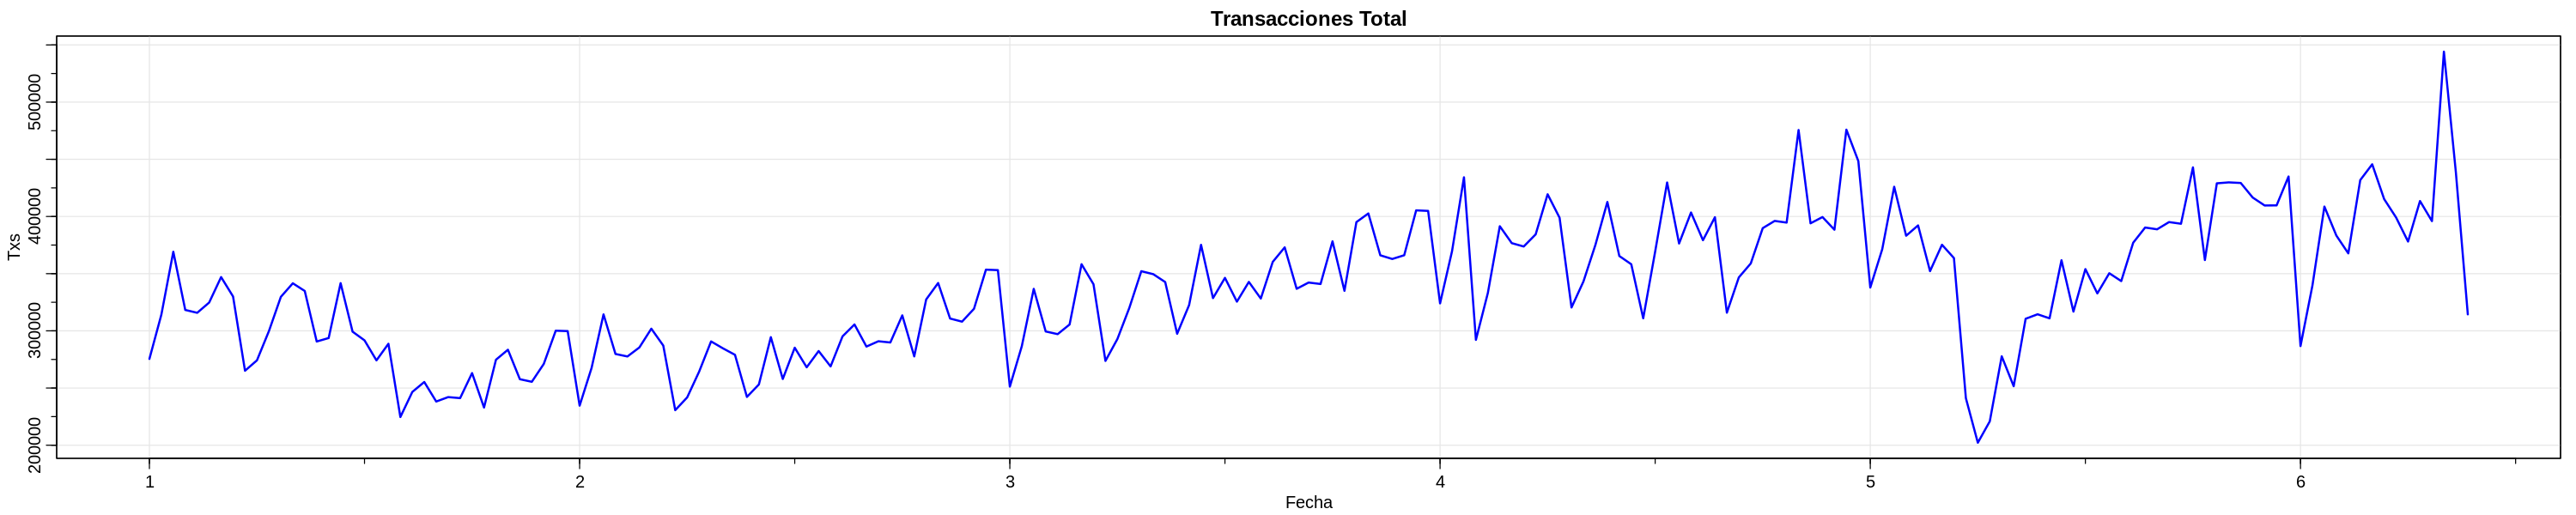

In [7]:
#1- Graficas
options(repr.plot.width=25, repr.plot.height=5) 
tsplot(datos_st,main="Transacciones Total",  ylab="Txs", xlab="Fecha", lwd=2, col=4)



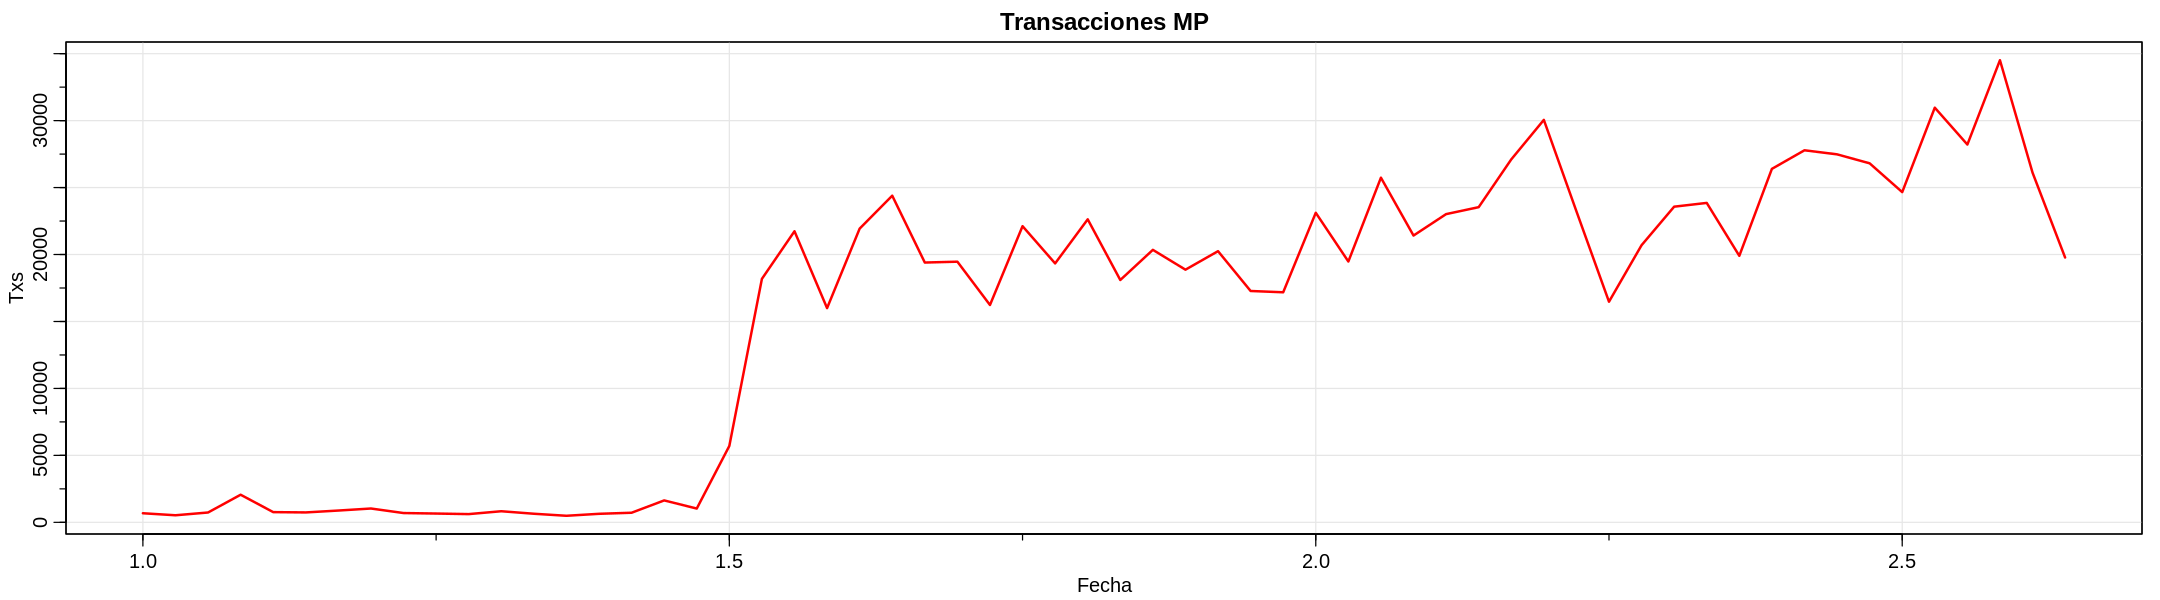

In [8]:
options(repr.plot.width=18, repr.plot.height=5) 
tsplot(datosmp_st,main="Transacciones MP",  ylab="Txs", xlab="Fecha", lwd=2, col=2)

##### Observaciones (graficas):

Se ve una tendencia creciente de Transacciones MP.

Se ve una tendencia creciente en la serie general marcada claramente por el efecto covid (marzo2020 (muestras 150-160)). Luego del efecto covid, continùa la tendencia creciente.



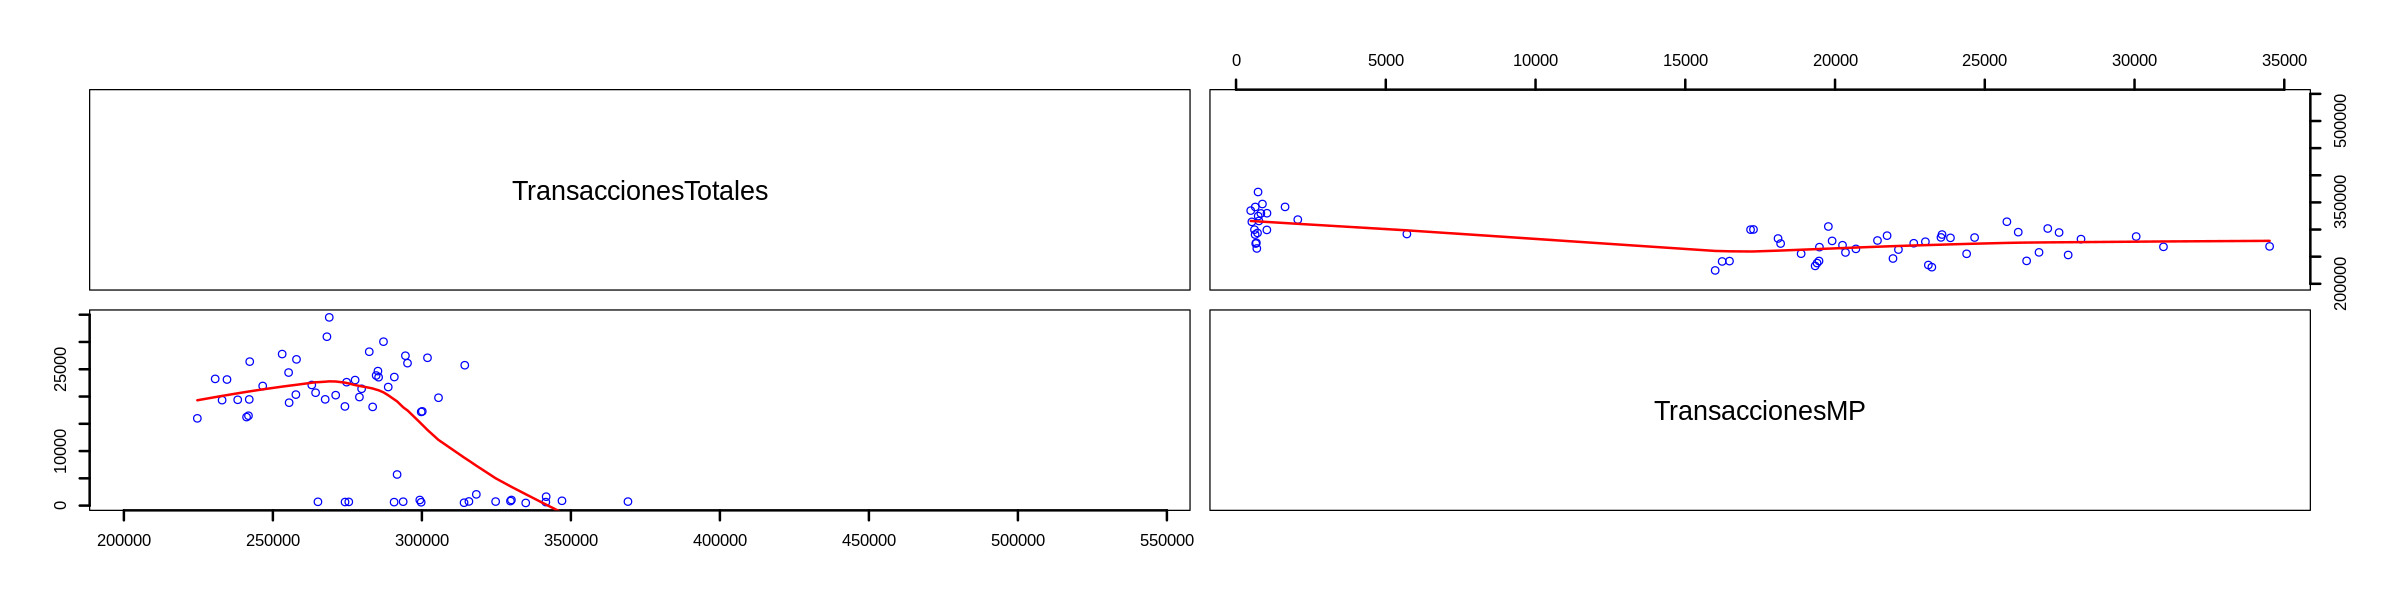

In [9]:
options(repr.plot.width=20, repr.plot.height=5) #ajusta tamaño de graficas
pairs(cbind(TransaccionesTotales=datos_st, TransaccionesMP=datosmp_st), col=4, panel=panel.smooth, lwd=2)

In [10]:
#Tomamos los ultimos 40 datos de cada serie para poder hacer correlaciòn cruzada. 
#Tomamos los ultimos 40 ya que en Mercado Pago las primeras 20 muestran distorcionan el anàlisis

datos_st_40 = ts(tail(datos$Transacciones,40),frequency=36)
datosmp_st_40 = ts(tail(datos_mp$Transacciones,40),frequency=36)


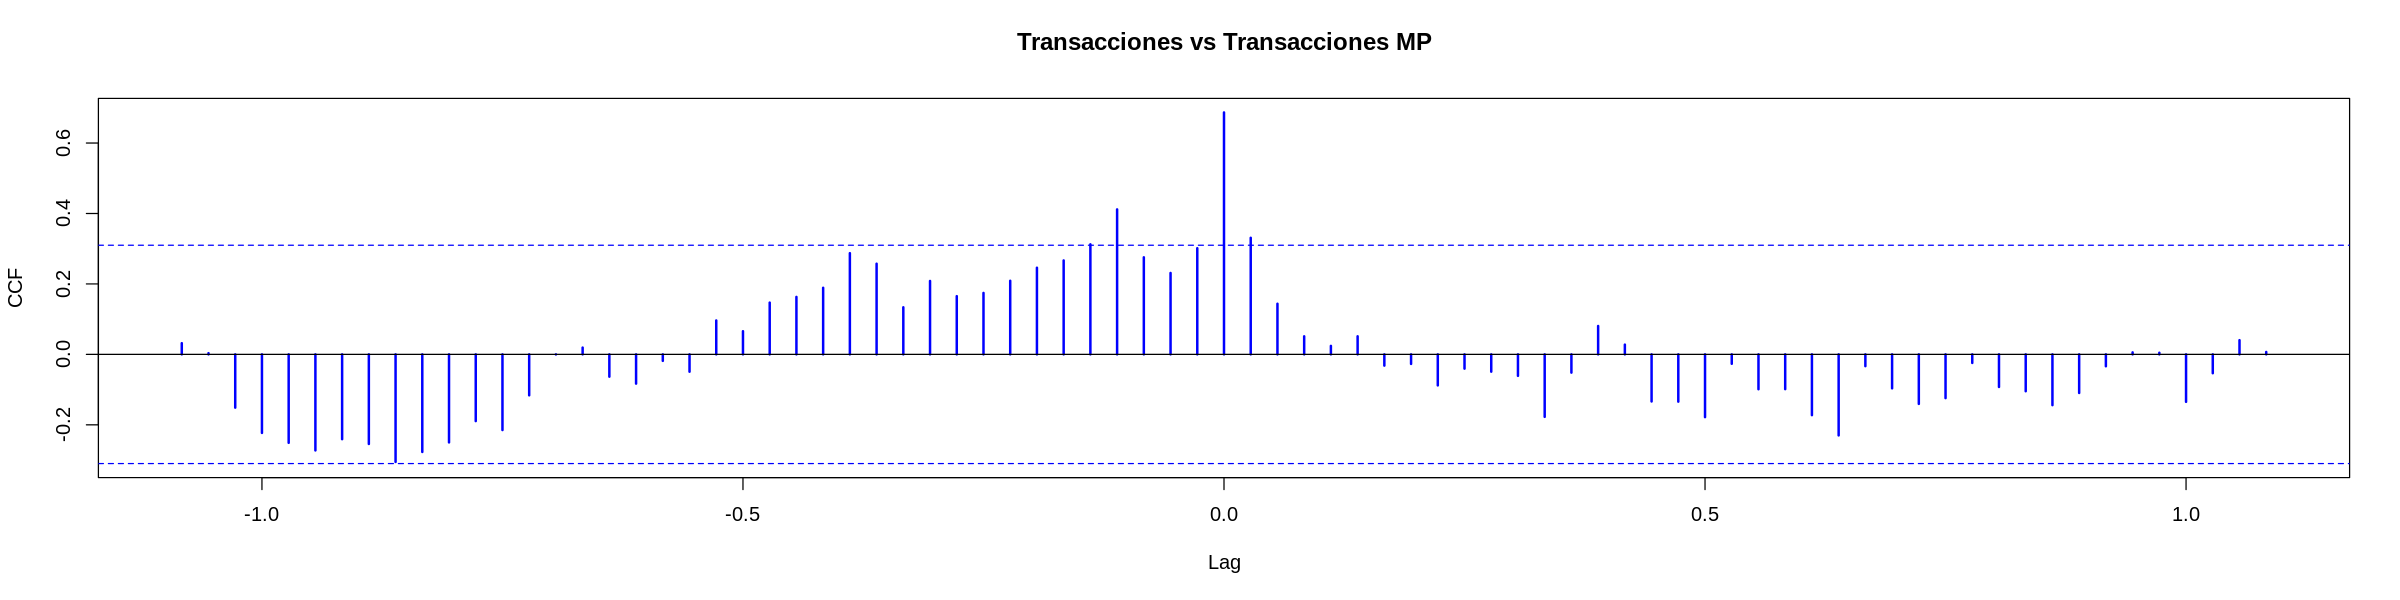

In [11]:
ccf(datos_st_40,datosmp_st_40,40,  main="Transacciones vs Transacciones MP", ylab="CCF", col=4, lwd=2)

###### La correlación cruzada tiene un pico (positivo) en -4 meses. Esto indica que la serie TransaccionesTotal puede predecir la serie de TransaccionesMP usando el valor de 4 meses antes.

#### Análisis de la correlacion con lag -4

In [12]:
datos_corr = ts.intersect(datosmp_st_40, datos_st_40_Lag=lag(datos_st_40,-4), dframe=TRUE)
fit = lm(datosmp_st_40 ~ datos_st_40_Lag, data = datos_corr)
summary(fit)


Call:
lm(formula = datosmp_st_40 ~ datos_st_40_Lag, data = datos_corr)

Residuals:
    Min      1Q  Median      3Q     Max 
-8283.2 -2262.1  -610.3  2281.1 10525.5 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)   
(Intercept)     6.291e+03  4.851e+03   1.297  0.20343   
datos_st_40_Lag 4.434e-02  1.282e-02   3.458  0.00148 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3820 on 34 degrees of freedom
Multiple R-squared:  0.2602,	Adjusted R-squared:  0.2384 
F-statistic: 11.96 on 1 and 34 DF,  p-value: 0.001483


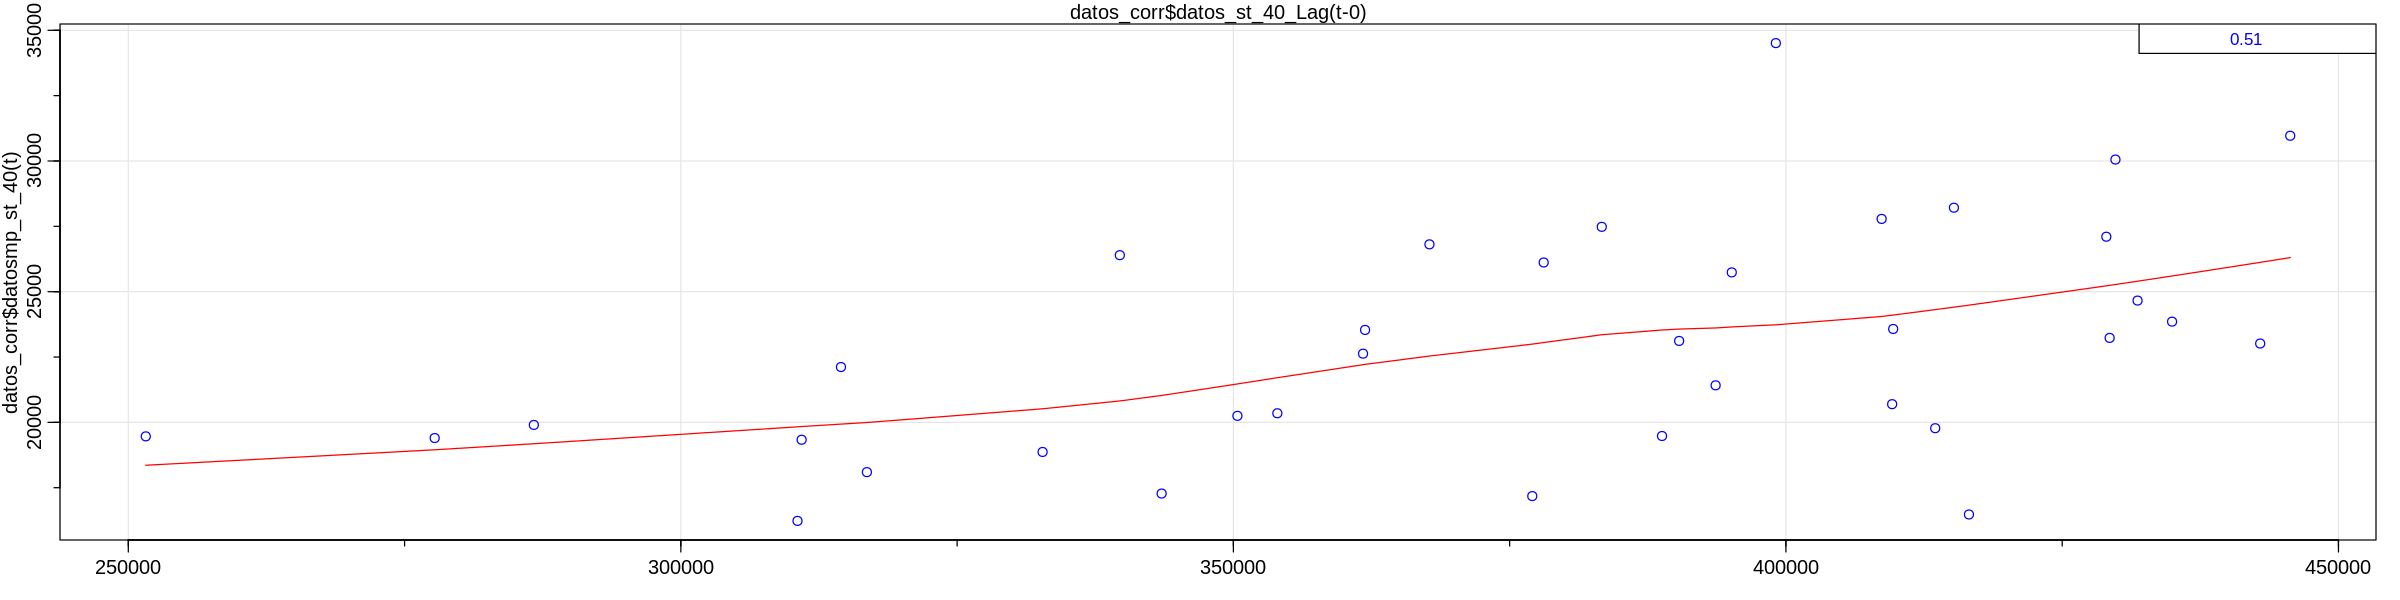

In [13]:
lag2.plot(datos_corr$datos_st_40_Lag,datos_corr$datosmp_st_40, col=4)
abline((fit), col = 6)

#### Análisis de las series viendo el log y las diferencias

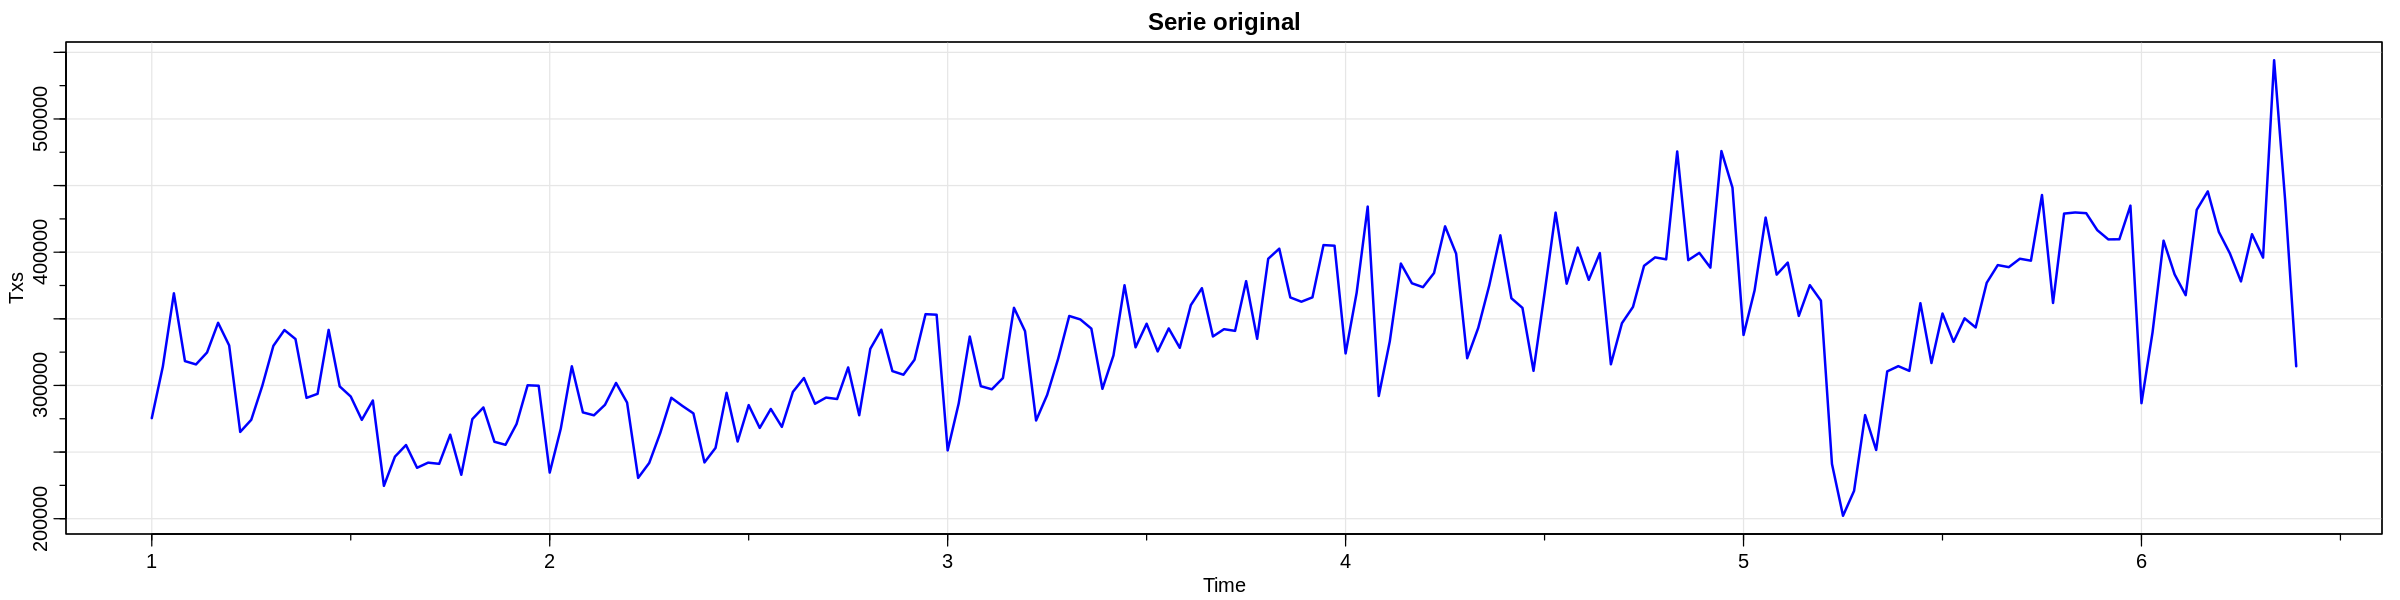

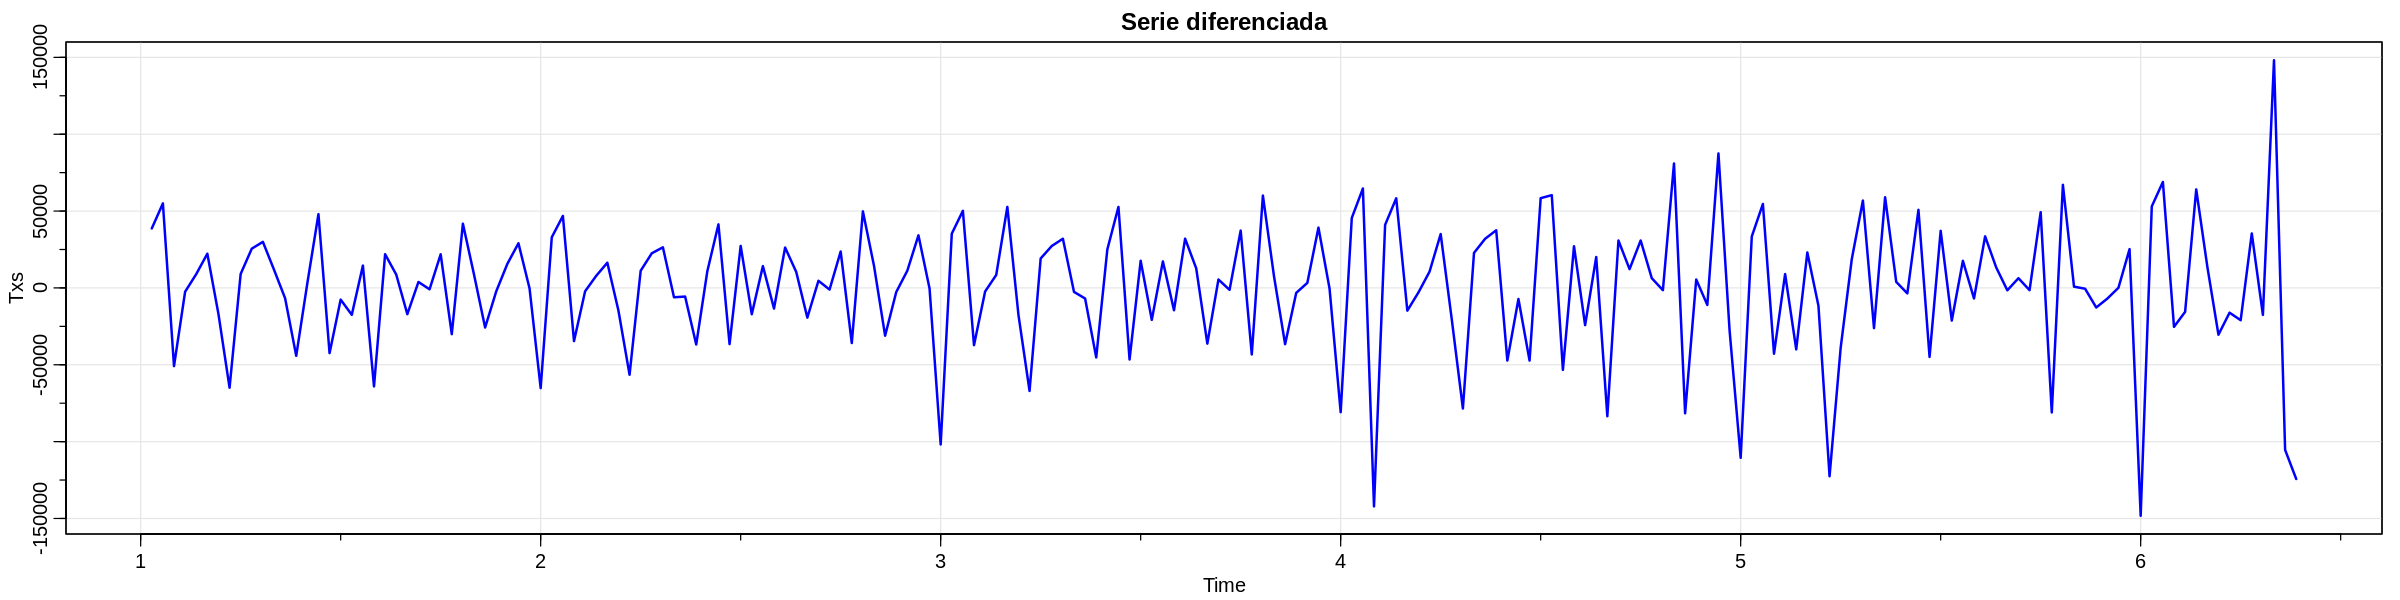

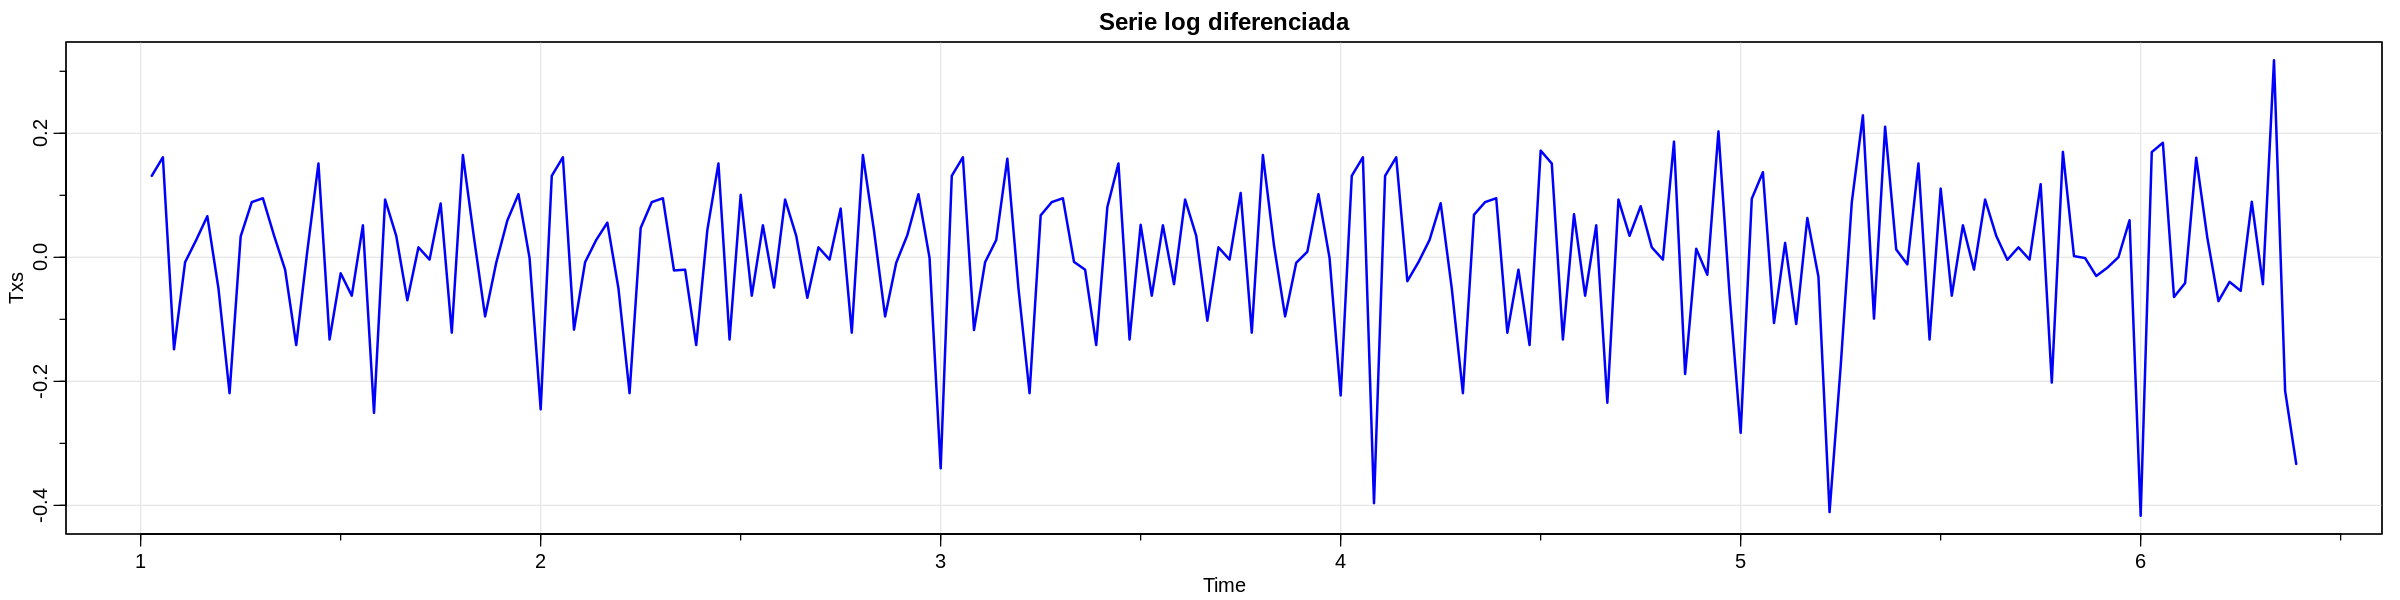

In [14]:
tsplot(datos_st, main="Serie original",  ylab="Txs", lwd=2, col=4)
tsplot(diff(datos_st),main="Serie diferenciada",  ylab="Txs", lwd=2, col=4)
tsplot(diff(log(datos_st)),main="Serie log diferenciada",  ylab="Txs", lwd=2, col=4)

In [15]:
#Ajuste1 - tendencia
t = time(datos_st) -1 #time (el valor 1 lo sacamos de ver los valores de time(datos_st))
fit1 = lm(datos_st~t)
summary(fit1)
num = length(datos_st)                               # sample size
AIC(fit)/num - log(2*pi)                            # AIC 
BIC(fit)/num - log(2*pi)                            # BIC


Call:
lm(formula = datos_st ~ t)

Residuals:
    Min      1Q  Median      3Q     Max 
-172187  -25626    2403   27109  143279 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   270666       6498   41.65   <2e-16 ***
t              24401       2086   11.70   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 45550 on 193 degrees of freedom
Multiple R-squared:  0.4149,	Adjusted R-squared:  0.4118 
F-statistic: 136.8 on 1 and 193 DF,  p-value: < 2.2e-16


[1] 1.751666

[1] 1.776028

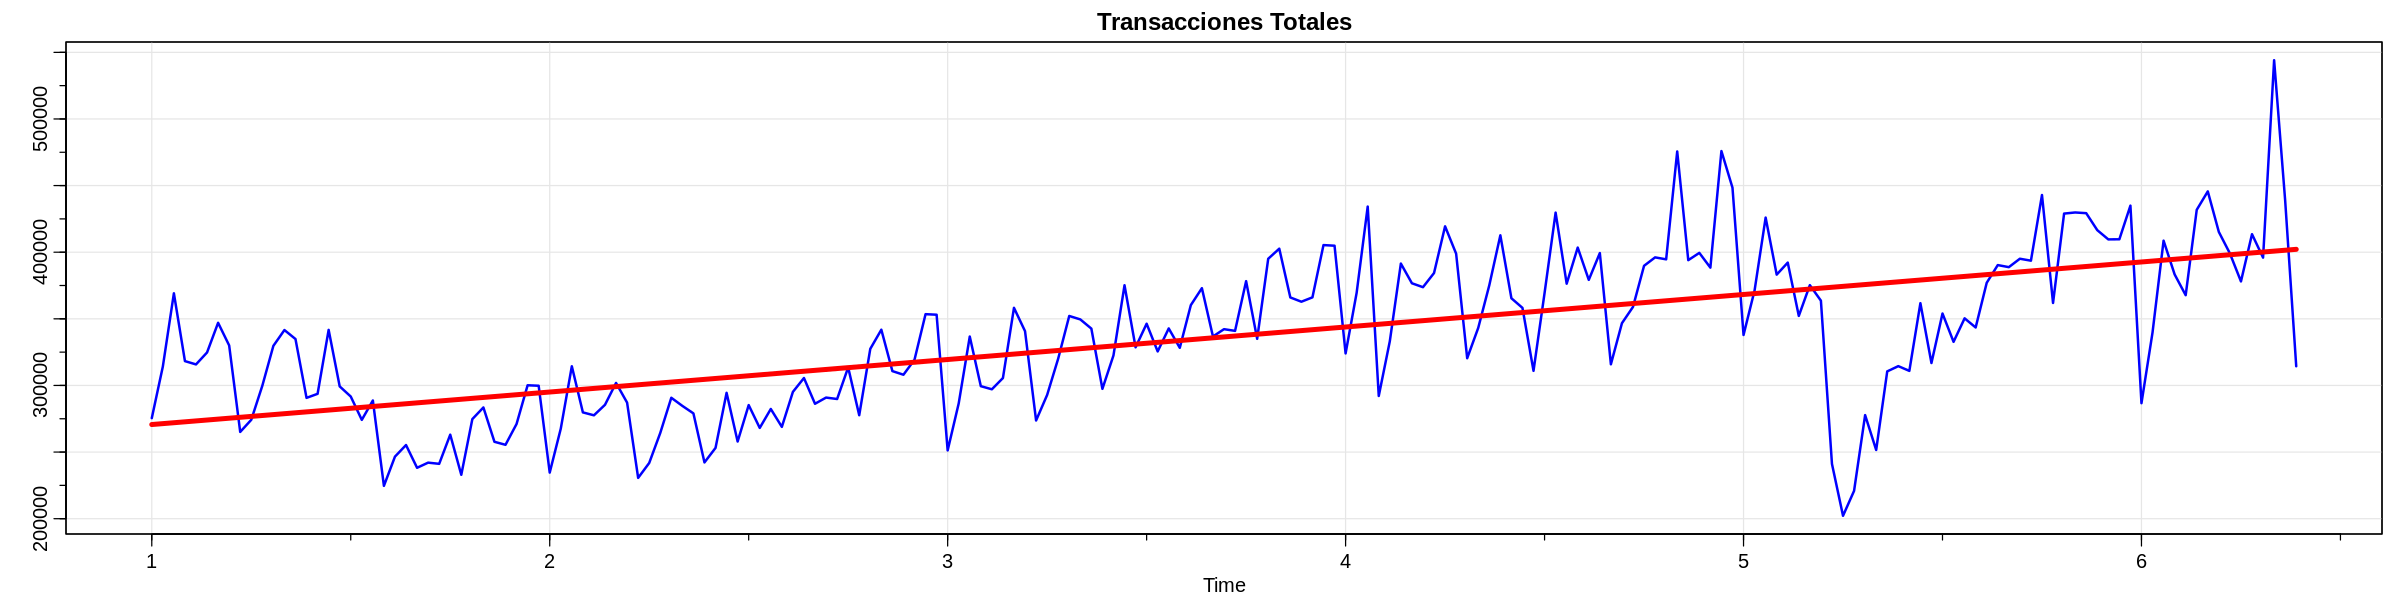

In [16]:
prediction_1 = ts(fitted(fit1), start = 1, frequency = 36)
tsplot(datos_st, main="Transacciones Totales", ylab="", lwd=2, col=4)
lines(prediction_1, col=2, lwd=4)

###### Acá se confirma que la tendencia es creciente.

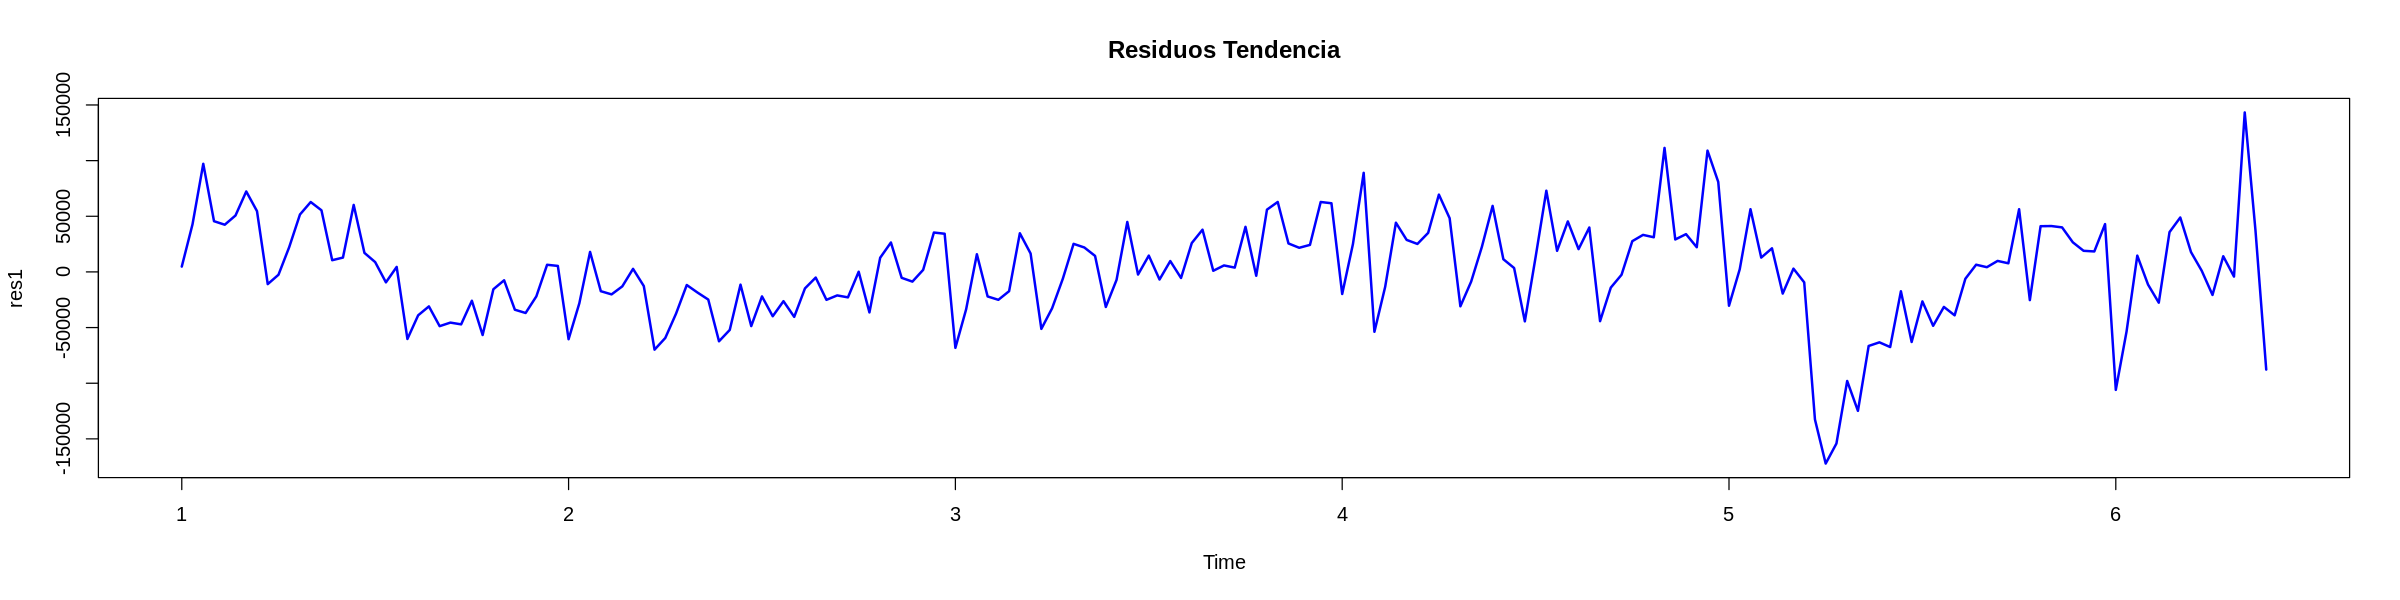

In [17]:
#Residuos obtenidos del ajuste de la tendencia
res1 = ts(residuals(fit1), frequency = 36)
plot(res1, col = 4, lwd = 2, main = 'Residuos Tendencia')

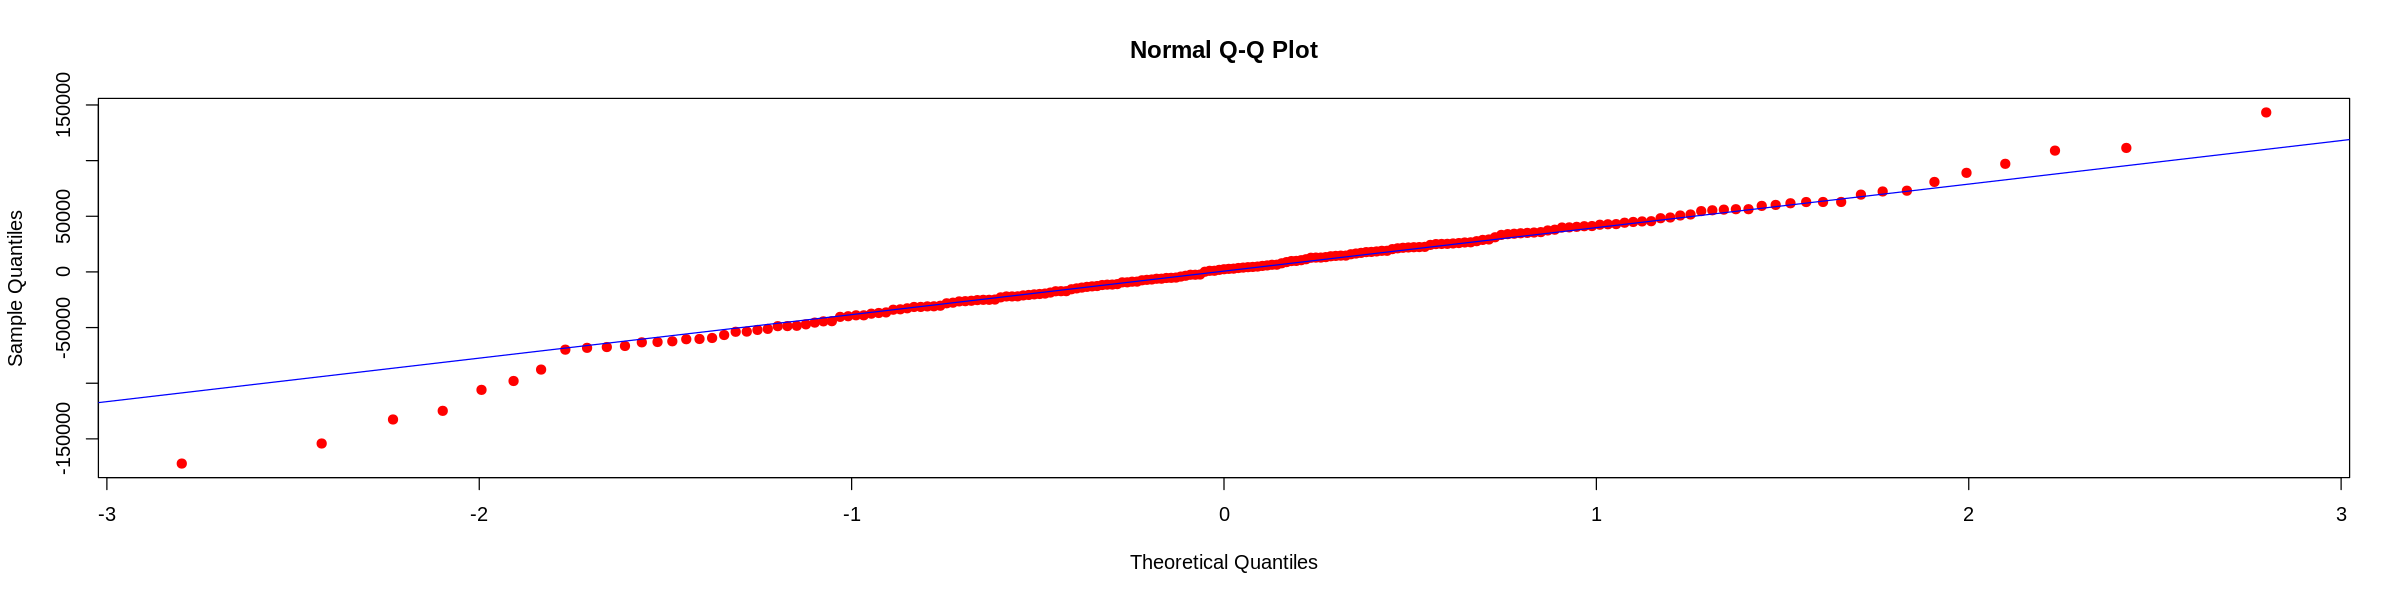

In [18]:
qqnorm(res1, col=2, pch = 19)
qqline(res1, col=4)

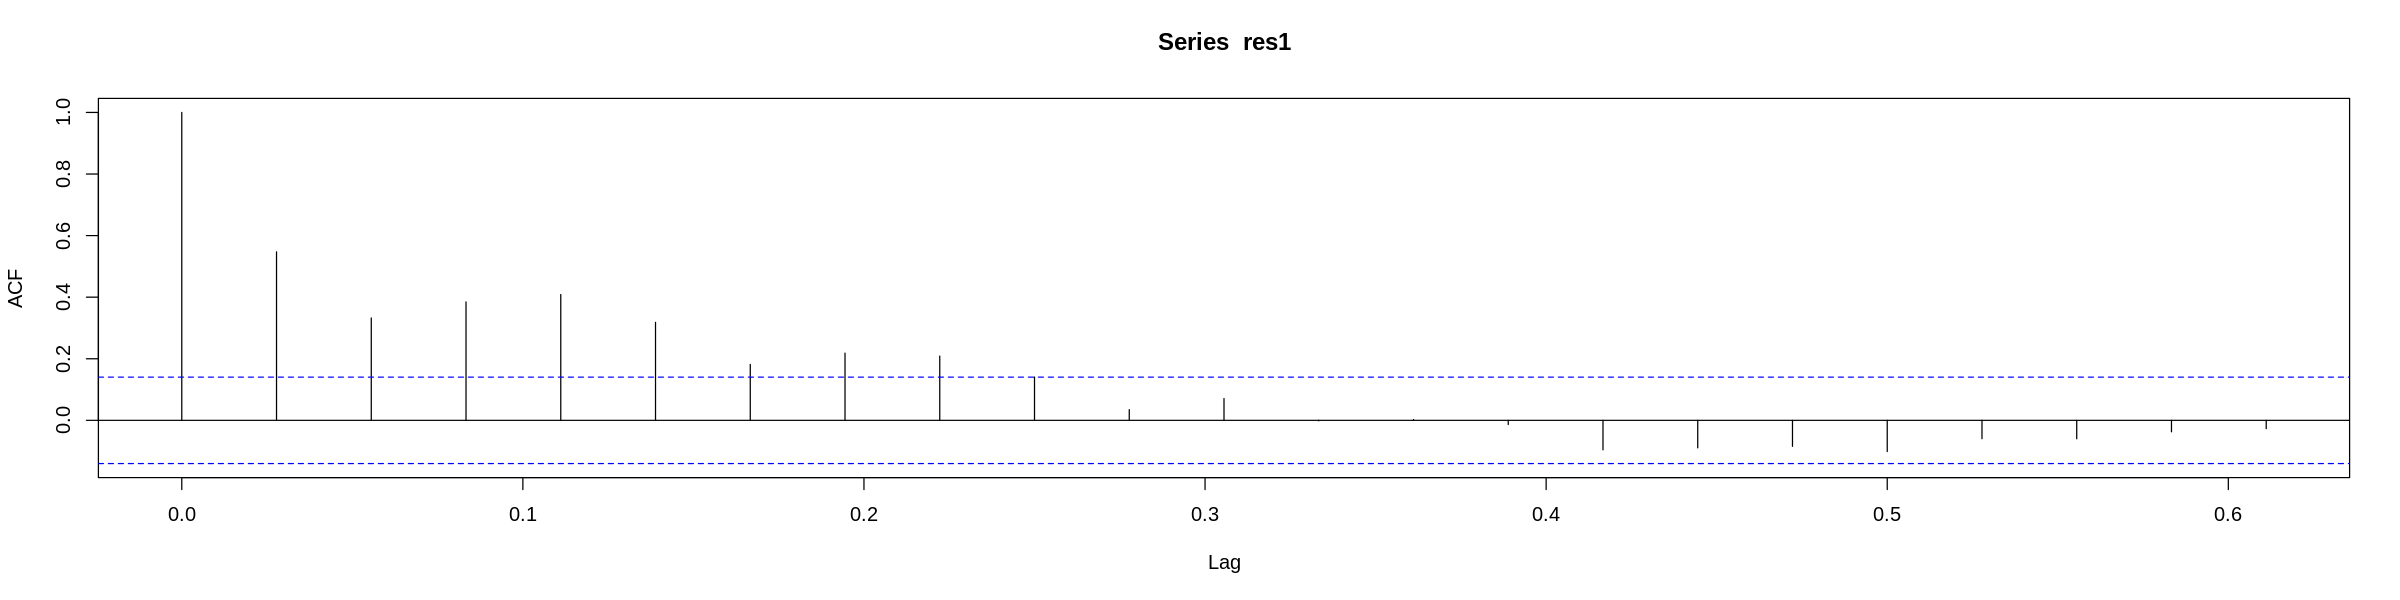

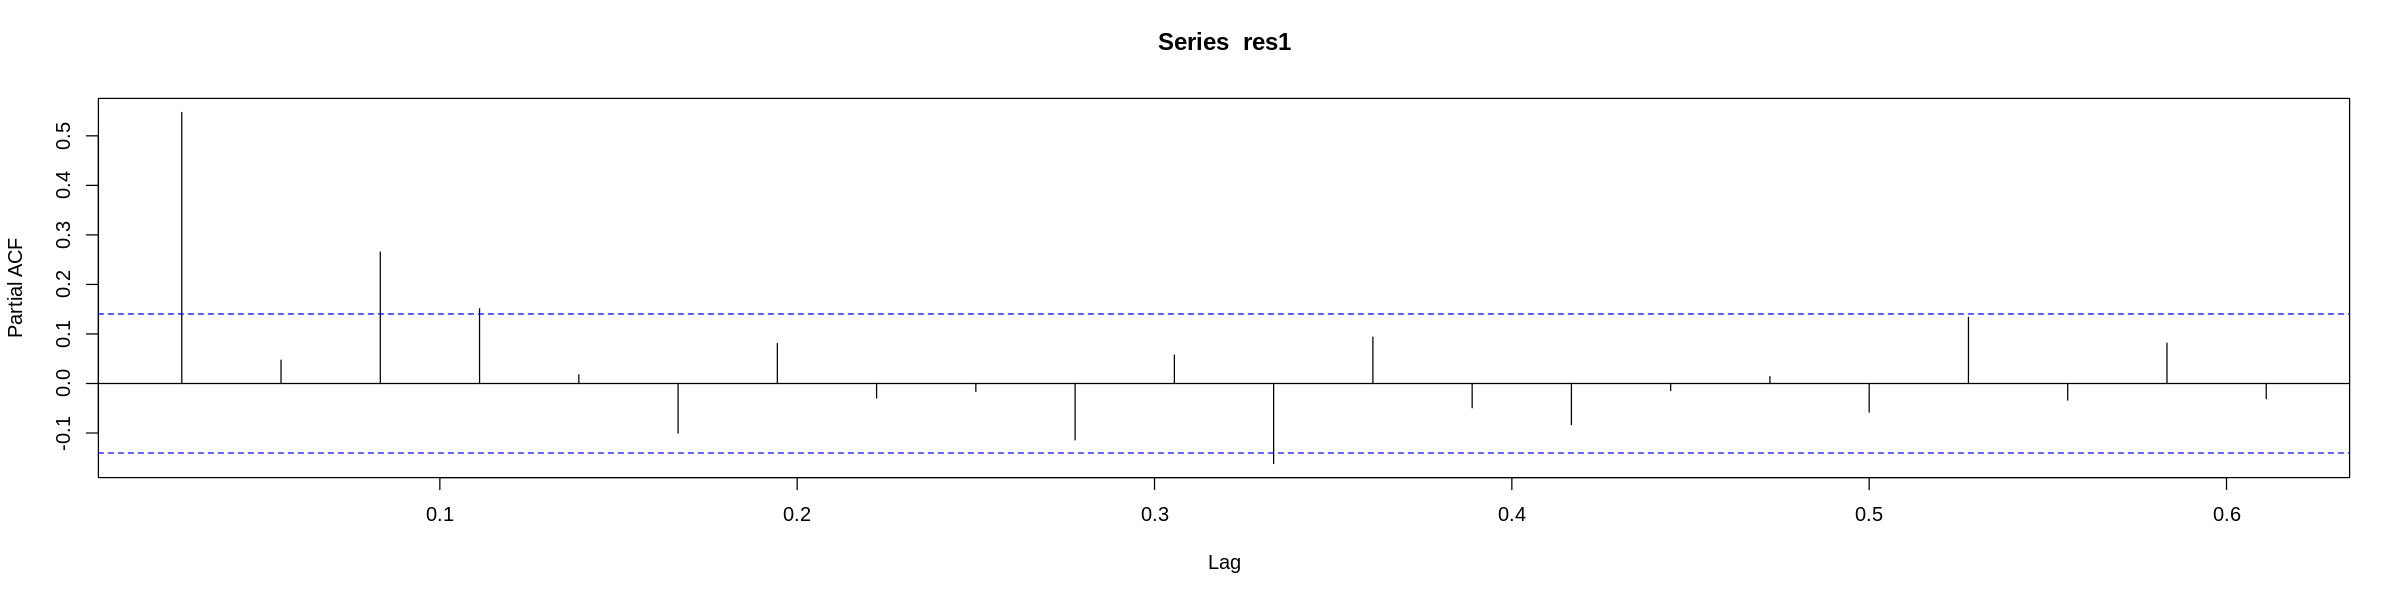

In [19]:
acf(res1)
pacf(res1)

In [20]:
#Ajuste2 - variables dummies para estaciones
x=rep(c(1,0,0),65)
y=rep(c(0,1,0),65)
z=rep(c(0,0,1),65)

fit2 = lm(datos_st ~ y + z)
summary(fit2)
num = length(datos_st)                                  # sample size
AIC(fit2)/num - log(2*pi)                                # AIC 
BIC(fit2)/num - log(2*pi)                                # BIC


Call:
lm(formula = datos_st ~ y + z)

Residuals:
    Min      1Q  Median      3Q     Max 
-130068  -46504   -2065   45015  211833 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   332253       7396  44.926   <2e-16 ***
y               5970      10459   0.571    0.569    
z               6514      10459   0.623    0.534    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 59620 on 192 degrees of freedom
Multiple R-squared:  0.002481,	Adjusted R-squared:  -0.00791 
F-statistic: 0.2388 on 2 and 192 DF,  p-value: 0.7878


[1] 23.01717

[1] 23.08431

###### Ninguno de los coeficientes es significativo, por lo tanto descartamos este ajuste

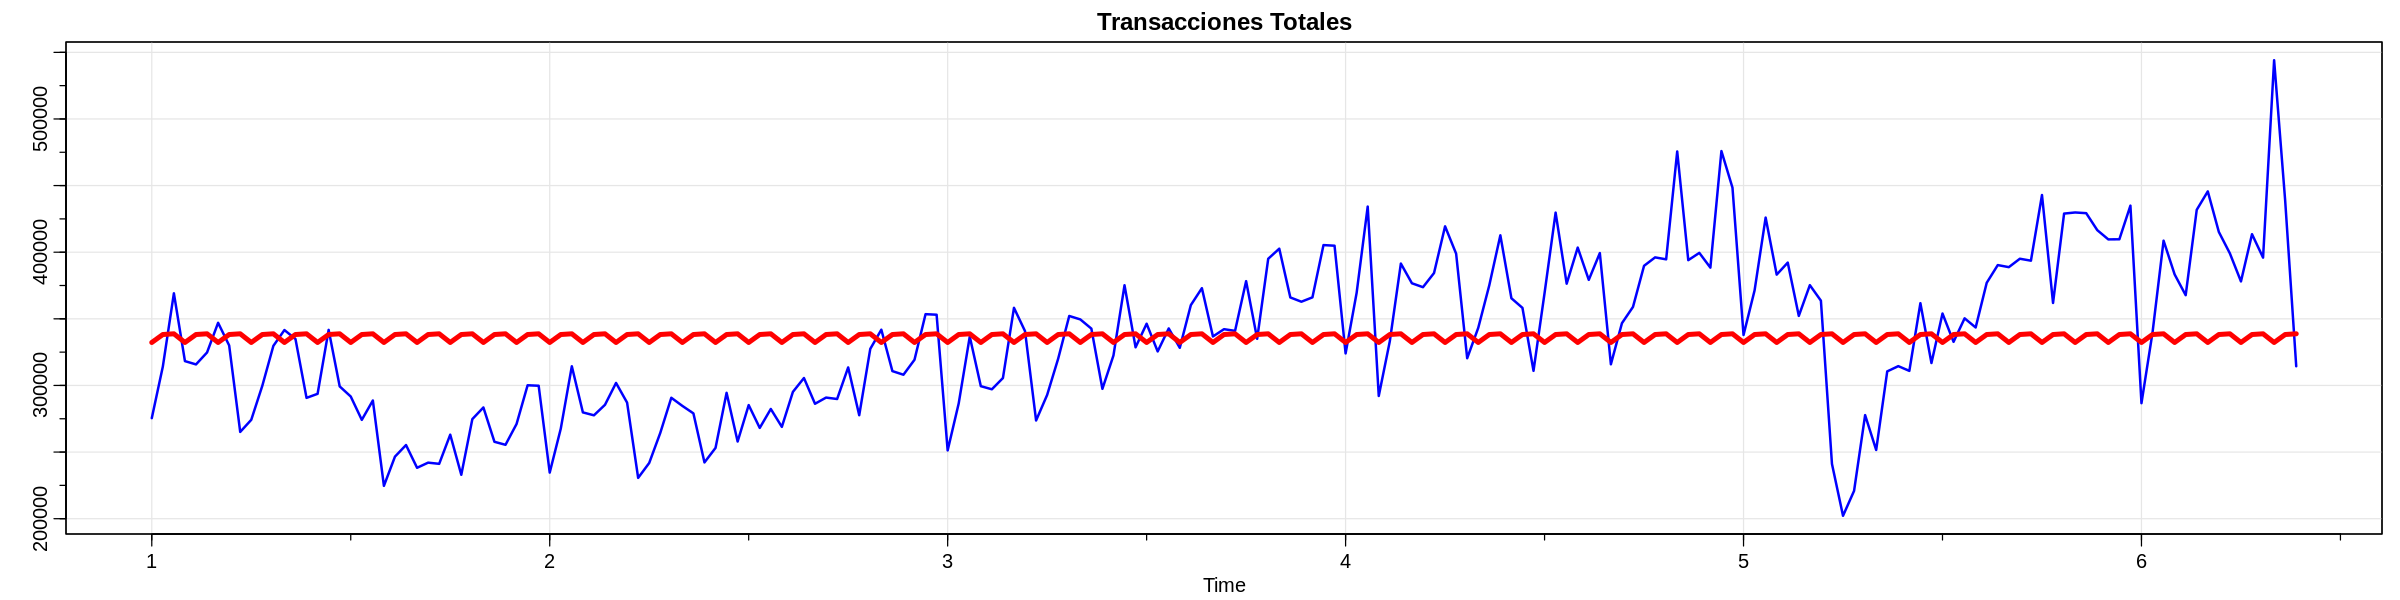

In [21]:
prediction_2 = ts(fitted(fit2), frequency = 36)
tsplot(datos_st, main="Transacciones Totales", ylab="", lwd=2, col=4)
lines(prediction_2, col=2, lwd=4)

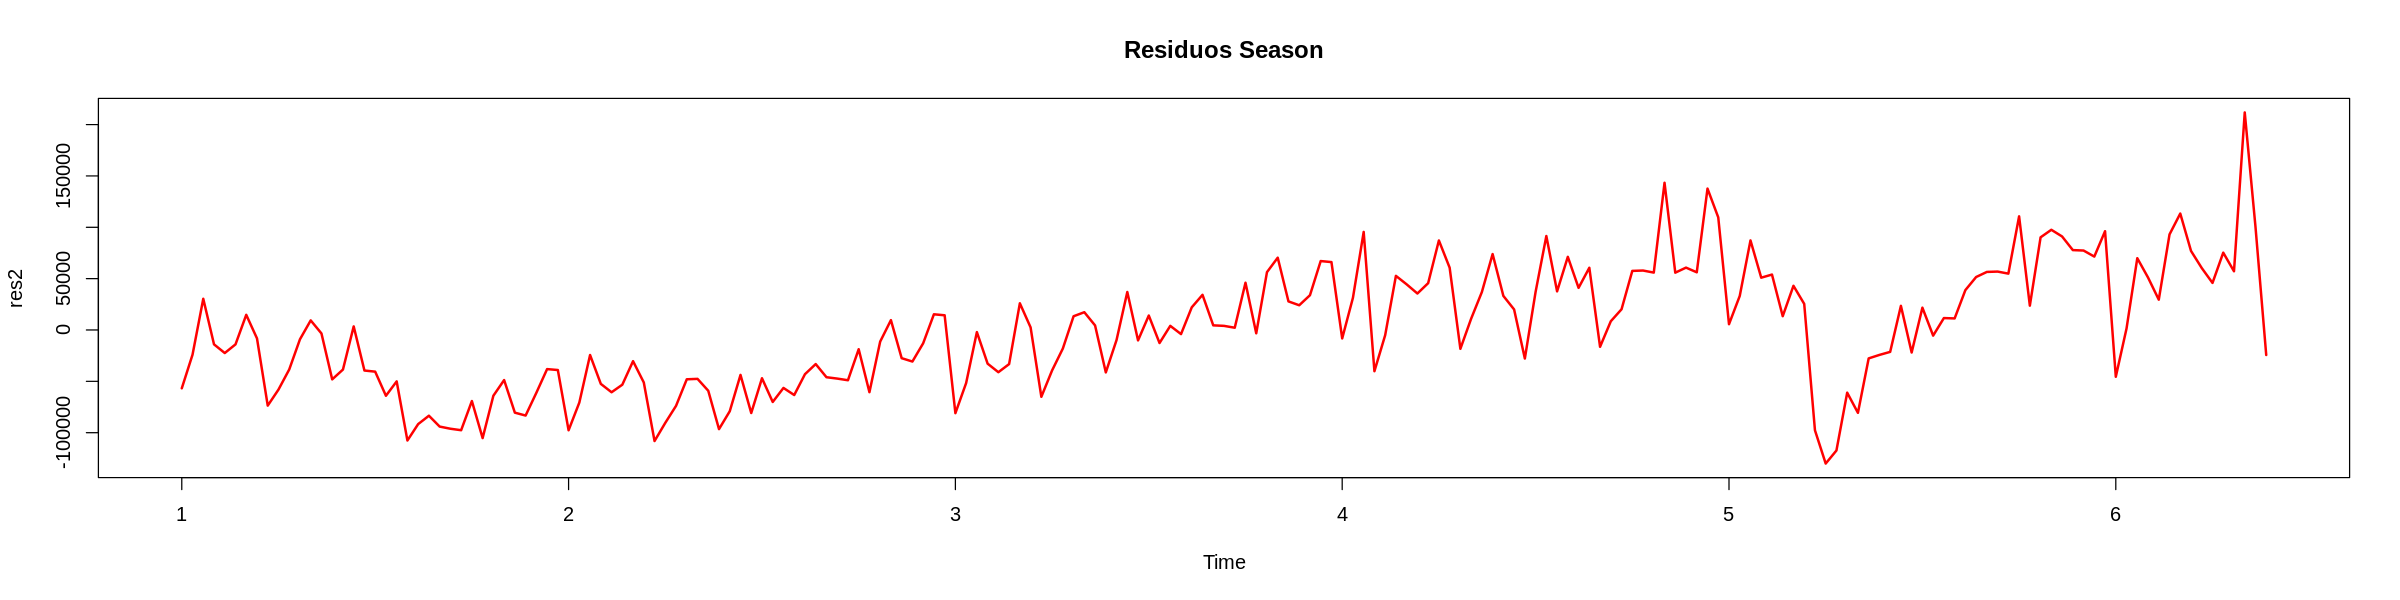

In [22]:
res2= ts(residuals(fit2), frequency = 36)
plot(res2, col = 2, lwd = 2, main = 'Residuos Season')

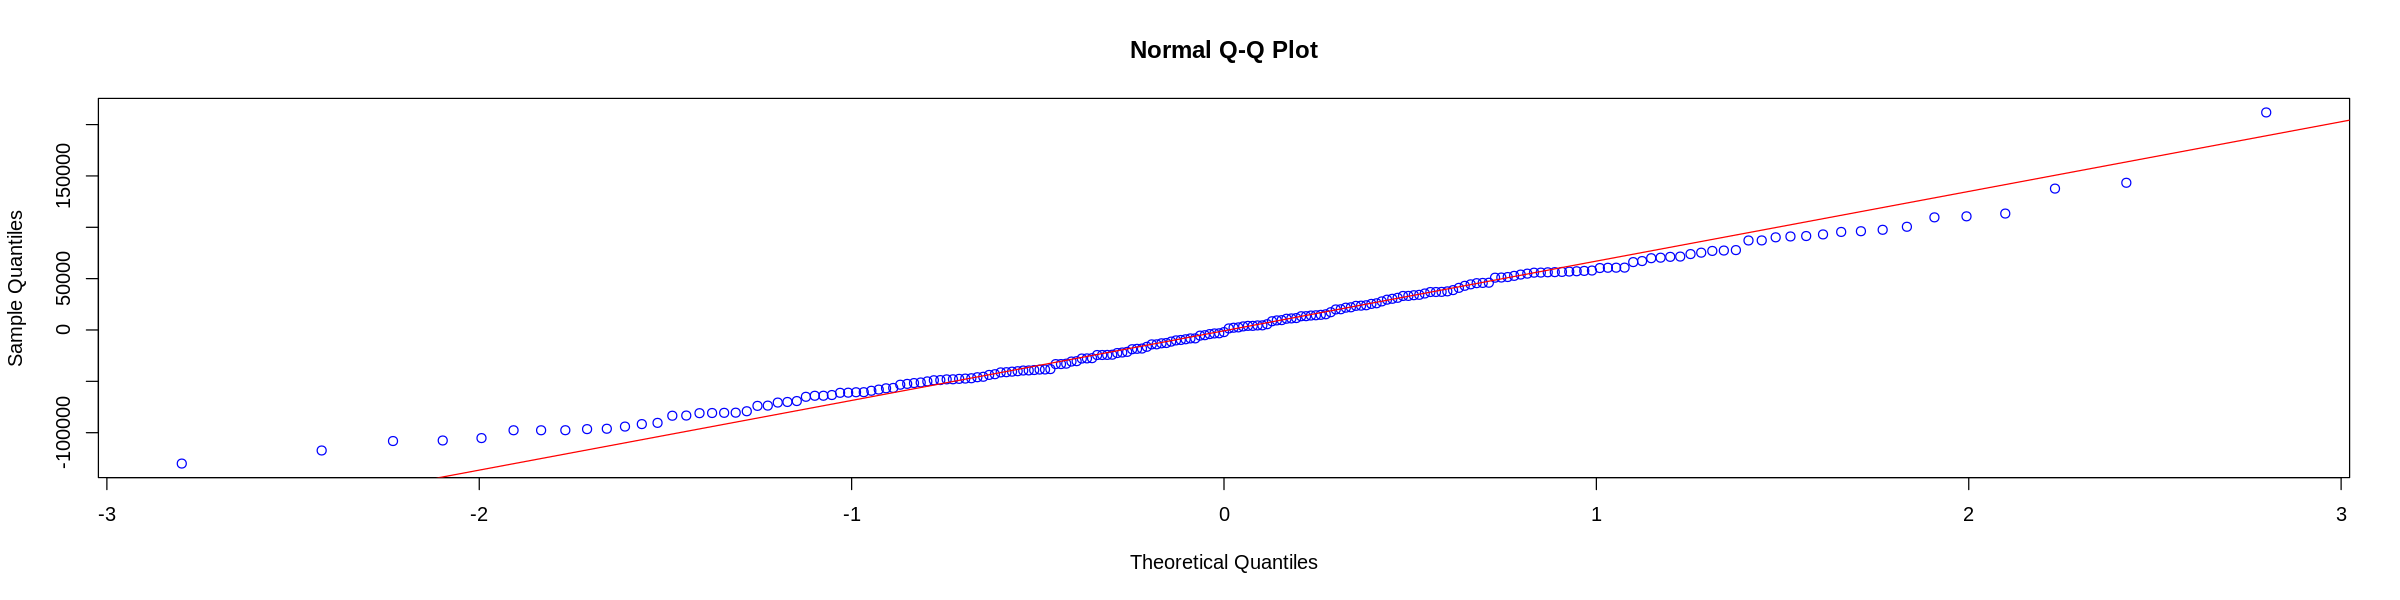

In [23]:
qqnorm(res2, col=4)
qqline(res2, col=2)

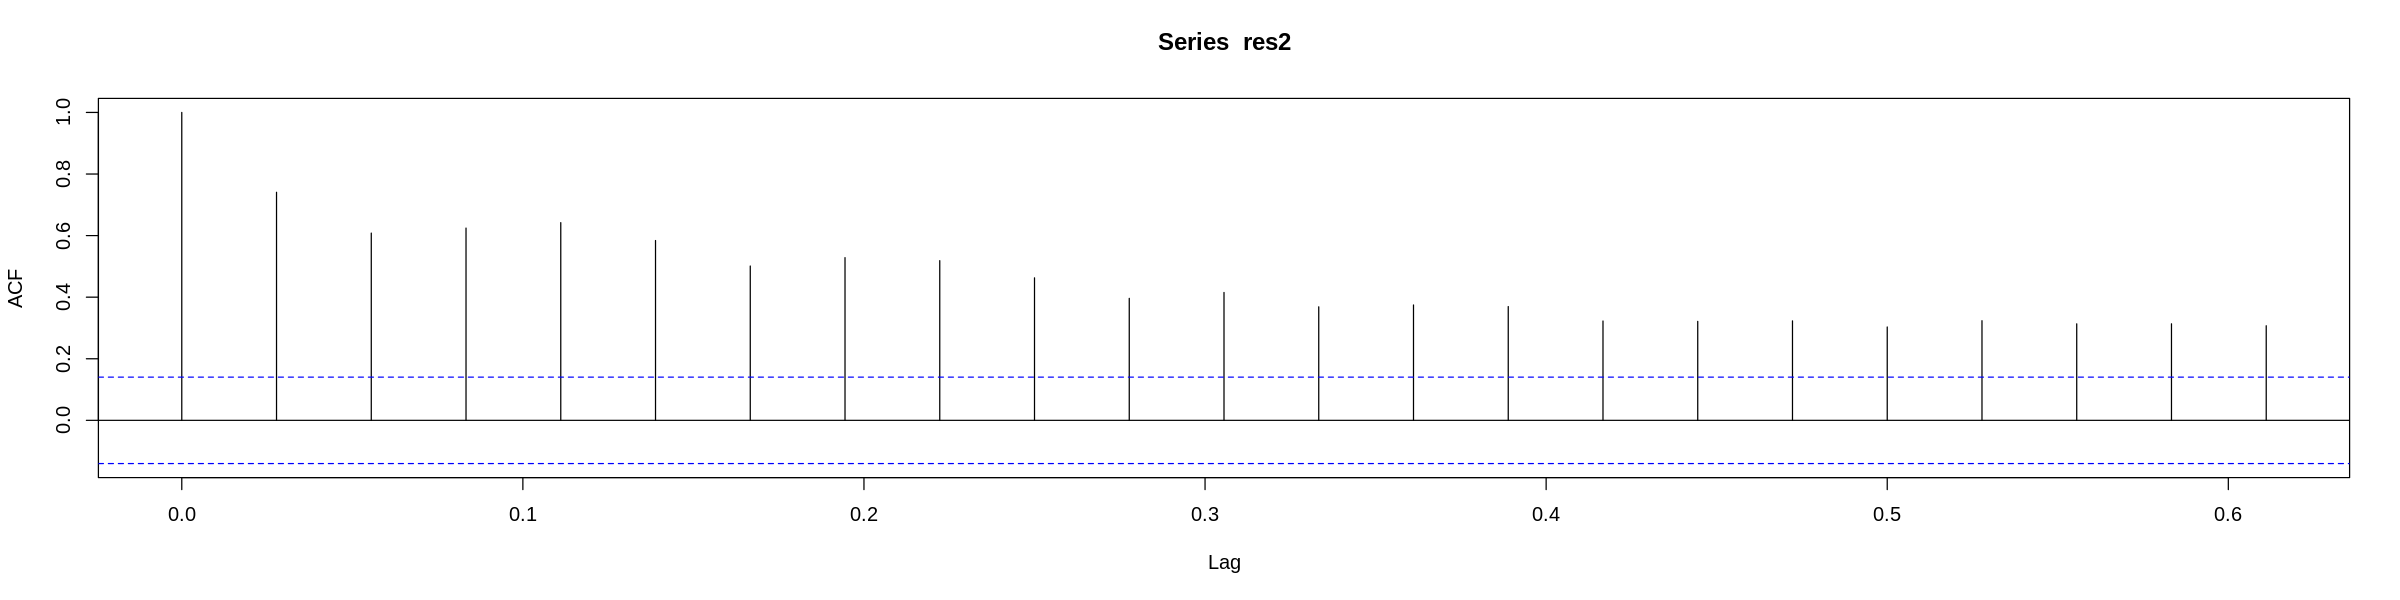

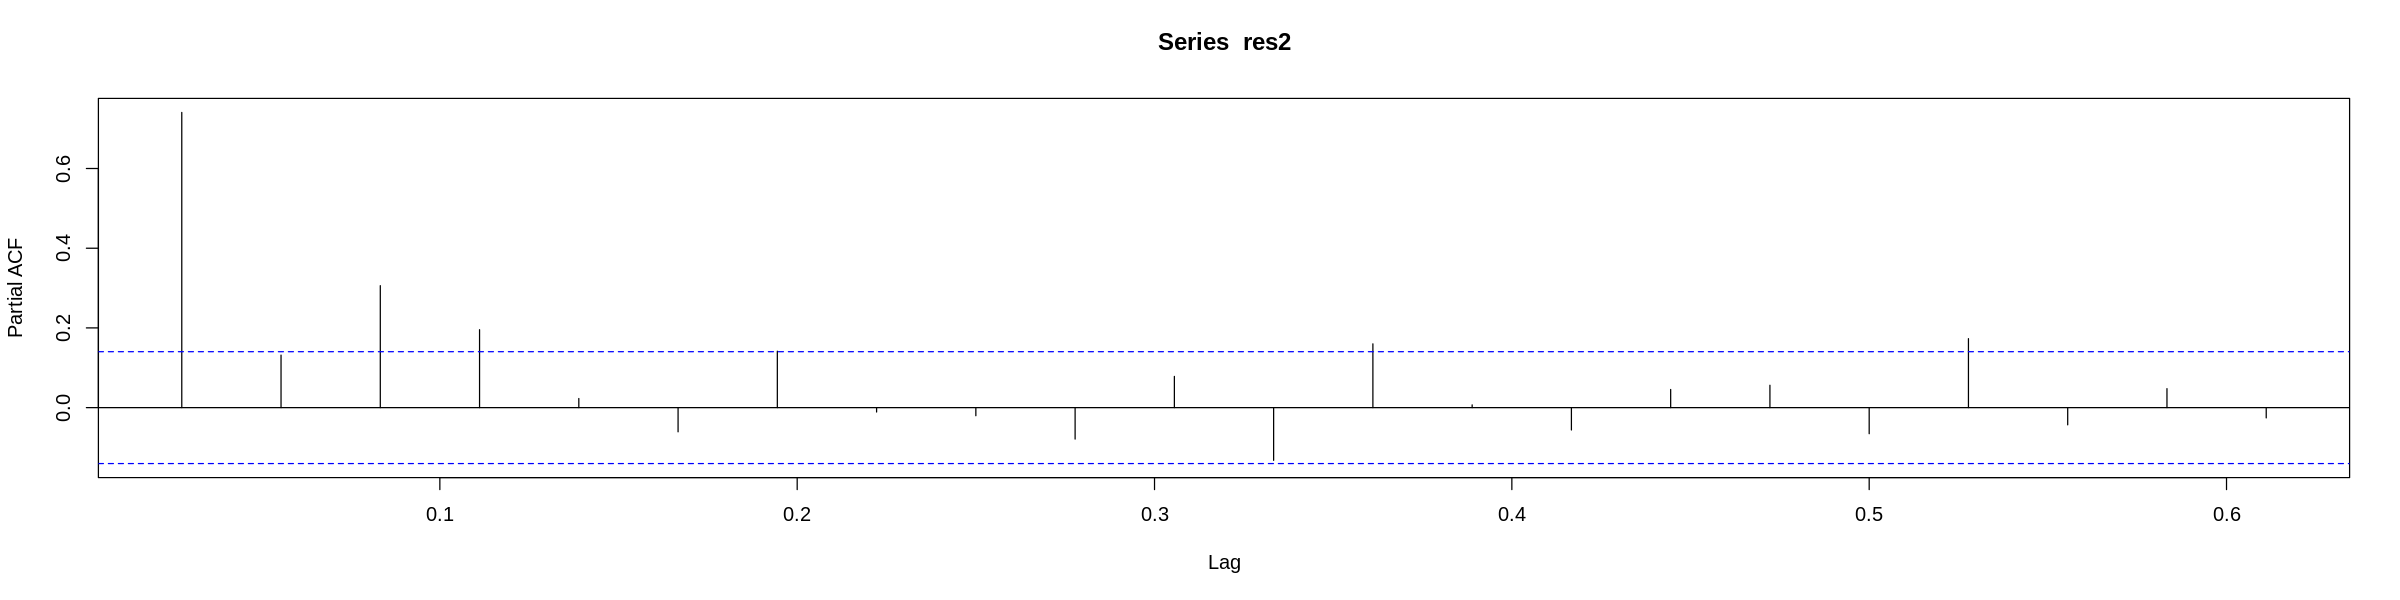

In [24]:
acf(res2)
pacf(res2)

##### PERIODOGRAMA: evaluación de componentes periodicas. 
Usando el ajuste 1

El periodograma me dice que frecuencias correlacionan bien con mi señal

La serie debe estar centrada, por esta razòn le sacamos la tendencia

In [25]:
s=as.numeric(res1) #usamos los residuos de la tendencia
n=length(s)
I = 4/n*abs(fft(s))^2/n
I = I[1:floor(n/2)]
f = (0:(n/2-1))/n*36

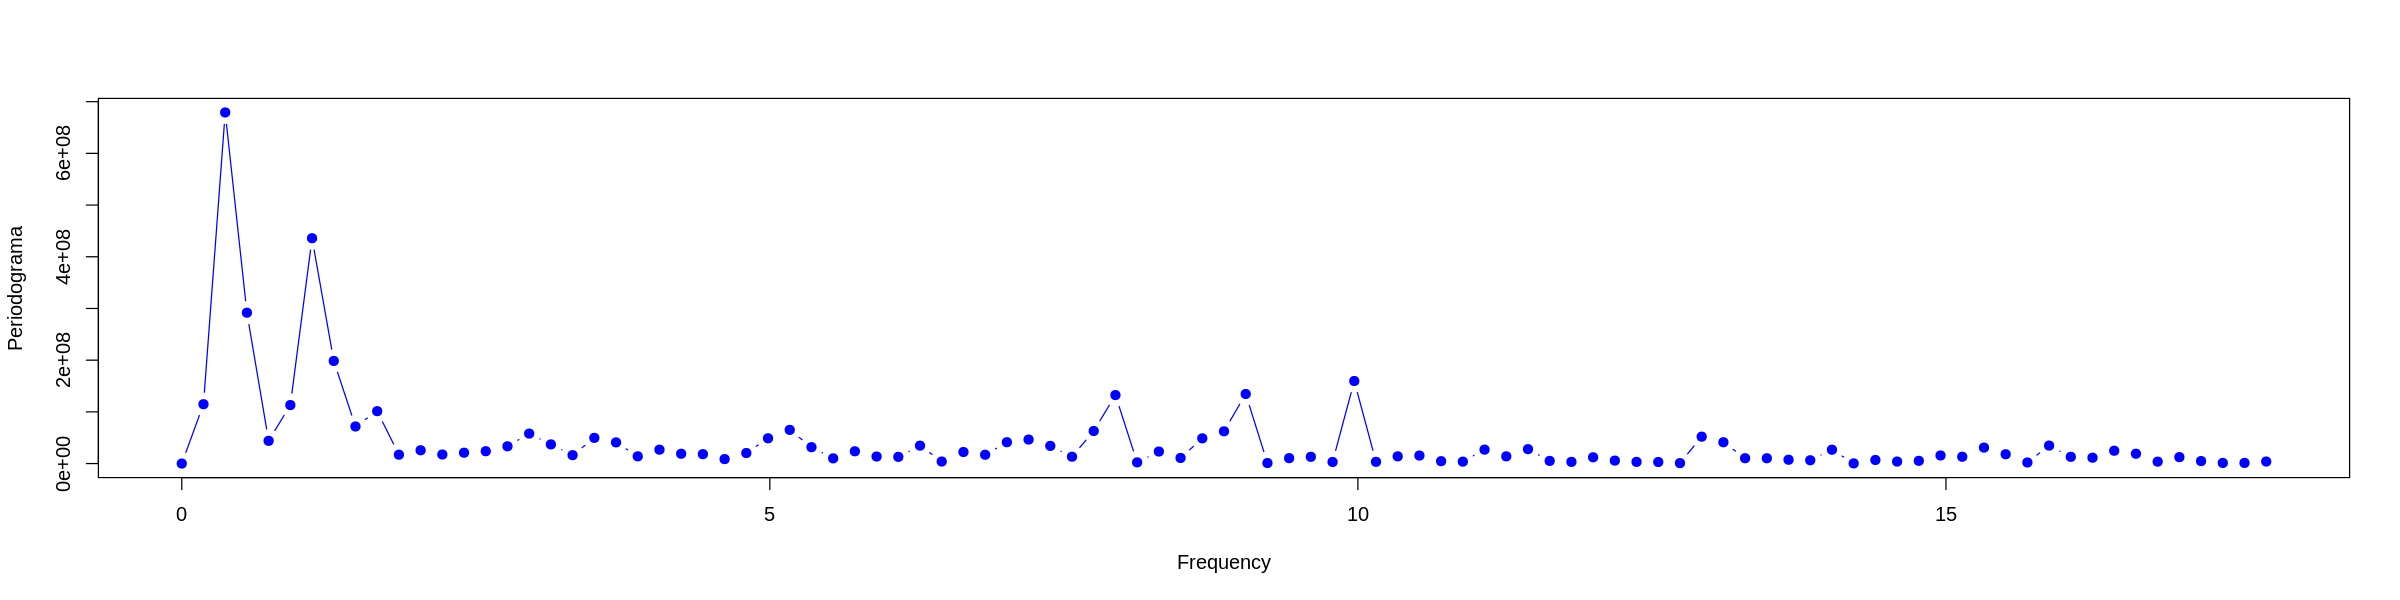

In [26]:
plot(f, I, type = "b", xlab = "Frequency", ylab = "Periodograma", col = 4, lwd = 1,pch = 19)

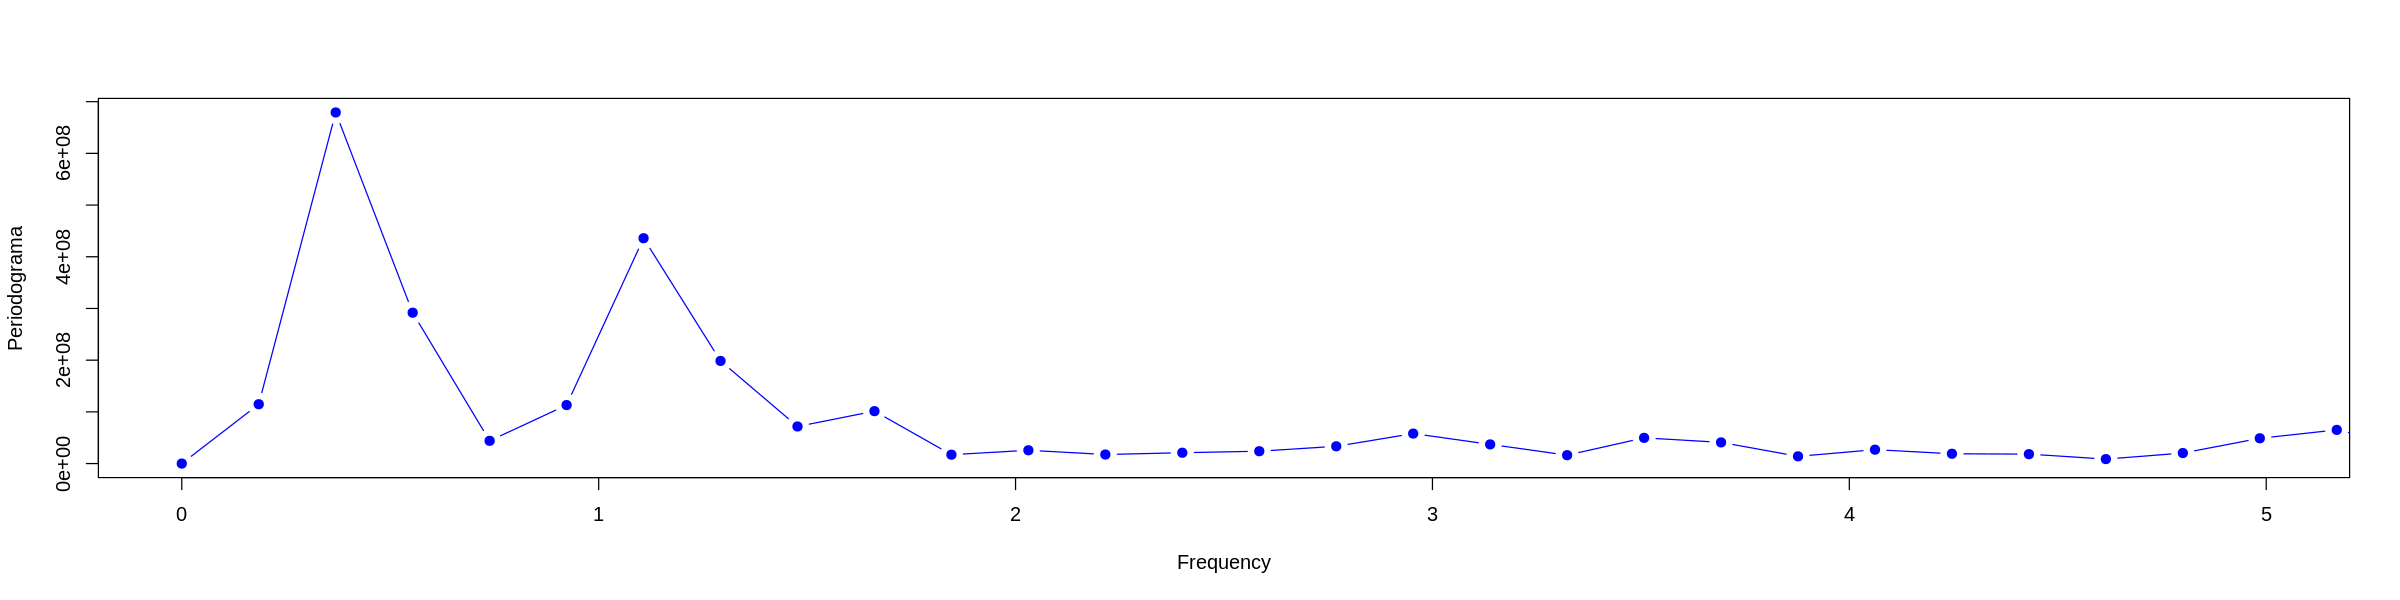

In [27]:
#Hacemos ploteo con zoom para poder las frecuencias de forma mas clara
plot(f, I, type = "b", xlab = "Frequency", ylab = "Periodograma", col = 4, lwd = 1,pch = 19, xlim = c(0,5))

In [28]:
#vemos el vector f para obtener los coeficientes correctos
head(f) #tomaremos el pico 3 y 7

print("Frecuencias elegidas")
print("Frecuencias f[3]")
f[3]

print("Frecuencias f[7]")
f[7]

print("Perìodos")
1/f[3]
1/f[7]

[1] 0.0000000 0.1846154 0.3692308 0.5538462 0.7384615 0.9230769

[1] "Frecuencias elegidas"
[1] "Frecuencias f[3]"


[1] 0.3692308

[1] "Frecuencias f[7]"


[1] 1.107692

[1] "Perìodos"


[1] 2.708333

[1] 0.9027778

In [29]:
# - Ajuste3 - solo con el primer pico
fit3 = lm(res1 ~ cos(2*pi*(1.11)*t) + sin(2*pi*(1.11)*t))
summary(fit3)
num = length(res1)                                  # sample size
AIC(fit3)/num - log(2*pi)                                # AIC 
BIC(fit3)/num - log(2*pi)                                # BIC



Call:
lm(formula = res1 ~ cos(2 * pi * (1.11) * t) + sin(2 * pi * (1.11) * 
    t))

Residuals:
    Min      1Q  Median      3Q     Max 
-152286  -25065    3435   27945  154784 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  6.136   3094.104   0.002    0.998    
cos(2 * pi * (1.11) * t) -1759.309   4371.188  -0.402    0.688    
sin(2 * pi * (1.11) * t) 20693.823   4380.254   4.724 4.45e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 43210 on 192 degrees of freedom
Multiple R-squared:  0.1048,	Adjusted R-squared:  0.0955 
F-statistic: 11.24 on 2 and 192 DF,  p-value: 2.417e-05


[1] 22.37302

[1] 22.44016

In [30]:
# - Ajuste3 - solo con el primer pico - saco el componente no significativo
fit3 = lm(res1 ~ sin(2*pi*(1.11)*t))
summary(fit3)
num = length(res1)                                  # sample size
AIC(fit3)/num - log(2*pi)                                # AIC 
BIC(fit3)/num - log(2*pi)                                # BIC


Call:
lm(formula = res1 ~ sin(2 * pi * (1.11) * t))

Residuals:
    Min      1Q  Median      3Q     Max 
-151925  -26097    2991   27953  153246 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  2.48    3087.37   0.001    0.999    
sin(2 * pi * (1.11) * t) 20694.24    4370.73   4.735 4.24e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 43110 on 193 degrees of freedom
Multiple R-squared:  0.1041,	Adjusted R-squared:  0.09942 
F-statistic: 22.42 on 1 and 193 DF,  p-value: 4.238e-06


[1] 22.36361

[1] 22.41396

In [31]:
#Ajuste3 - con los dos primeros picos
fit3 = lm(res1 ~ cos(2*pi*(0.37)*t) + sin(2*pi*(0.37)*t)+cos(2*pi*(1.11)*t)+sin(2*pi*(1.11)*t))
summary(fit3)
num = length(res1)                                  # sample size
AIC(fit3)/num - log(2*pi)                                # AIC 
BIC(fit3)/num - log(2*pi)                                # BIC


Call:
lm(formula = res1 ~ cos(2 * pi * (0.37) * t) + sin(2 * pi * (0.37) * 
    t) + cos(2 * pi * (1.11) * t) + sin(2 * pi * (1.11) * t))

Residuals:
    Min      1Q  Median      3Q     Max 
-126297  -23235    3902   23337  134045 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)                -41.33    2810.53  -0.015  0.98828    
cos(2 * pi * (0.37) * t) 23153.82    3970.58   5.831 2.33e-08 ***
sin(2 * pi * (0.37) * t) 11735.50    3978.79   2.950  0.00358 ** 
cos(2 * pi * (1.11) * t) -1854.21    3970.58  -0.467  0.64104    
sin(2 * pi * (1.11) * t) 20699.34    3978.78   5.202 5.07e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 39250 on 190 degrees of freedom
Multiple R-squared:  0.2691,	Adjusted R-squared:  0.2537 
F-statistic: 17.49 on 4 and 190 DF,  p-value: 3.1e-12


[1] 22.1908

[1] 22.29151

In [32]:
#Ajuste3 -- sacamos el componente no significativo
fit3 = lm(res1 ~ cos(2*pi*(0.37)*t) + sin(2*pi*(0.37)*t)+sin(2*pi*(1.11)*t))
summary(fit3)
num = length(res1)                                  # sample size
AIC(fit3)/num - log(2*pi)                                # AIC 
BIC(fit3)/num - log(2*pi)                                # BIC



Call:
lm(formula = res1 ~ cos(2 * pi * (0.37) * t) + sin(2 * pi * (0.37) * 
    t) + sin(2 * pi * (1.11) * t))

Residuals:
    Min      1Q  Median      3Q     Max 
-125923  -23724    3541   22604  132431 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)                -45.17    2804.76  -0.016  0.98717    
cos(2 * pi * (0.37) * t) 23146.14    3962.41   5.841  2.2e-08 ***
sin(2 * pi * (0.37) * t) 11735.65    3970.64   2.956  0.00351 ** 
sin(2 * pi * (1.11) * t) 20699.78    3970.63   5.213  4.8e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 39170 on 191 degrees of freedom
Multiple R-squared:  0.2683,	Adjusted R-squared:  0.2568 
F-statistic: 23.34 on 3 and 191 DF,  p-value: 6.472e-13


[1] 22.18169

[1] 22.26561

#### Elegimos el ajuste de los dos picos, considerando solo los componentes significativos

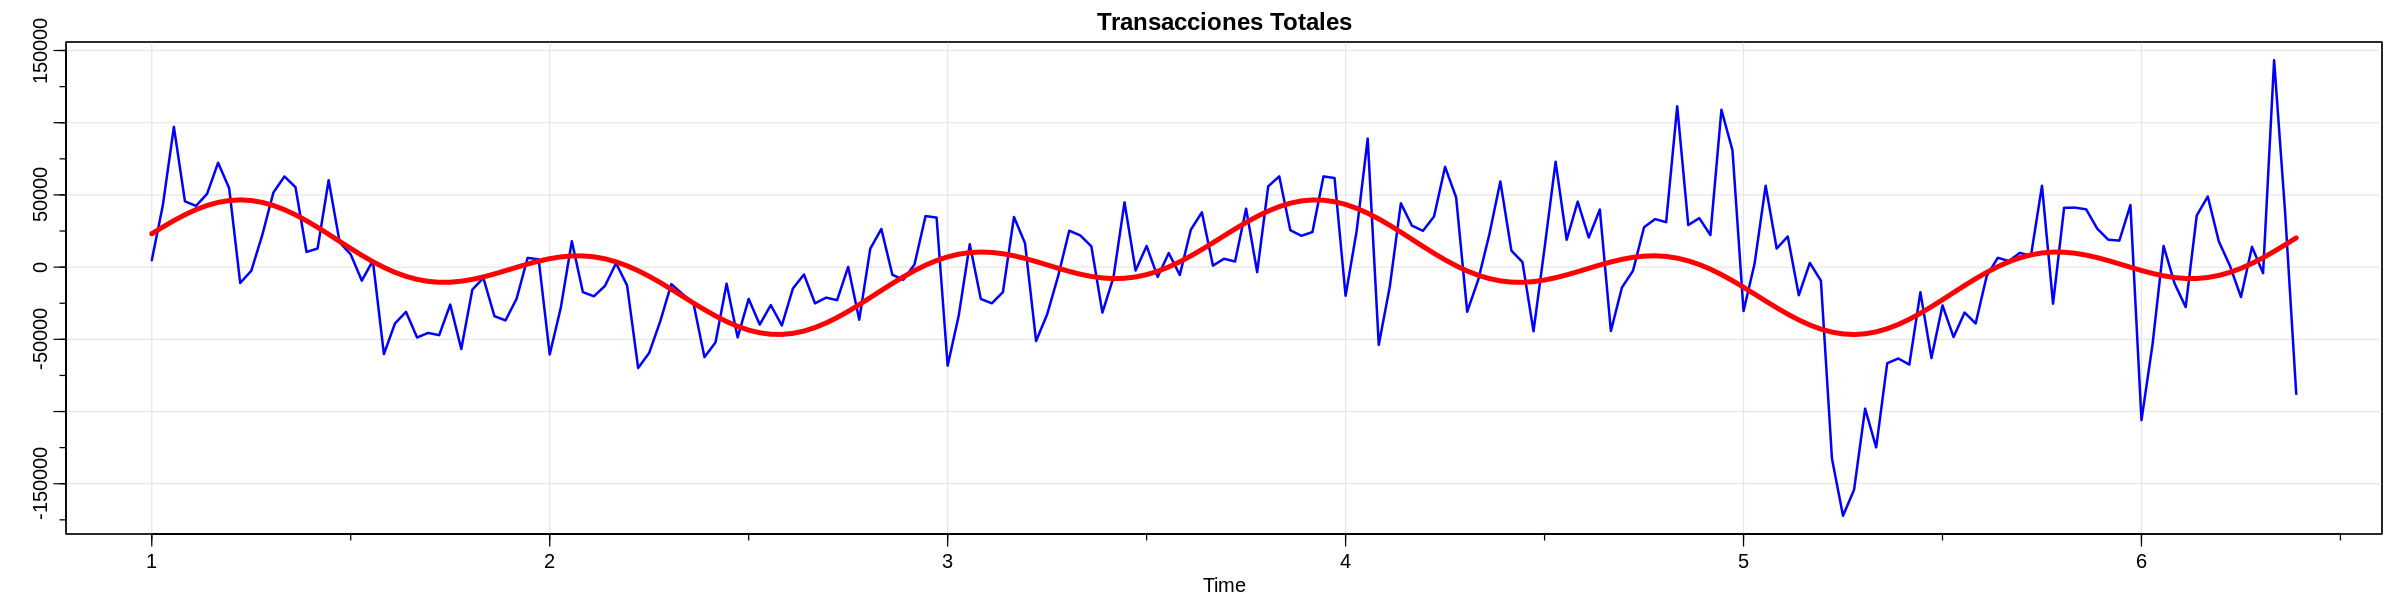

In [33]:
tsplot(res1, main="Transacciones Totales", ylab="", lwd=2, col=4)
prediction3 = ts(fitted(fit3), frequency = 36)
lines(prediction3, col=2, lwd=4)

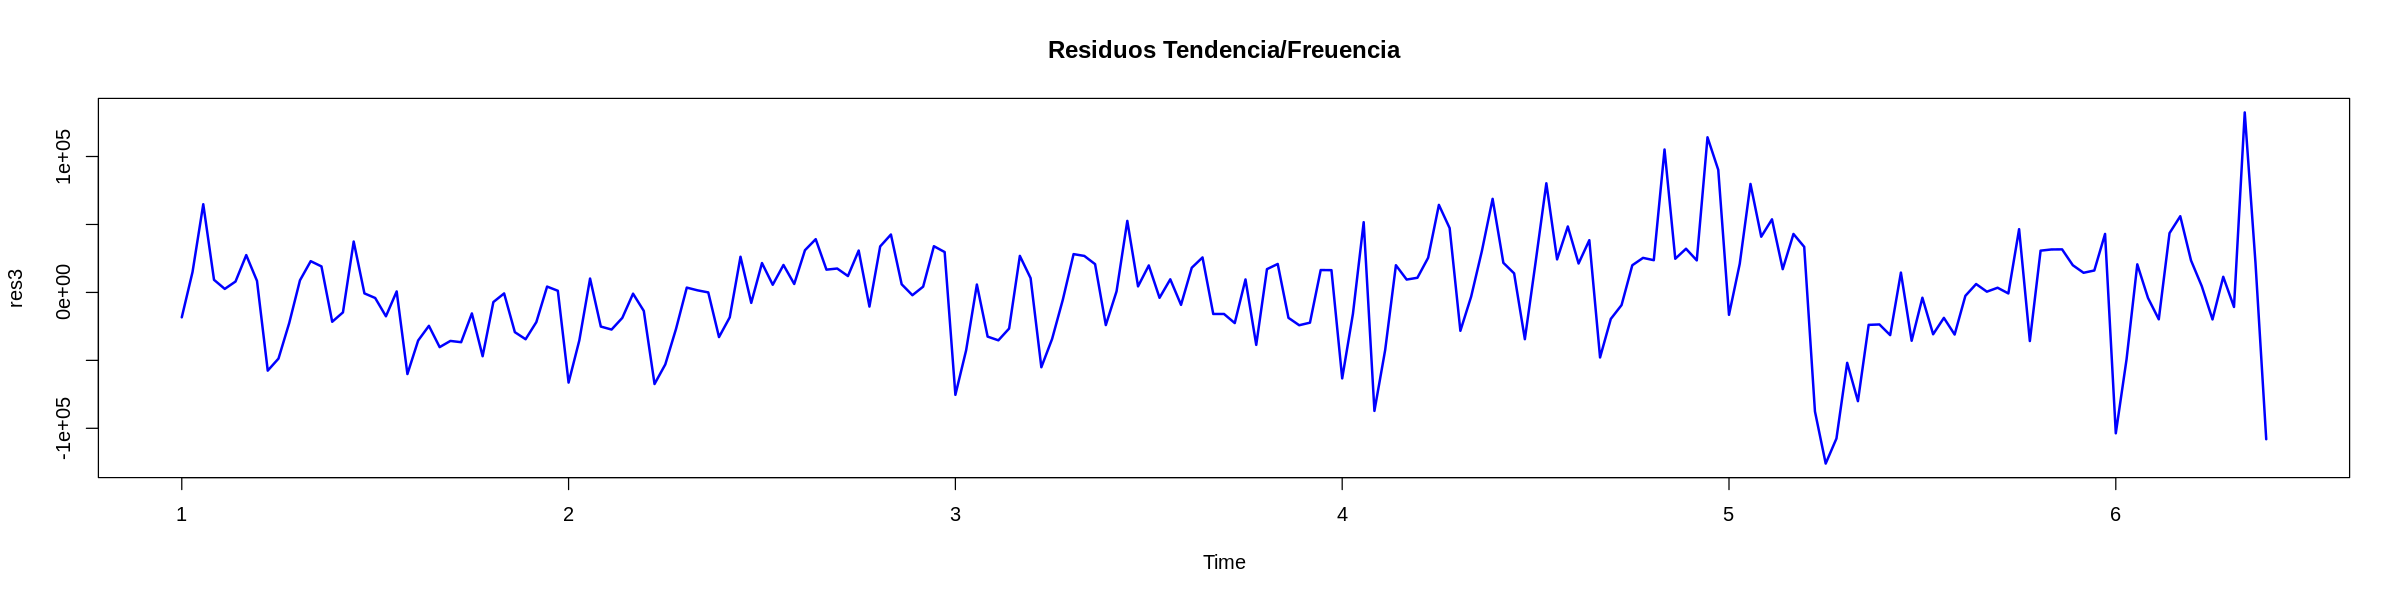

In [34]:
res3 = ts(residuals(fit3), frequency = 36)
plot(res3, col = 4, lwd = 2, main = 'Residuos Tendencia/Freuencia')

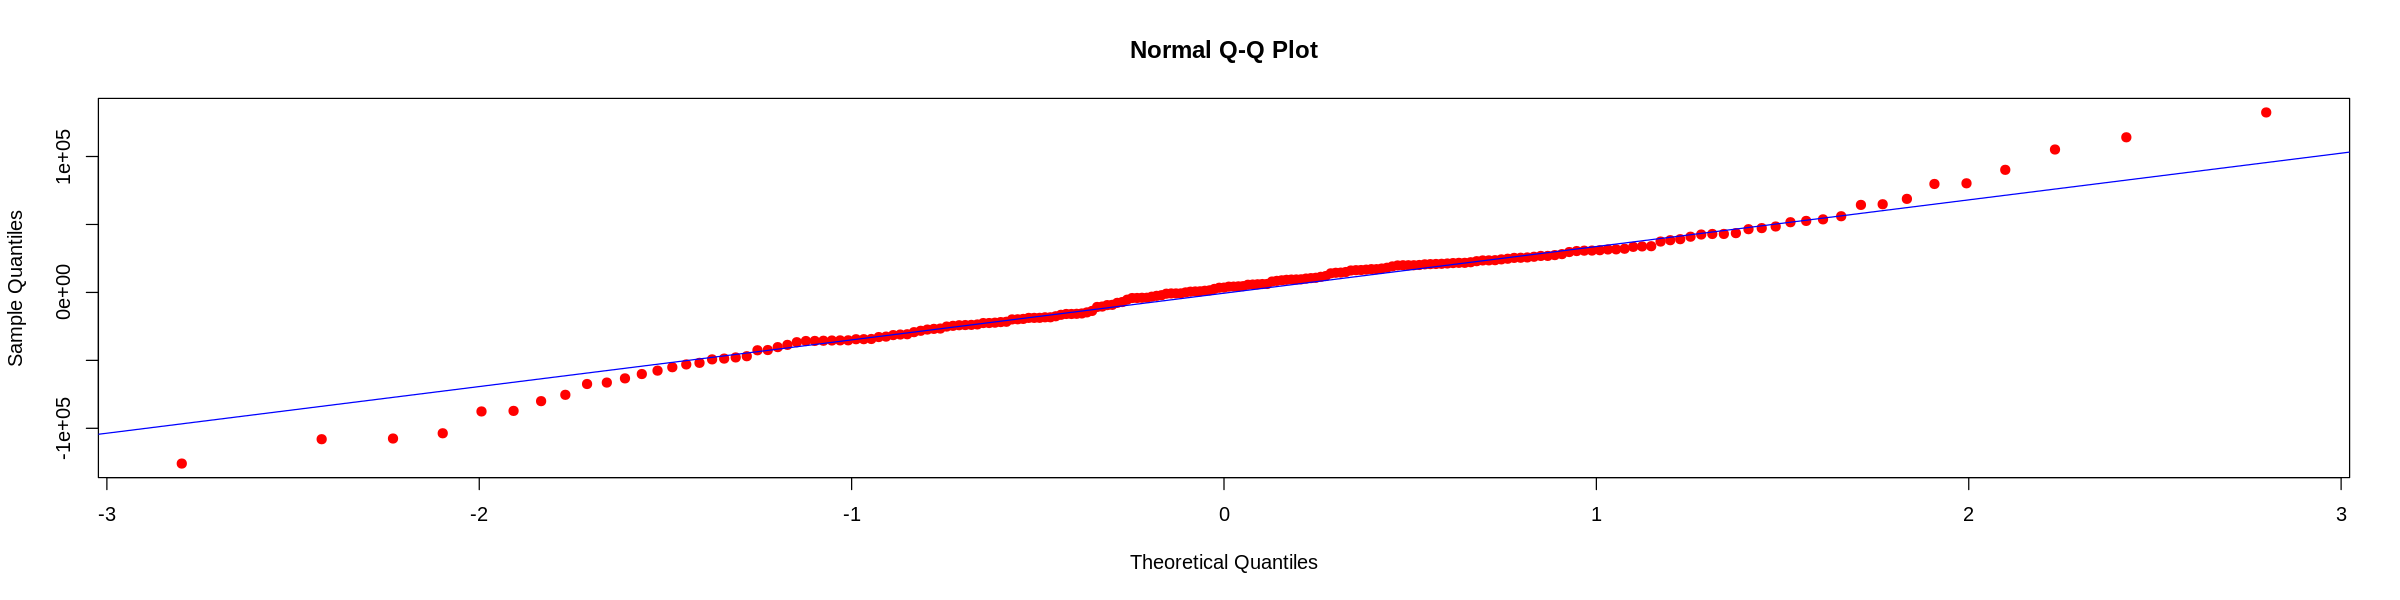

In [35]:
qqnorm(res3, col=2, pch = 19)
qqline(res3, col=4)

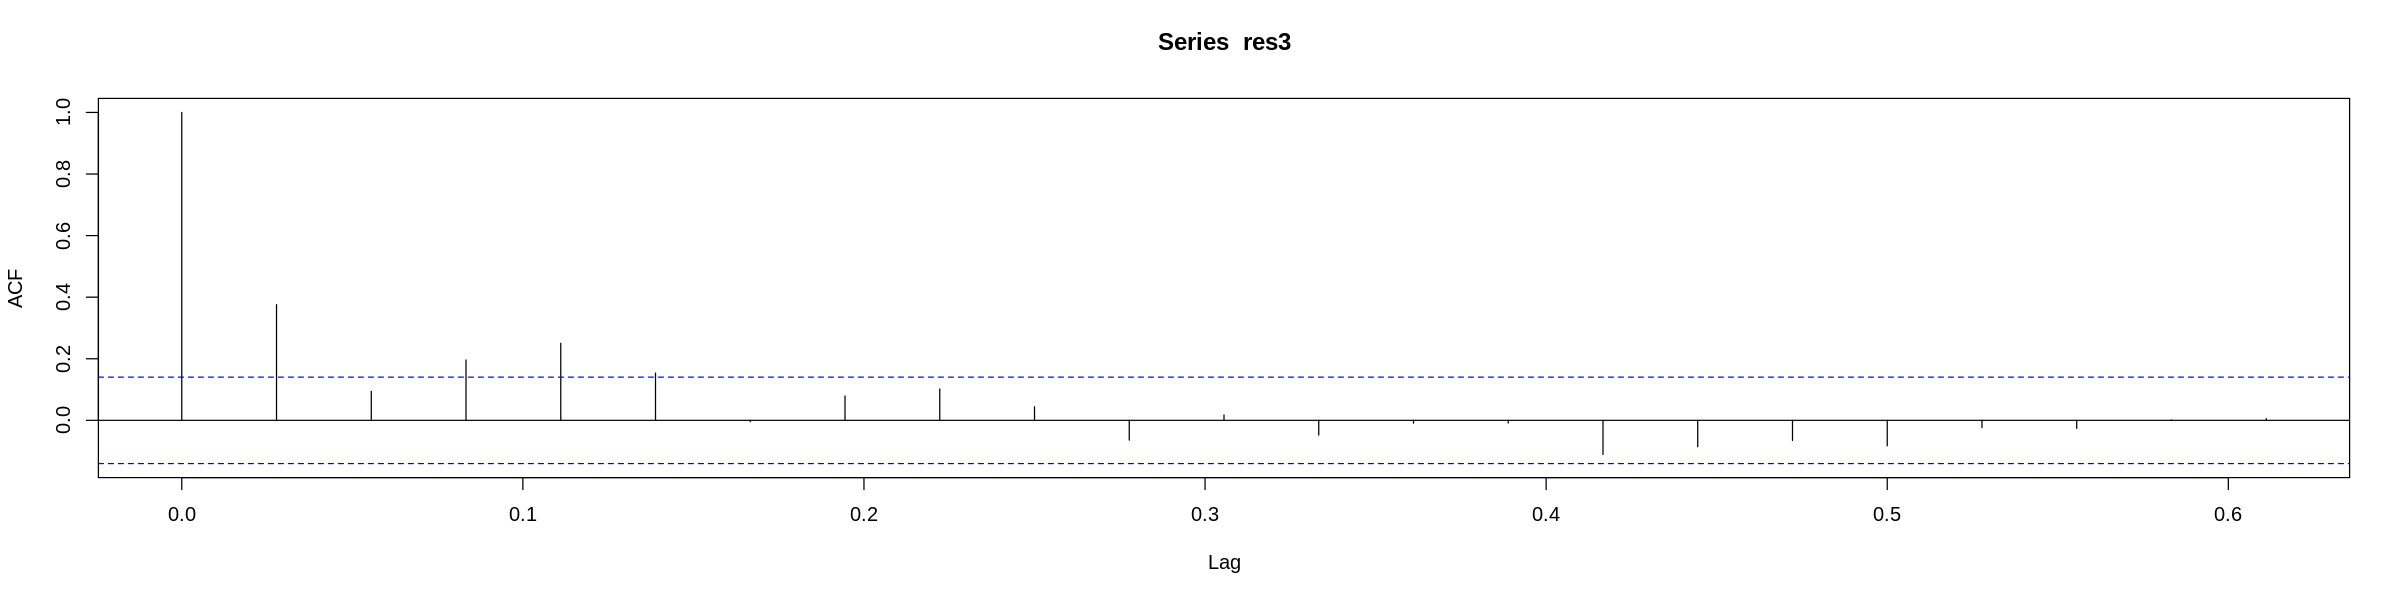

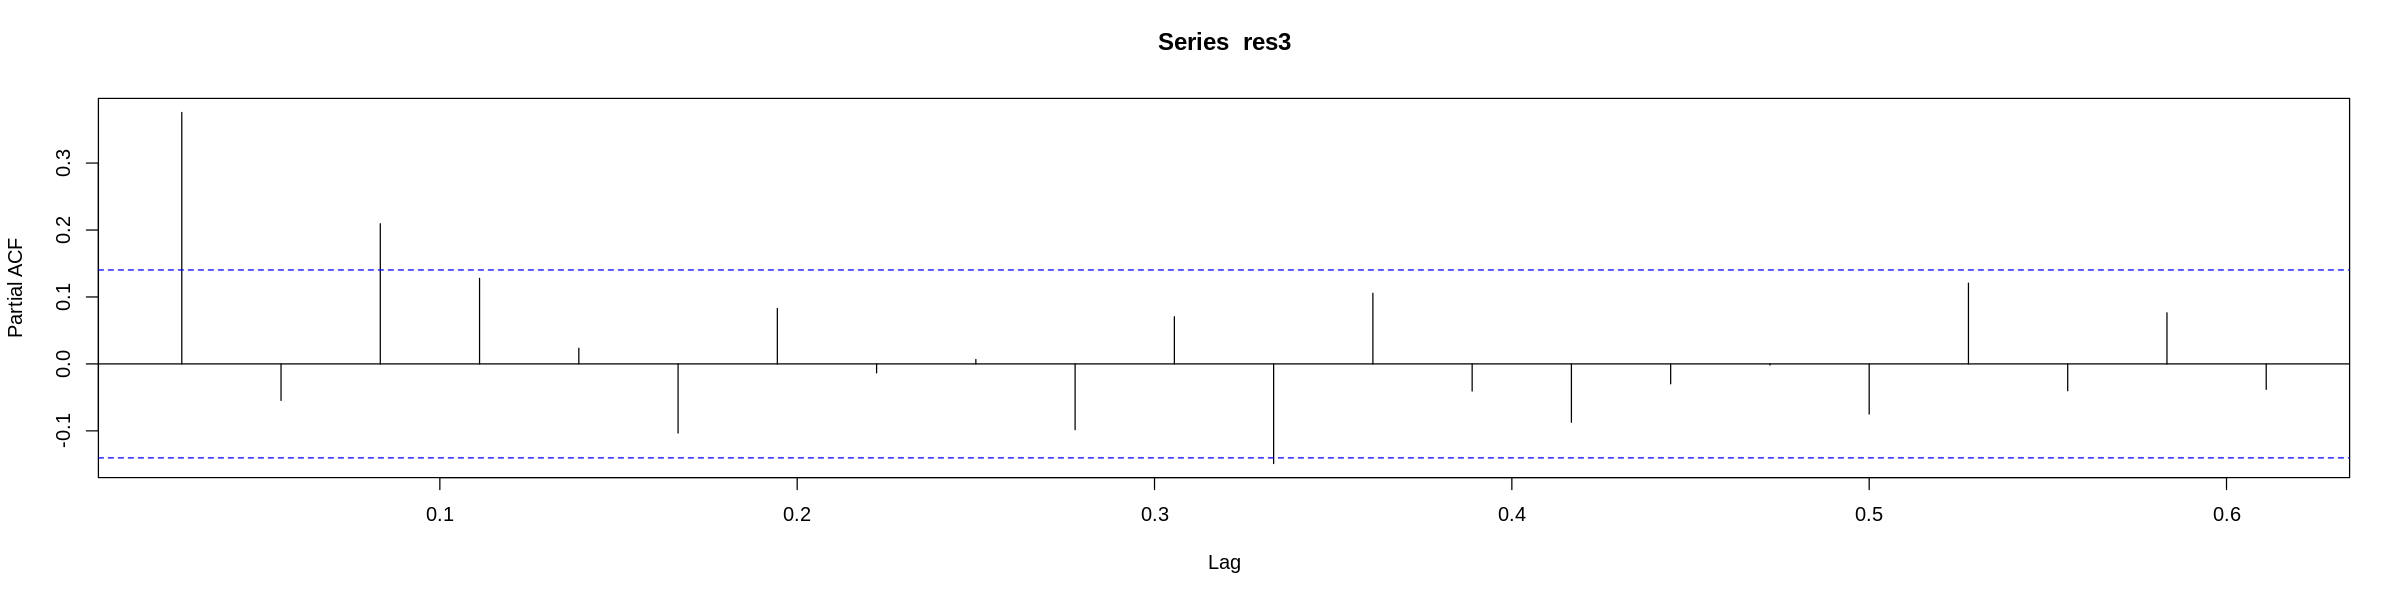

In [36]:
acf(res3)
pacf(res3)

Warning message in modeldf.default(object):
“Could not find appropriate degrees of freedom for this model.”


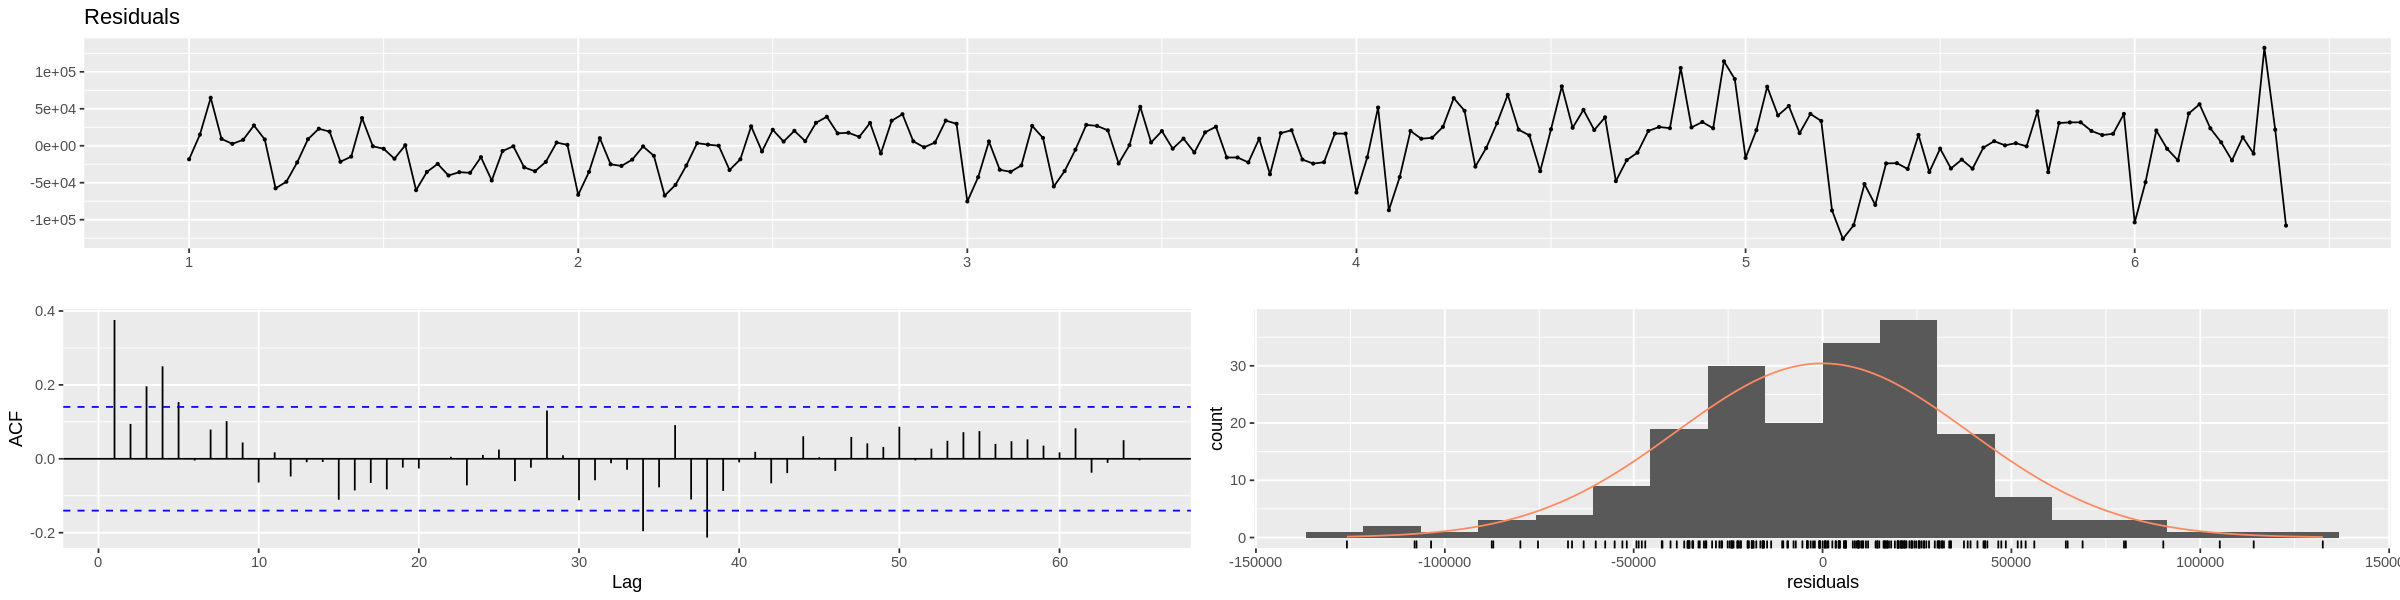

In [37]:
checkresiduals(res3)


##### Autorregresivo: valor actual depende de una combinaciòn de valores anteriores mas ruido(o innovaciòn)
ACF: decrece exponencialmente

PACF: inidca el orden de AR

Luego de tener el orden, hago LM para obtener el valor de los coeficientes

---------------------------------------------------------------
Analizando la acf y pacf de los residuos, podemos determinar que corresponde a una AR(1)


In [38]:
#Ajusto ARMA(1,0) con ARIMA
fit_Arima10 = Arima(res3,order=c(1,0,0),include.mean = FALSE)
summary(fit_Arima10)

Series: res3 
ARIMA(1,0,0) with zero mean 

Coefficients:
         ar1
      0.3896
s.e.  0.0673

sigma^2 estimated as 1.288e+09:  log likelihood=-2321.48
AIC=4646.95   AICc=4647.01   BIC=4653.5

Training set error measures:
                    ME    RMSE      MAE      MPE     MAPE      MASE       ACF1
Training set -208.3467 35797.8 25888.26 69.94398 143.4927 0.6648475 0.02724675


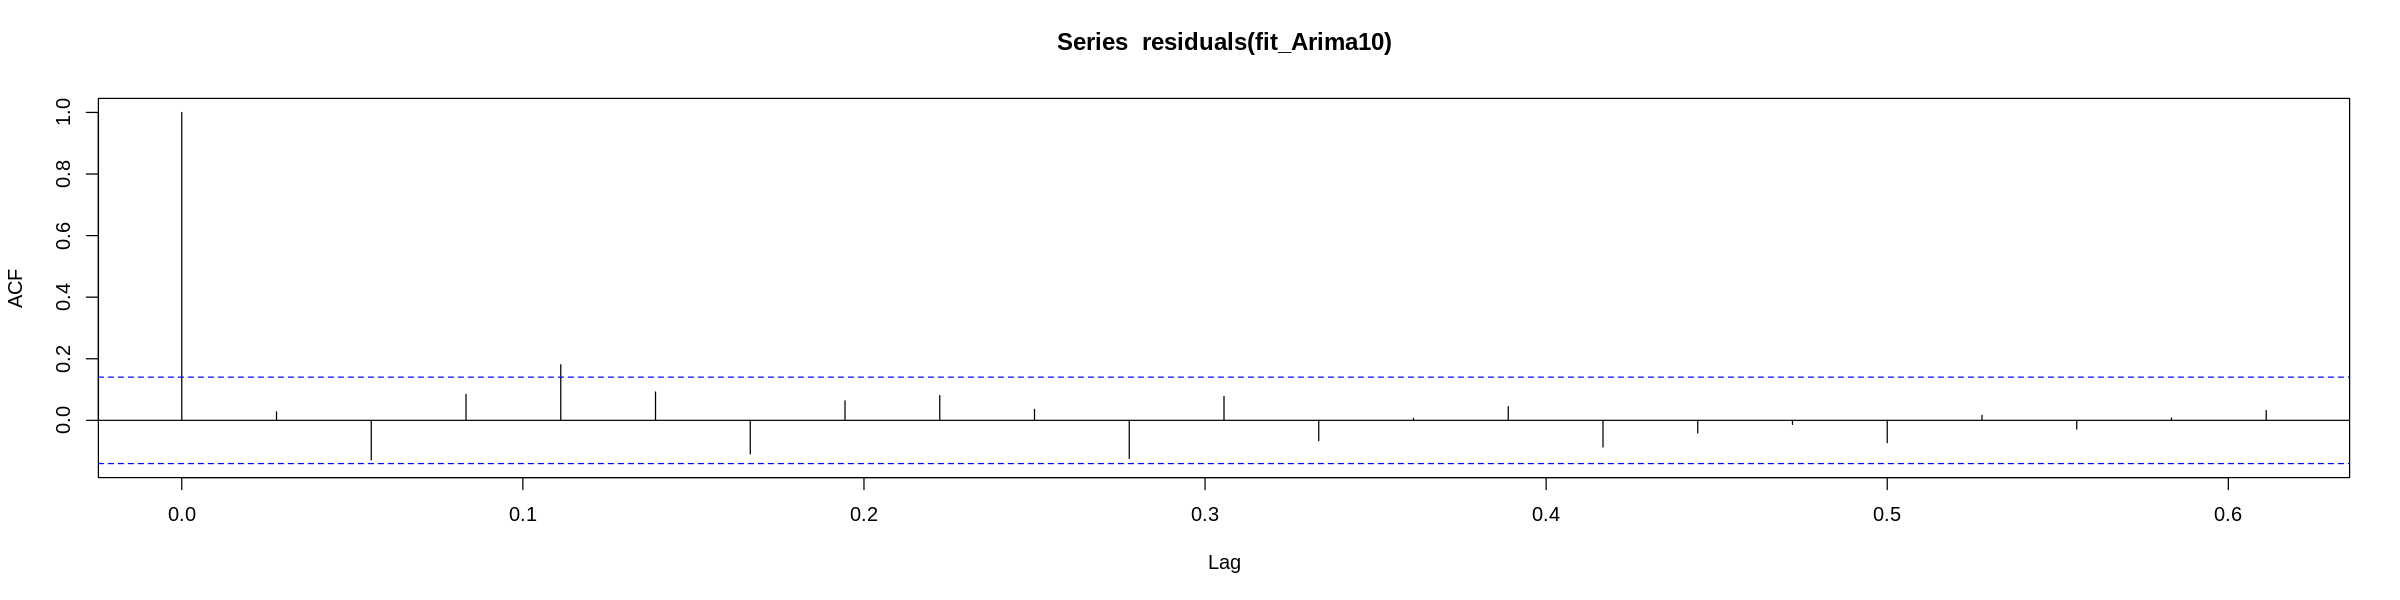

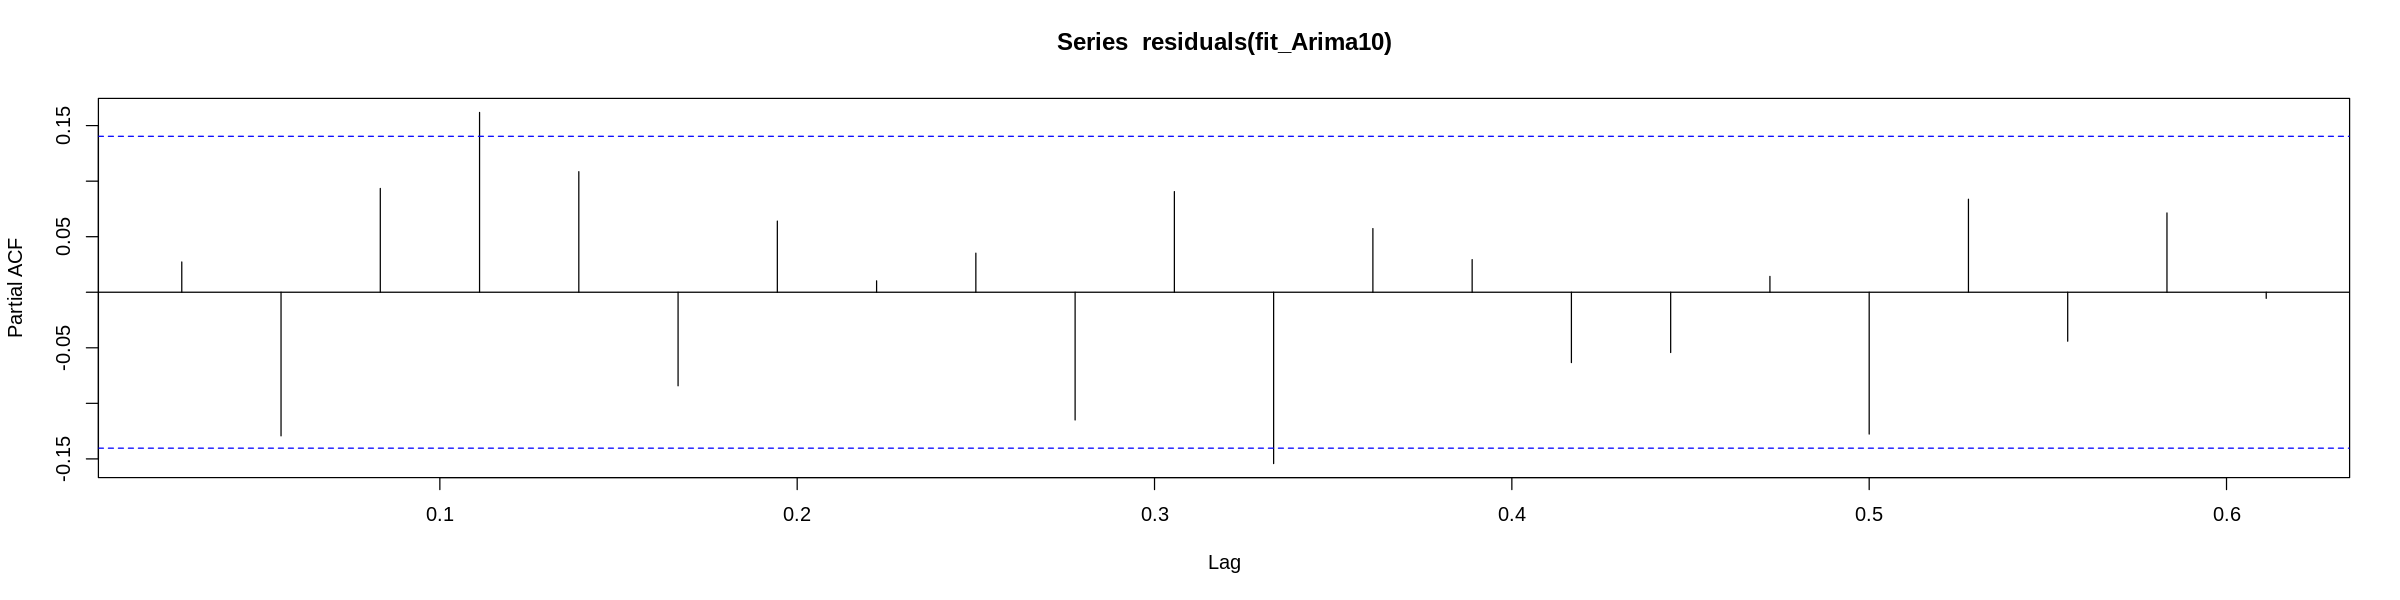

In [39]:
acf(residuals(fit_Arima10))
pacf(residuals(fit_Arima10))

---------------------

Creemos que es un buen ajuste, ya que al analizar los residuos del ajuste vemos que son similares a ruido blanco. 

De todas formas probaremos con mas ajustes para quedarnos con el mejor cosiderando los coeficientes y los valores de AIC y BIC 

---------------------


In [40]:
#Ajusto ARMA(1,1) con ARIMA

fit_Arima11 = Arima(res3,order=c(1,0,1),include.mean = FALSE)
summary(fit_Arima11)

Series: res3 
ARIMA(1,0,1) with zero mean 

Coefficients:
         ar1     ma1
      0.0948  0.3425
s.e.  0.1901  0.1806

sigma^2 estimated as 1.279e+09:  log likelihood=-2320.29
AIC=4646.58   AICc=4646.7   BIC=4656.39

Training set error measures:
                    ME     RMSE     MAE      MPE     MAPE      MASE
Training set -162.3918 35577.36 26029.6 114.3562 154.4409 0.6684775
                      ACF1
Training set -0.0005481594


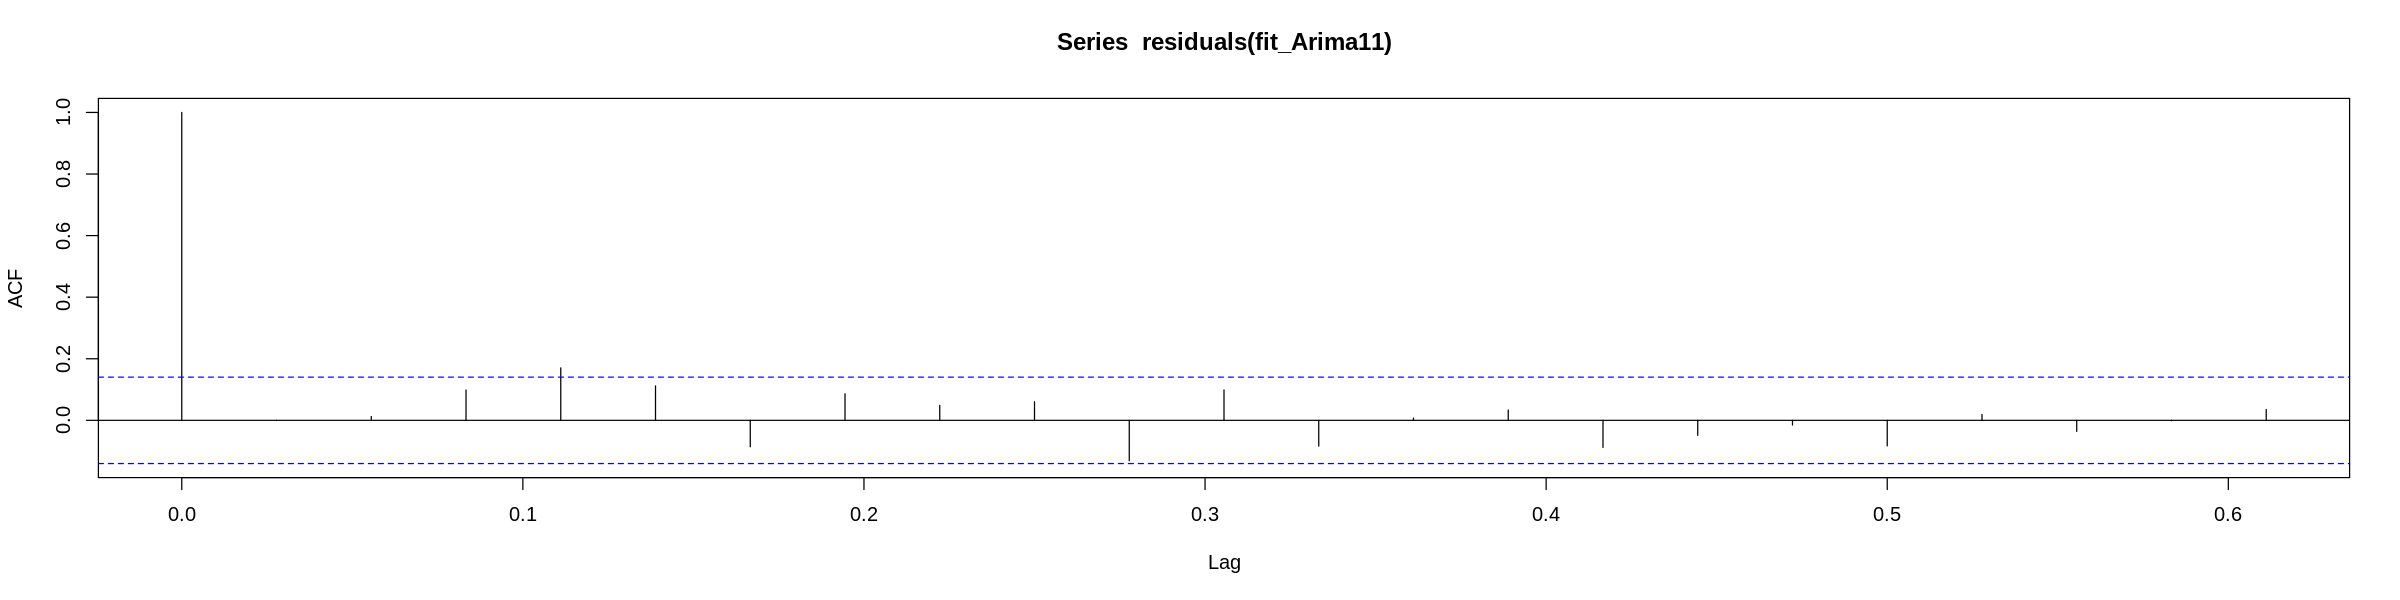

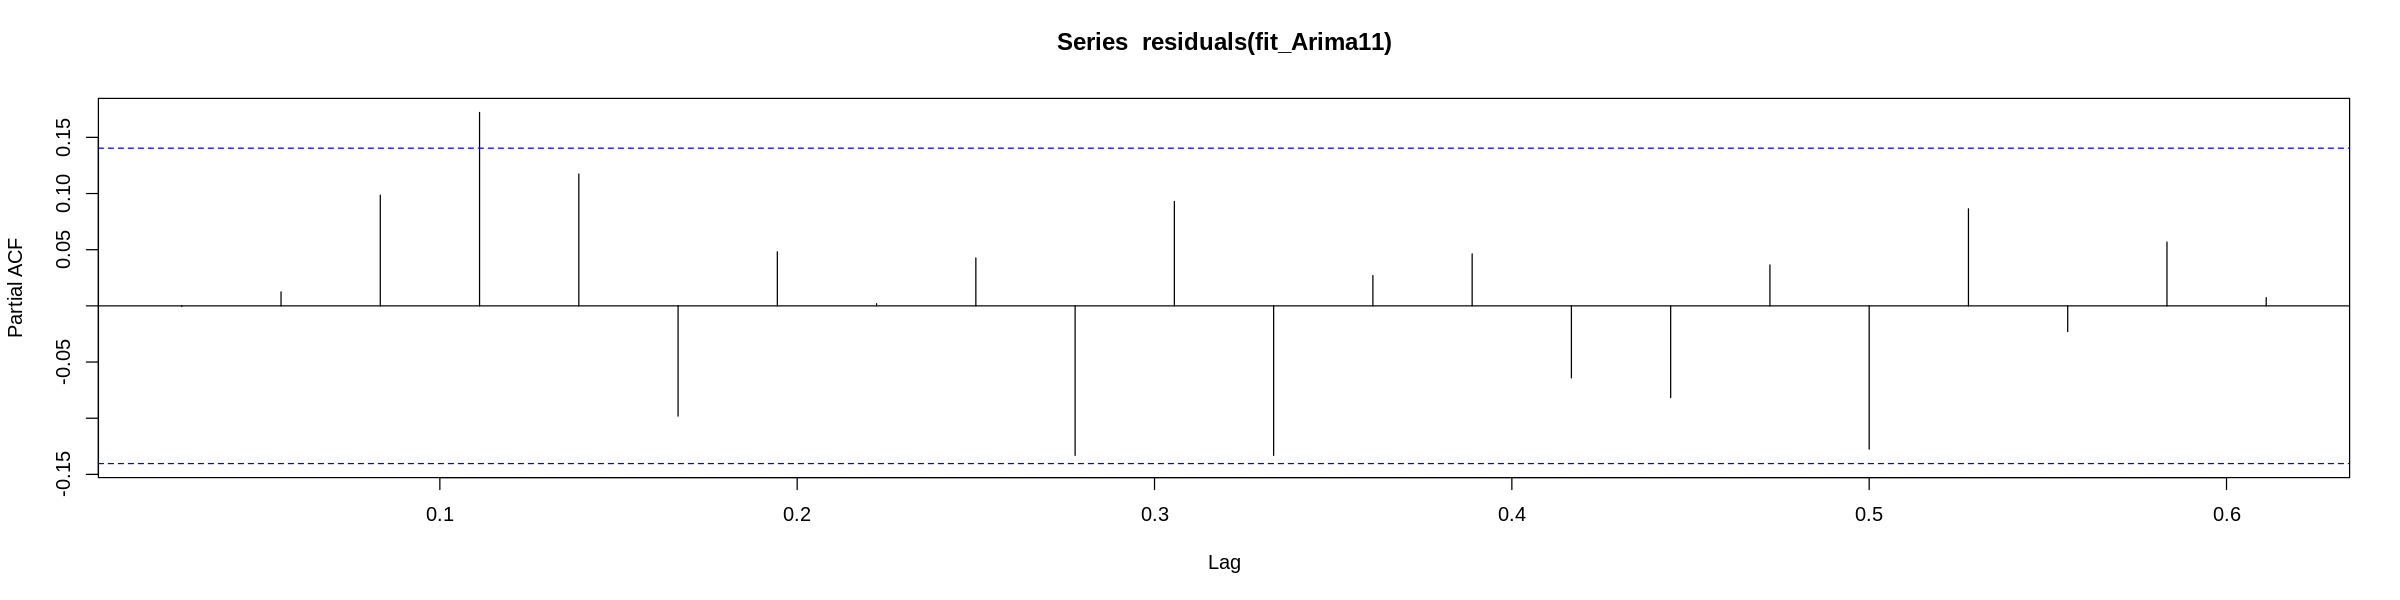

In [41]:
acf(residuals(fit_Arima11))
pacf(residuals(fit_Arima11))

---------------------

En ARMA(1,1) el coeficiente ar1 no es significativo, por lo tanto no lo consideramos

---------------------

In [42]:
#Ajusto ARMA(1,2) con ARIMA

fit_Arima12 = Arima(res3,order=c(1,0,2),include.mean = FALSE)
summary(fit_Arima12)

Series: res3 
ARIMA(1,0,2) with zero mean 

Coefficients:
         ar1      ma1      ma2
      0.8477  -0.4114  -0.2661
s.e.  0.1028   0.1275   0.0894

sigma^2 estimated as 1.261e+09:  log likelihood=-2318.39
AIC=4644.79   AICc=4645   BIC=4657.88

Training set error measures:
                    ME    RMSE      MAE     MPE     MAPE      MASE        ACF1
Training set -144.9054 35229.7 25447.25 236.559 283.9102 0.6535218 -0.02289966


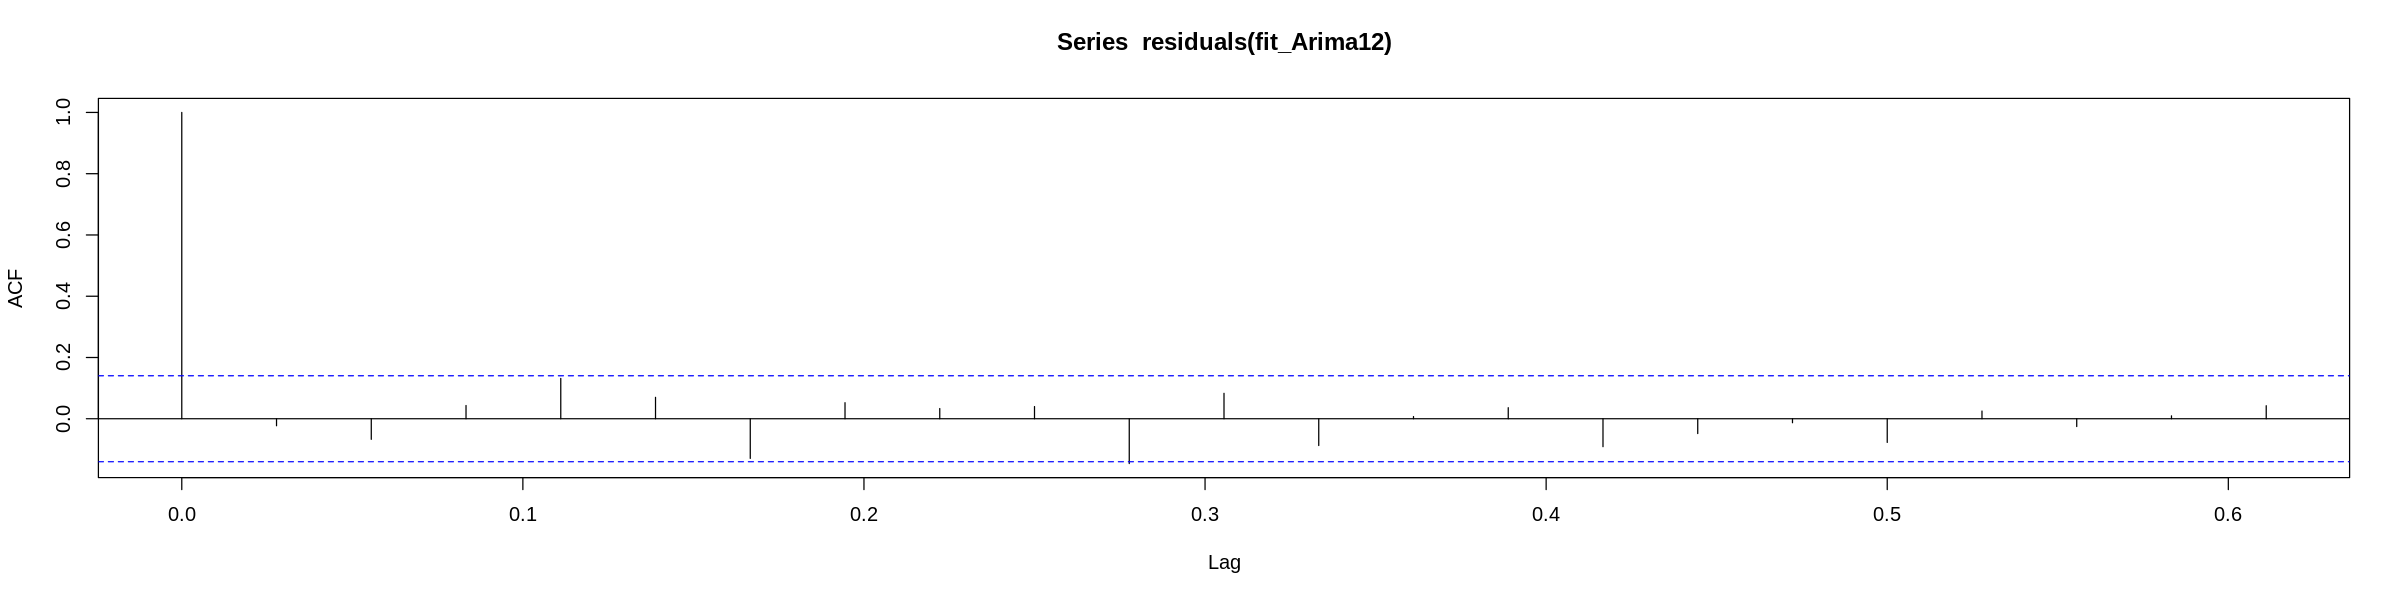

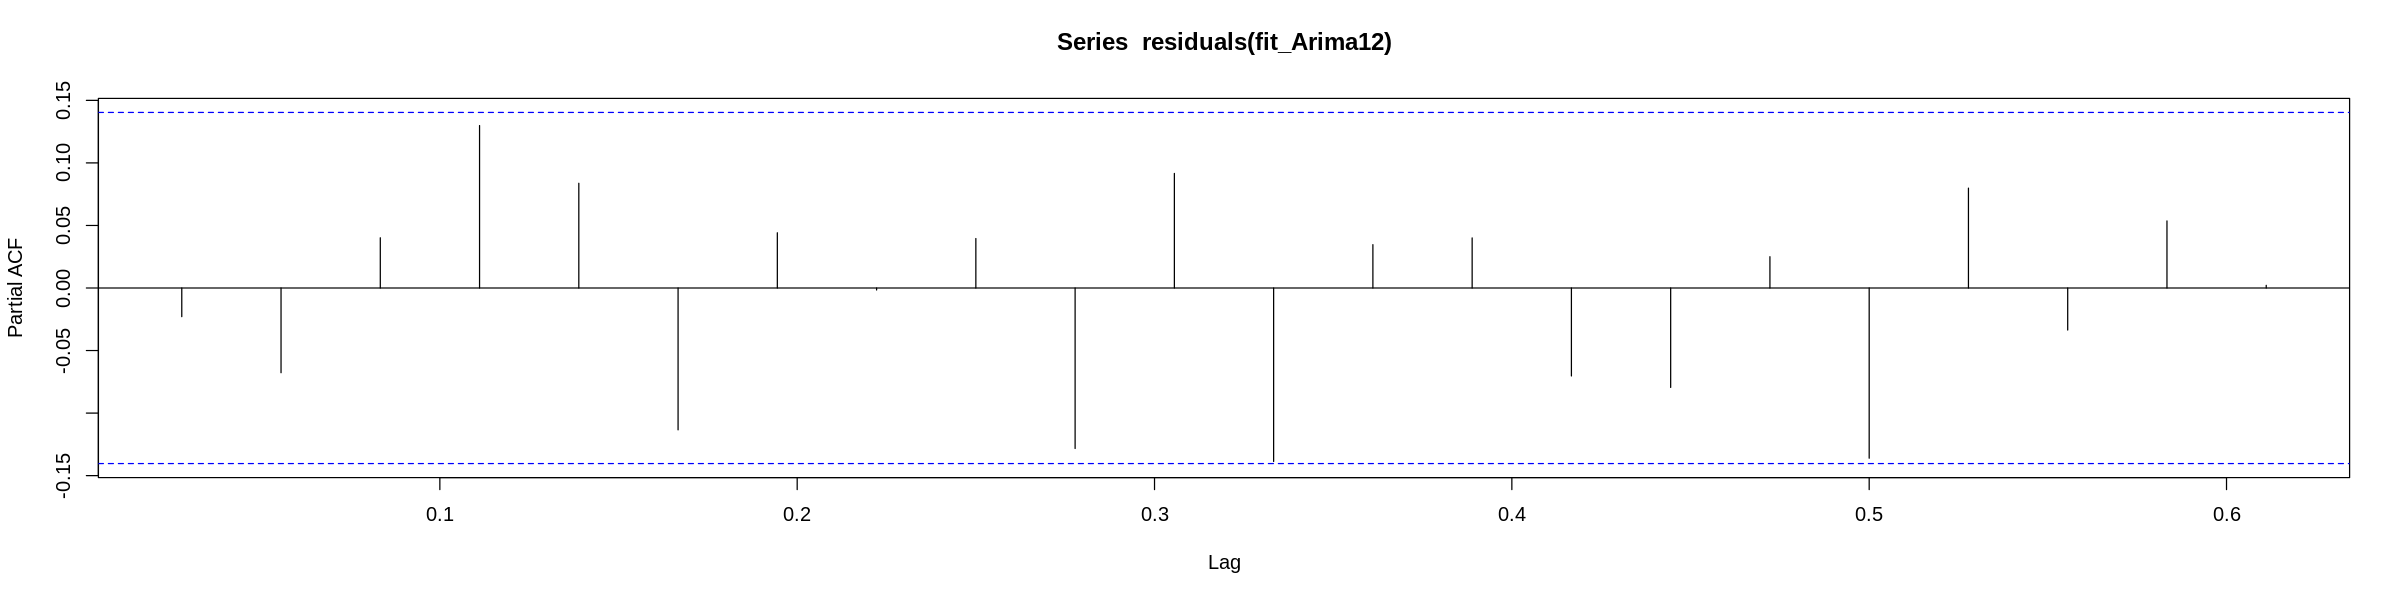

In [43]:
acf(residuals(fit_Arima12))
pacf(residuals(fit_Arima12))

Series: res3 
ARIMA(2,0,2) with zero mean 

Coefficients:
          ar1     ar2     ma1      ma2
      -0.0132  0.6268  0.4201  -0.5798
s.e.   0.1428  0.0962  0.1732   0.1710

sigma^2 estimated as 1.201e+09:  log likelihood=-2314.66
AIC=4639.32   AICc=4639.64   BIC=4655.69

Training set error measures:
                    ME     RMSE      MAE      MPE     MAPE      MASE       ACF1
Training set -129.7876 34291.49 25203.52 295.5185 406.0384 0.6472625 0.04228971


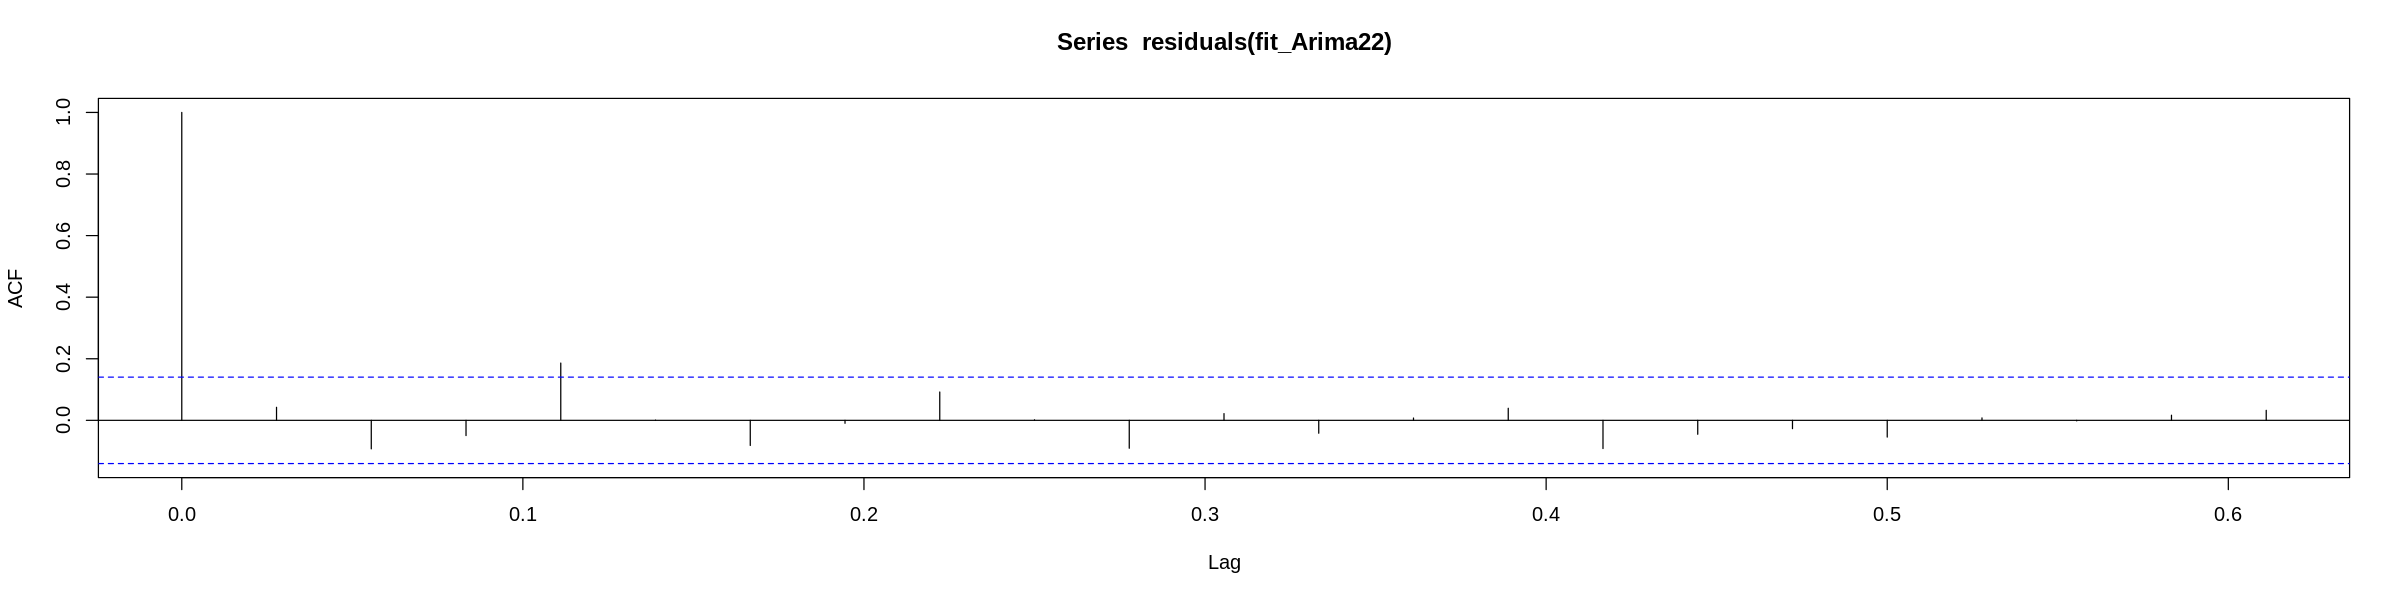

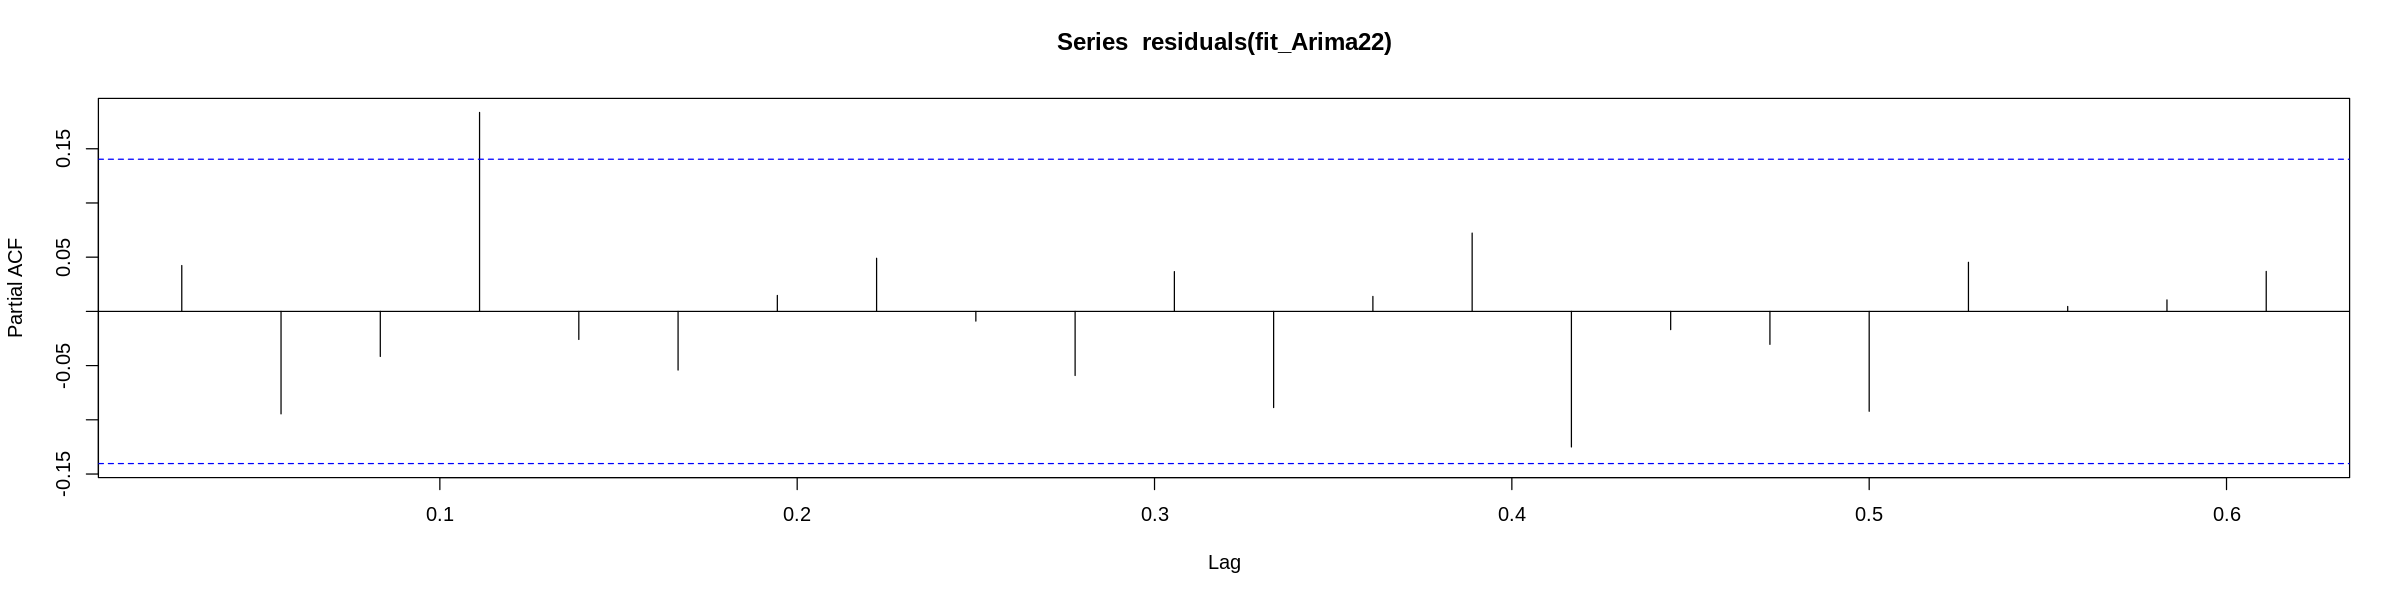

In [44]:
#Ajusto ARMA(2,2) con ARIMA

fit_Arima22 = Arima(res3,order=c(2,0,2),include.mean = FALSE)
summary(fit_Arima22)
acf(residuals(fit_Arima22))
pacf(residuals(fit_Arima22))

---------------------

En ARMA(2,2) el coeficiente ar1 no es significativo, por lo tanto no lo consideramos

---------------------

In [45]:
#Ajusto ARMA(0,1) con ARIMA

fit_Arima01 = Arima(res3,order=c(0,0,1),include.mean = FALSE)
summary(fit_Arima01)

Series: res3 
ARIMA(0,0,1) with zero mean 

Coefficients:
         ma1
      0.4231
s.e.  0.0646

sigma^2 estimated as 1.274e+09:  log likelihood=-2320.41
AIC=4644.82   AICc=4644.88   BIC=4651.36

Training set error measures:
                    ME     RMSE   MAE      MPE     MAPE      MASE       ACF1
Training set -138.0375 35599.63 26110 130.1956 167.4186 0.6705421 0.01465786


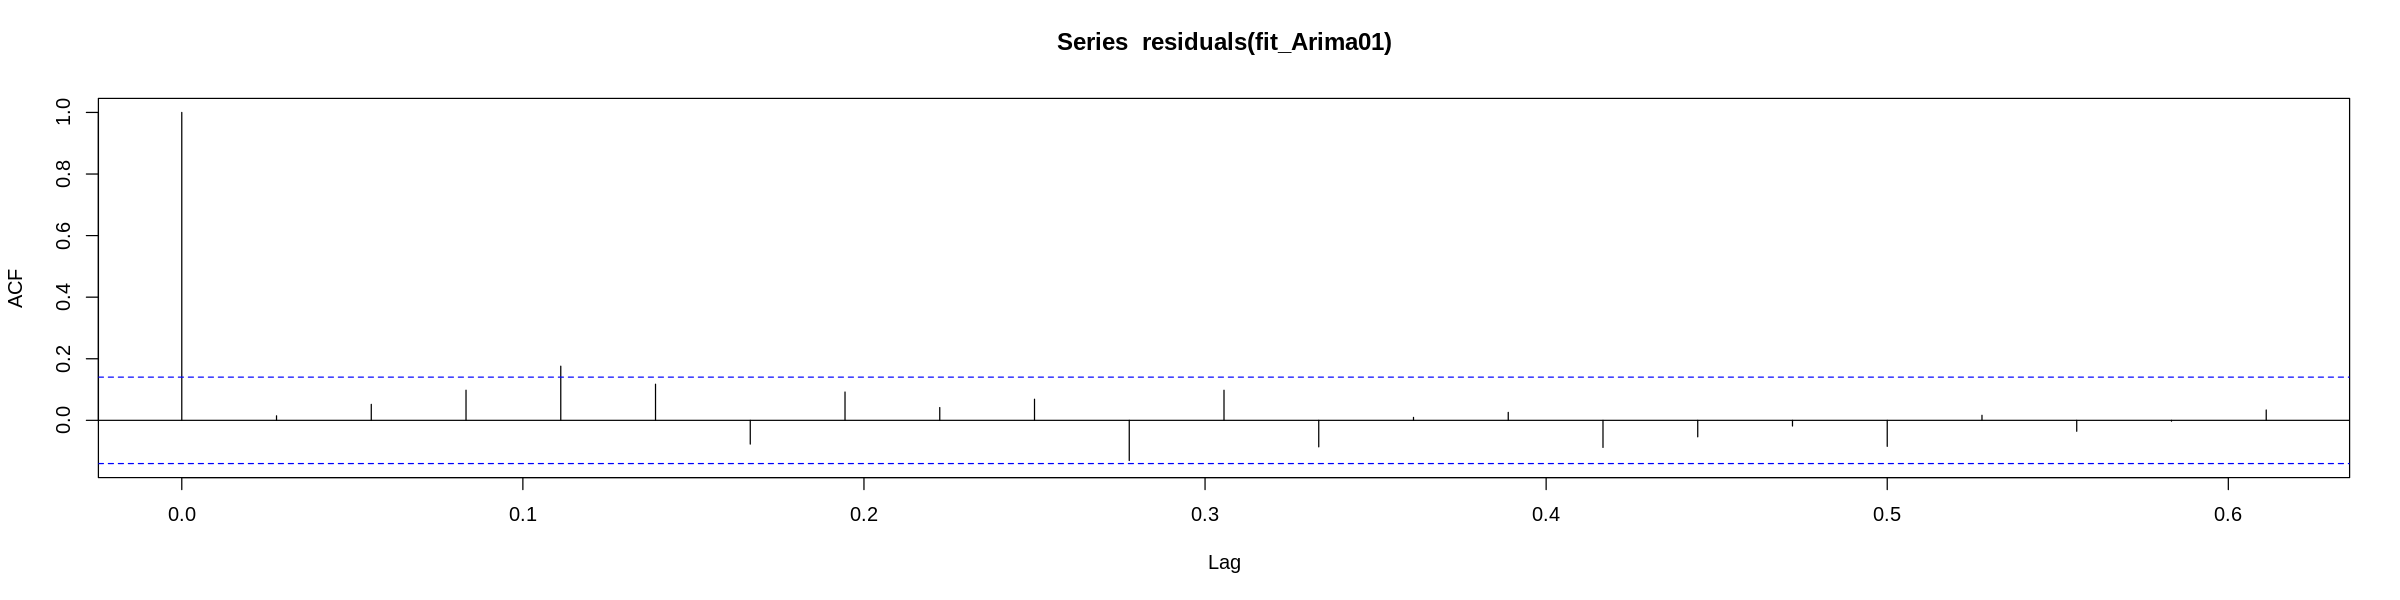

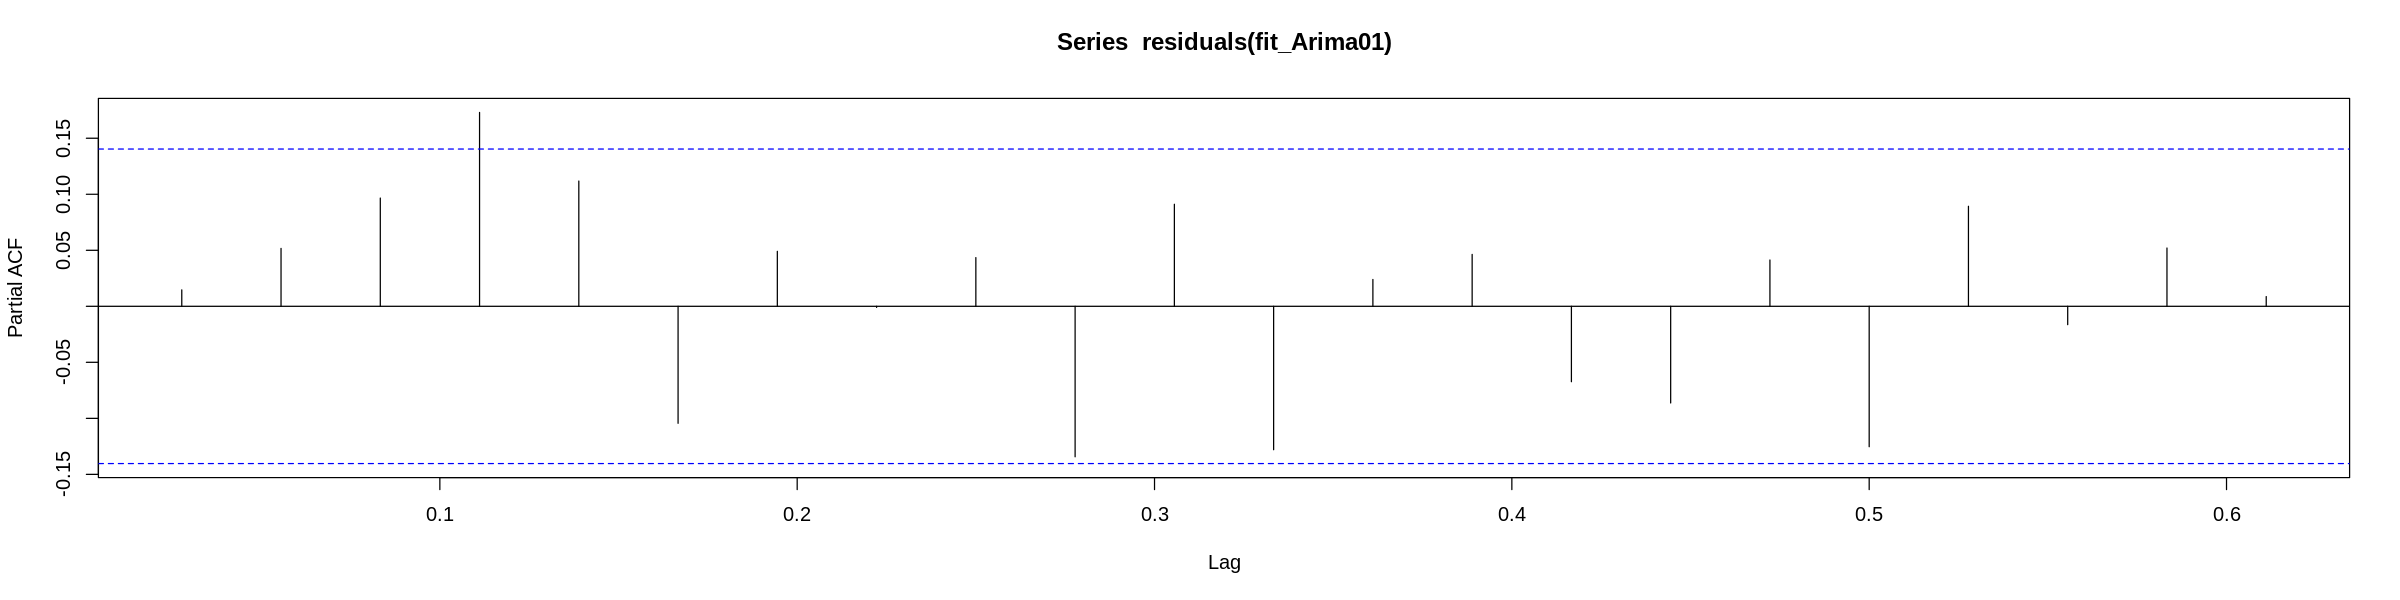

In [46]:
acf(residuals(fit_Arima01))
pacf(residuals(fit_Arima01))

###### Hacemos analisis para los ajustes elegidos (ARMA(1,0), ARMA(1,2) y ARMA(0,1))

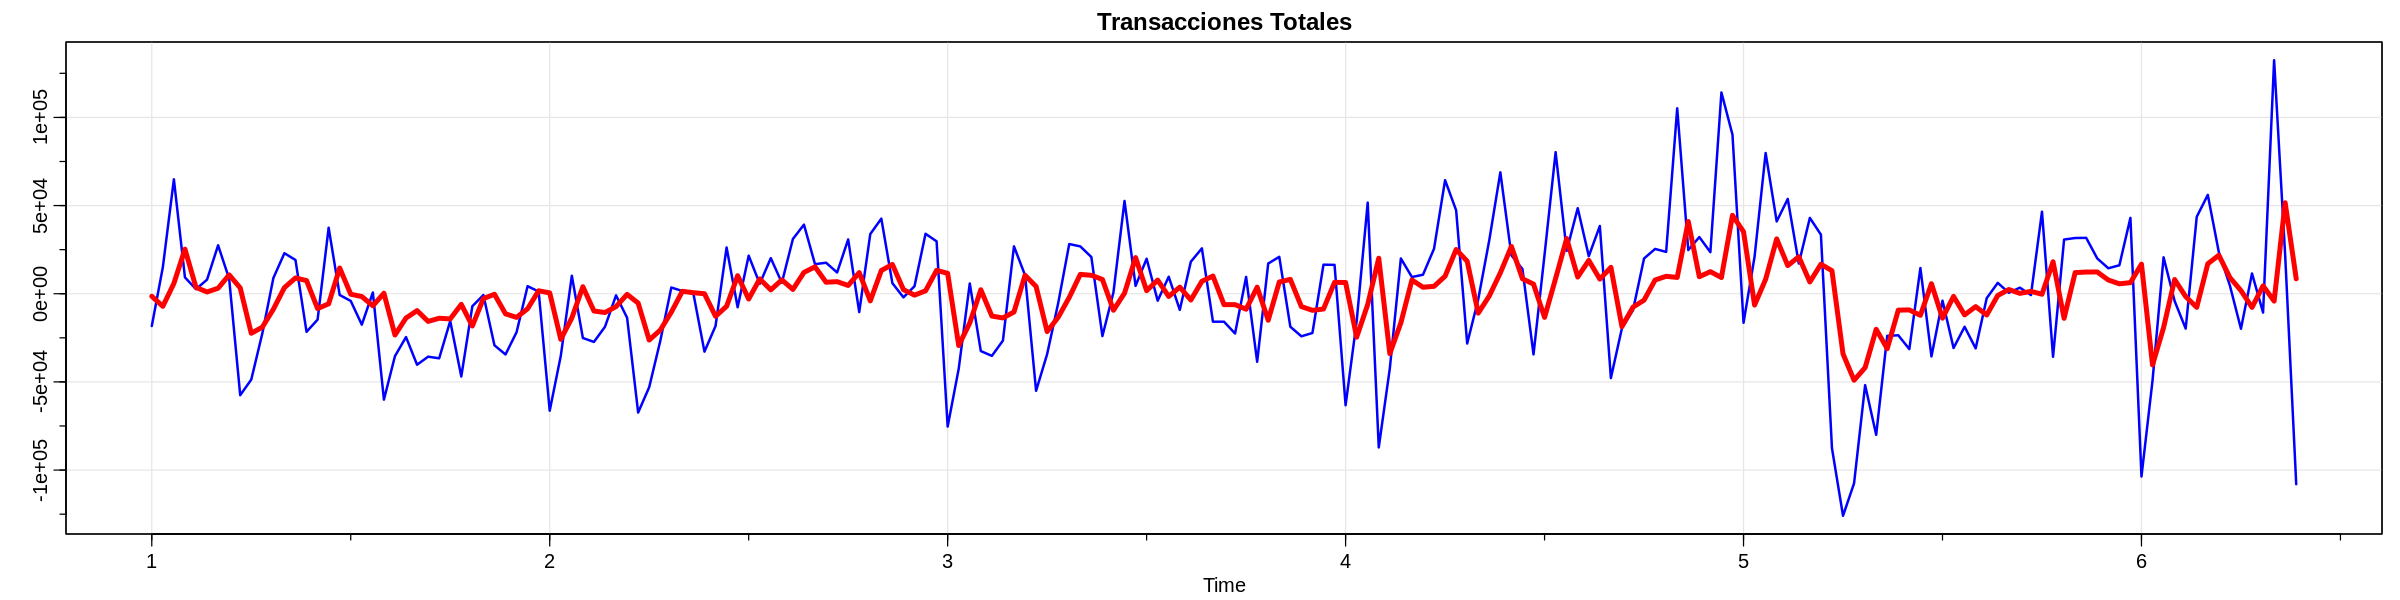

In [47]:
prediction_Arima10 = ts(fitted(fit_Arima10), frequency = 36)
tsplot(res3, main="Transacciones Totales", ylab="", lwd=2, col=4)
lines(prediction_Arima10,col=2, lwd=4)

Warning message in modeldf.default(object):
“Could not find appropriate degrees of freedom for this model.”


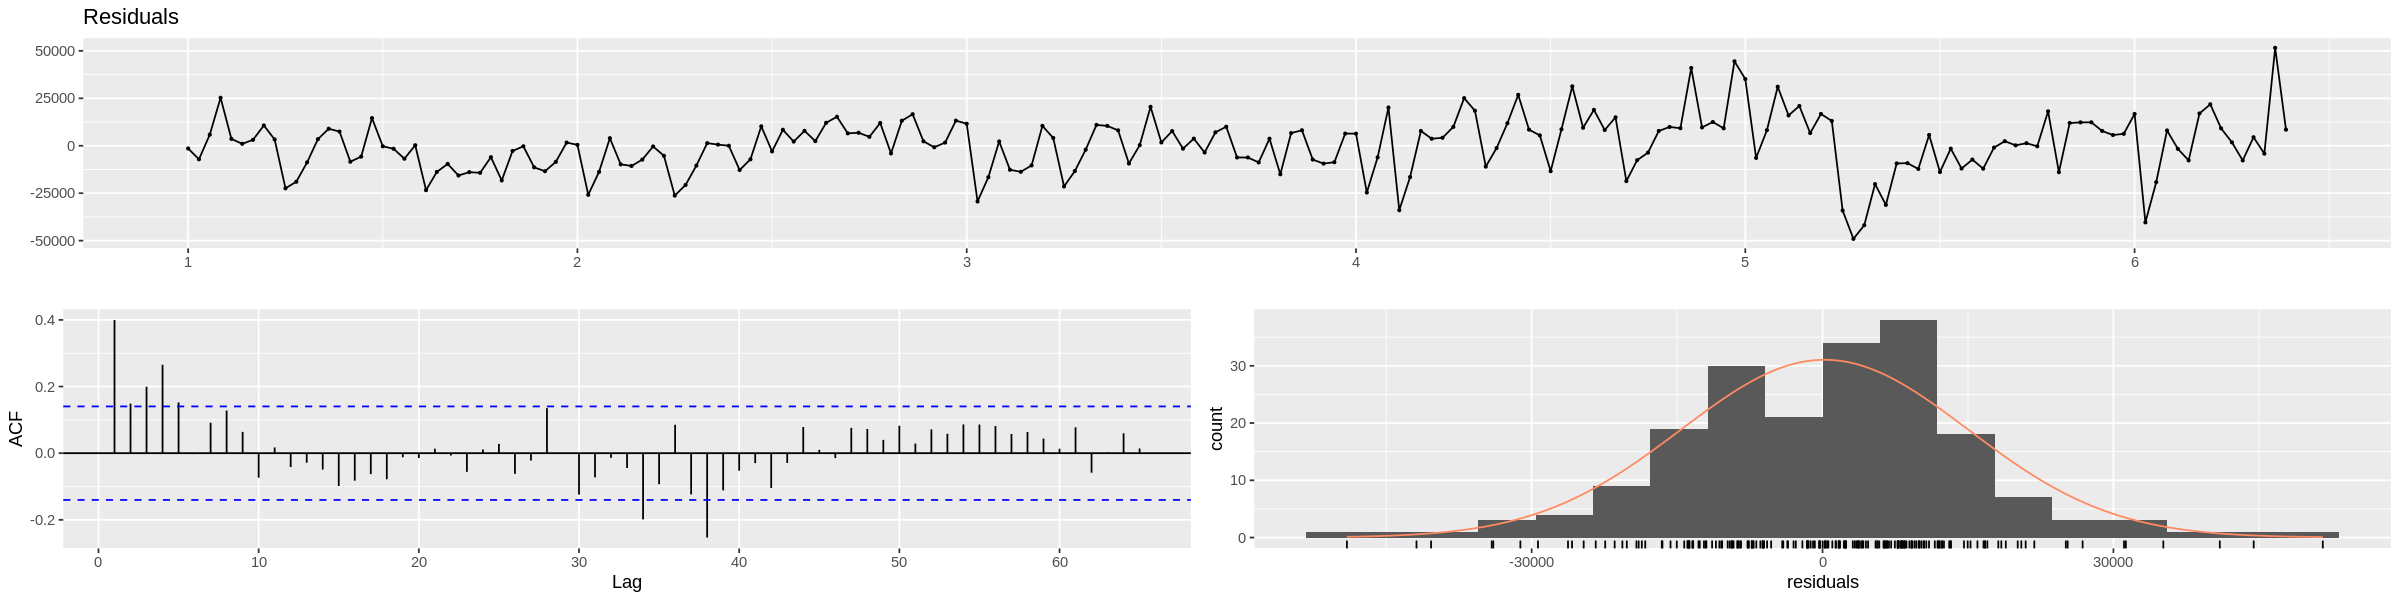

In [48]:
checkresiduals(prediction_Arima10)

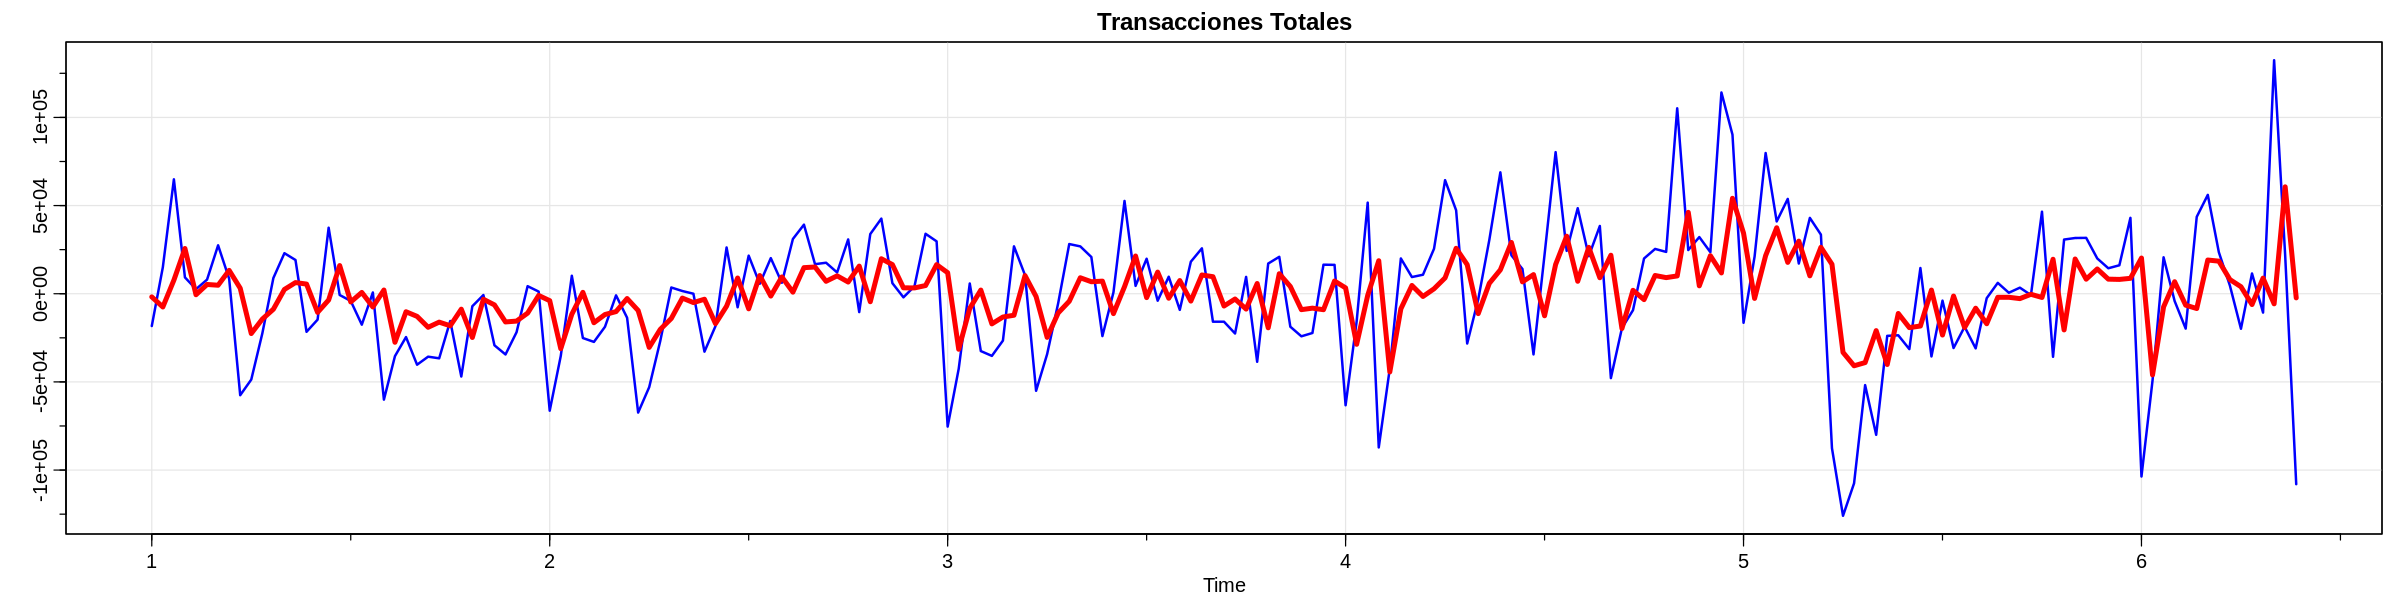

In [49]:
prediction_Arima12 = ts(fitted(fit_Arima12), frequency = 36)
tsplot(res3, main="Transacciones Totales", ylab="", lwd=2, col=4)
lines(prediction_Arima12,col=2, lwd=4)


	Ljung-Box test

data:  Residuals from ARIMA(1,0,2) with zero mean
Q* = 66.059, df = 36, p-value = 0.001647

Model df: 3.   Total lags used: 39



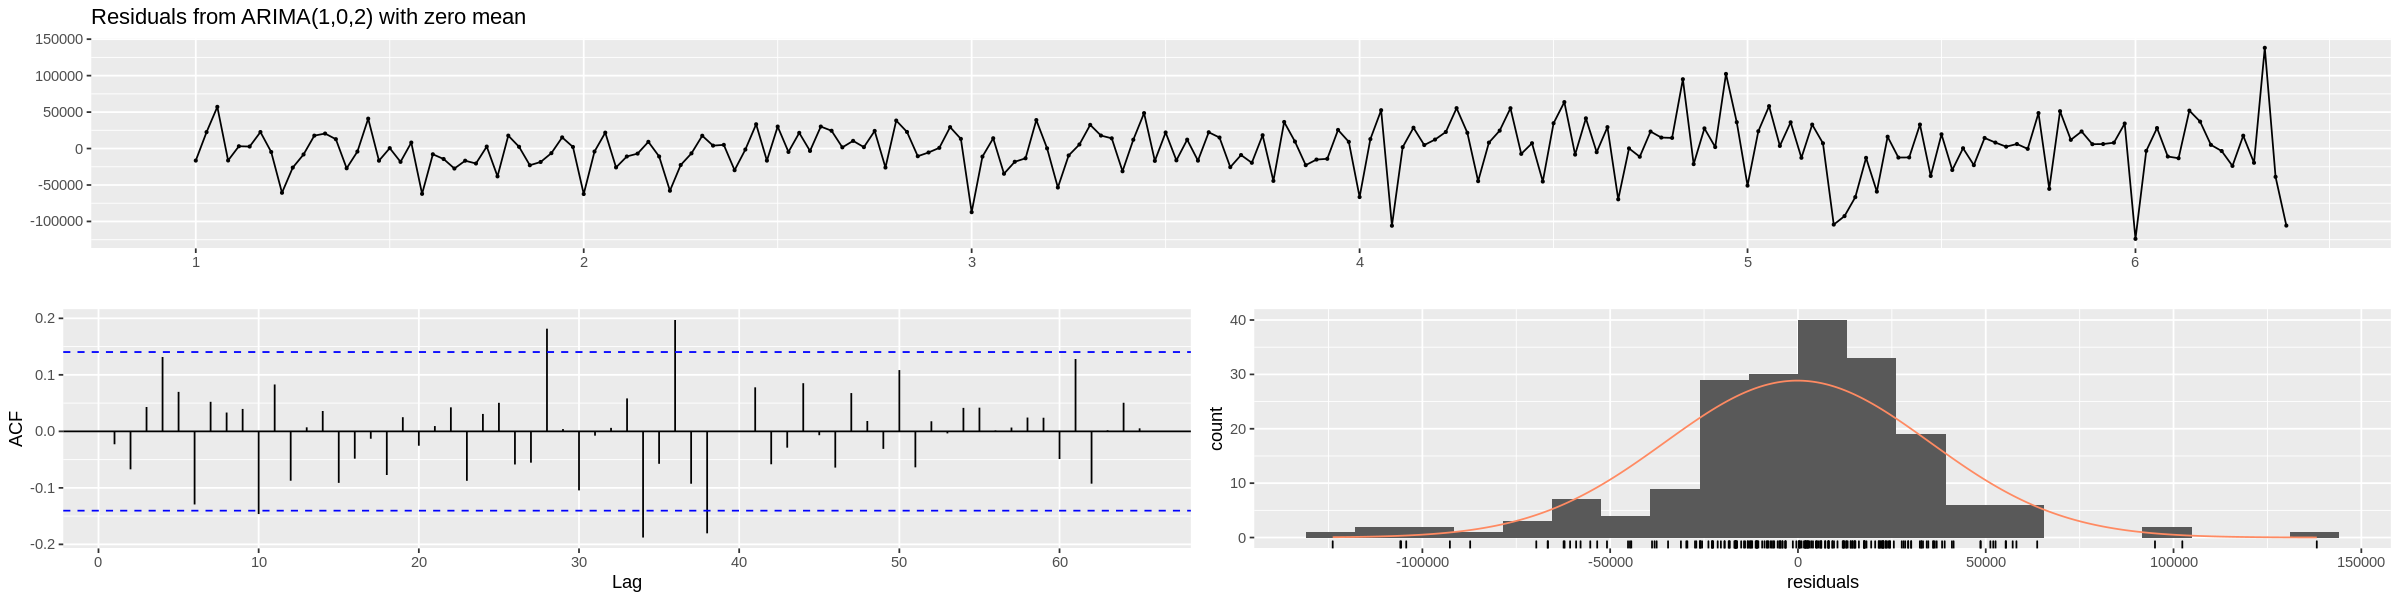

In [50]:
checkresiduals(fit_Arima12)


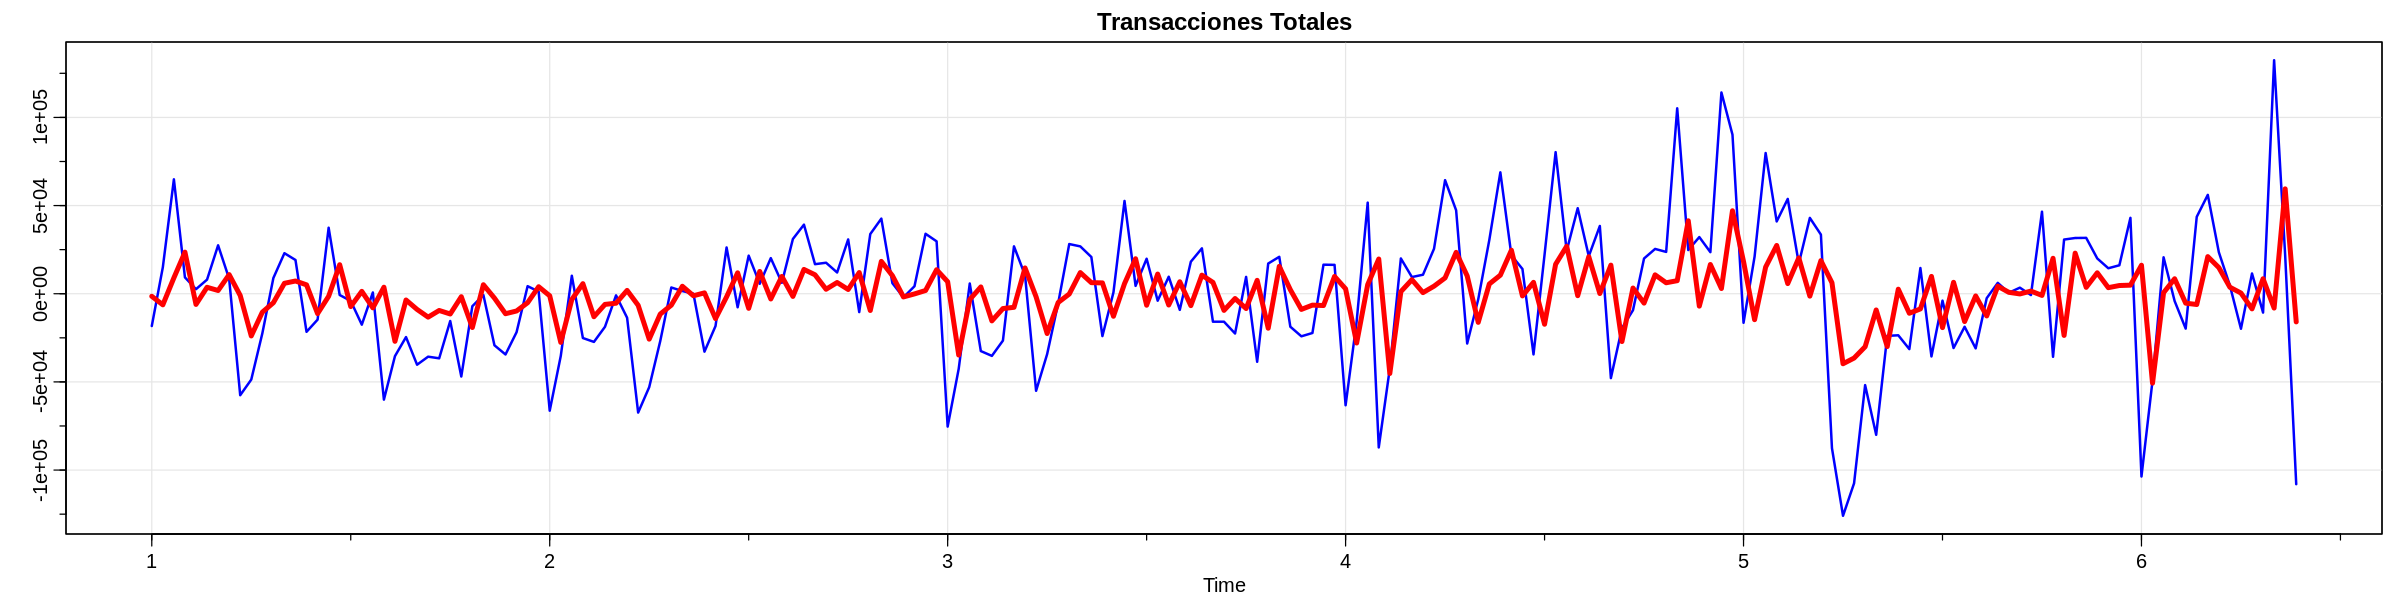

In [51]:
prediction_Arima01 = ts(fitted(fit_Arima01), frequency = 36)
tsplot(res3, main="Transacciones Totales", ylab="", lwd=2, col=4)
lines(prediction_Arima01,col=2, lwd=4)


	Ljung-Box test

data:  Residuals from ARIMA(0,0,1) with zero mean
Q* = 64.464, df = 38, p-value = 0.004677

Model df: 1.   Total lags used: 39



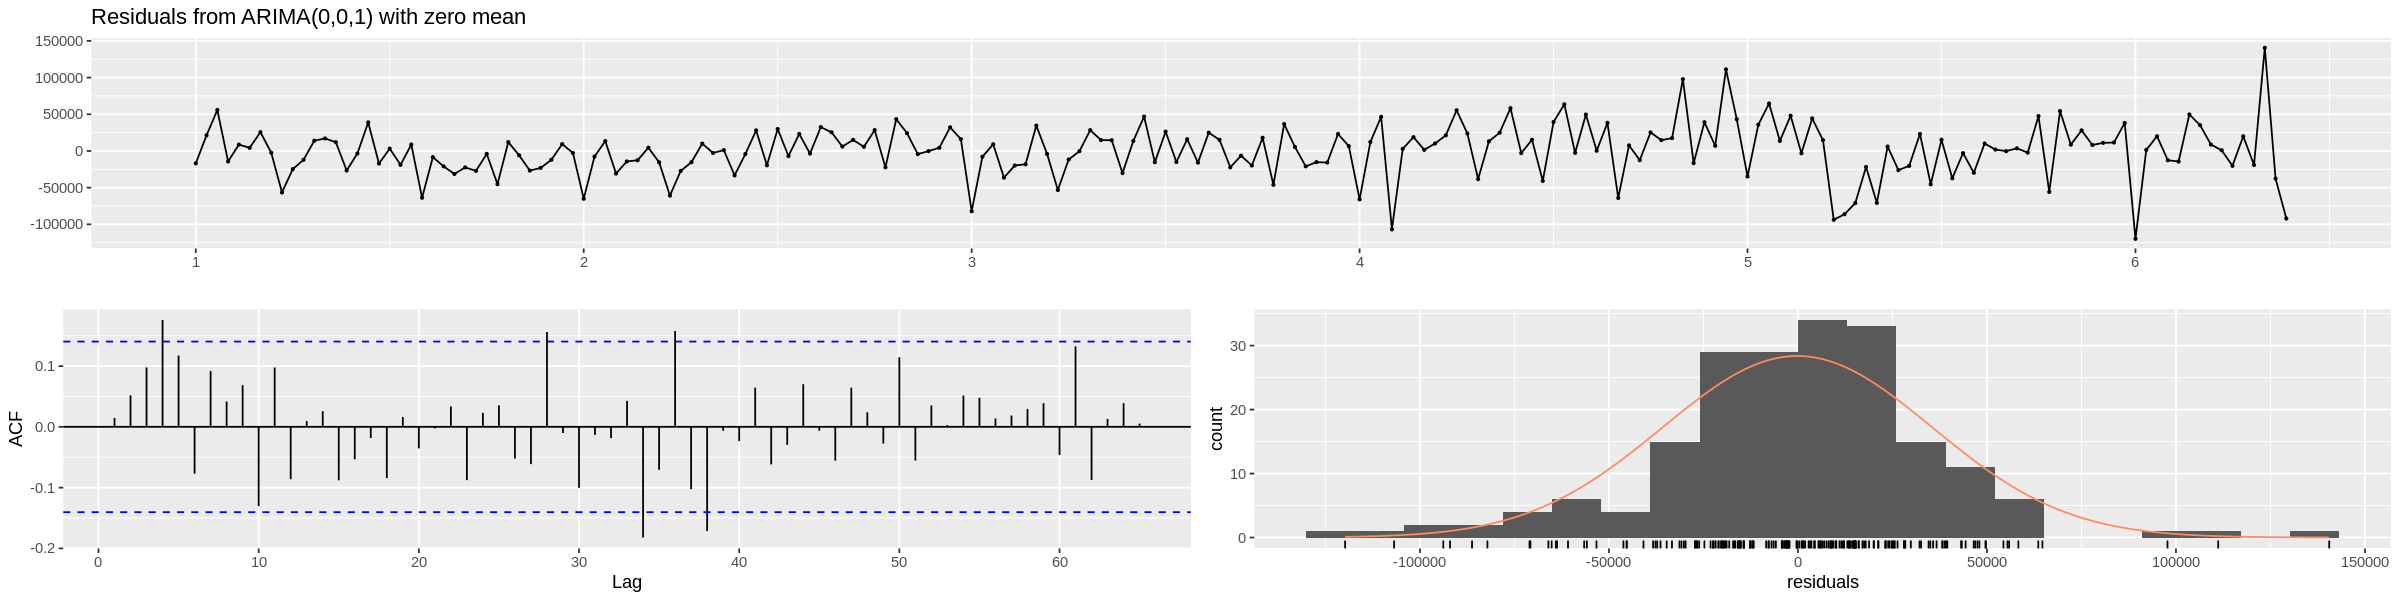

In [52]:
checkresiduals(fit_Arima01)

In [53]:
#Mostramos los resultados AIC, BIC obtenidos en una tabla.
Ajustes <- c('fit_Arima01','fit_Arima12','fit_Arima10')
AIC <- c(AIC(fit_Arima01), AIC(fit_Arima12),AIC(fit_Arima10))
BIC <- c(BIC(fit_Arima01), BIC(fit_Arima12), BIC(fit_Arima10))
Tabla <- data.frame(Ajustes, AIC, BIC)
Tabla

Ajustes     AIC      BIC     
1 fit_Arima01 4644.819 4651.365
2 fit_Arima12 4644.787 4657.879
3 fit_Arima10 4646.951 4653.497

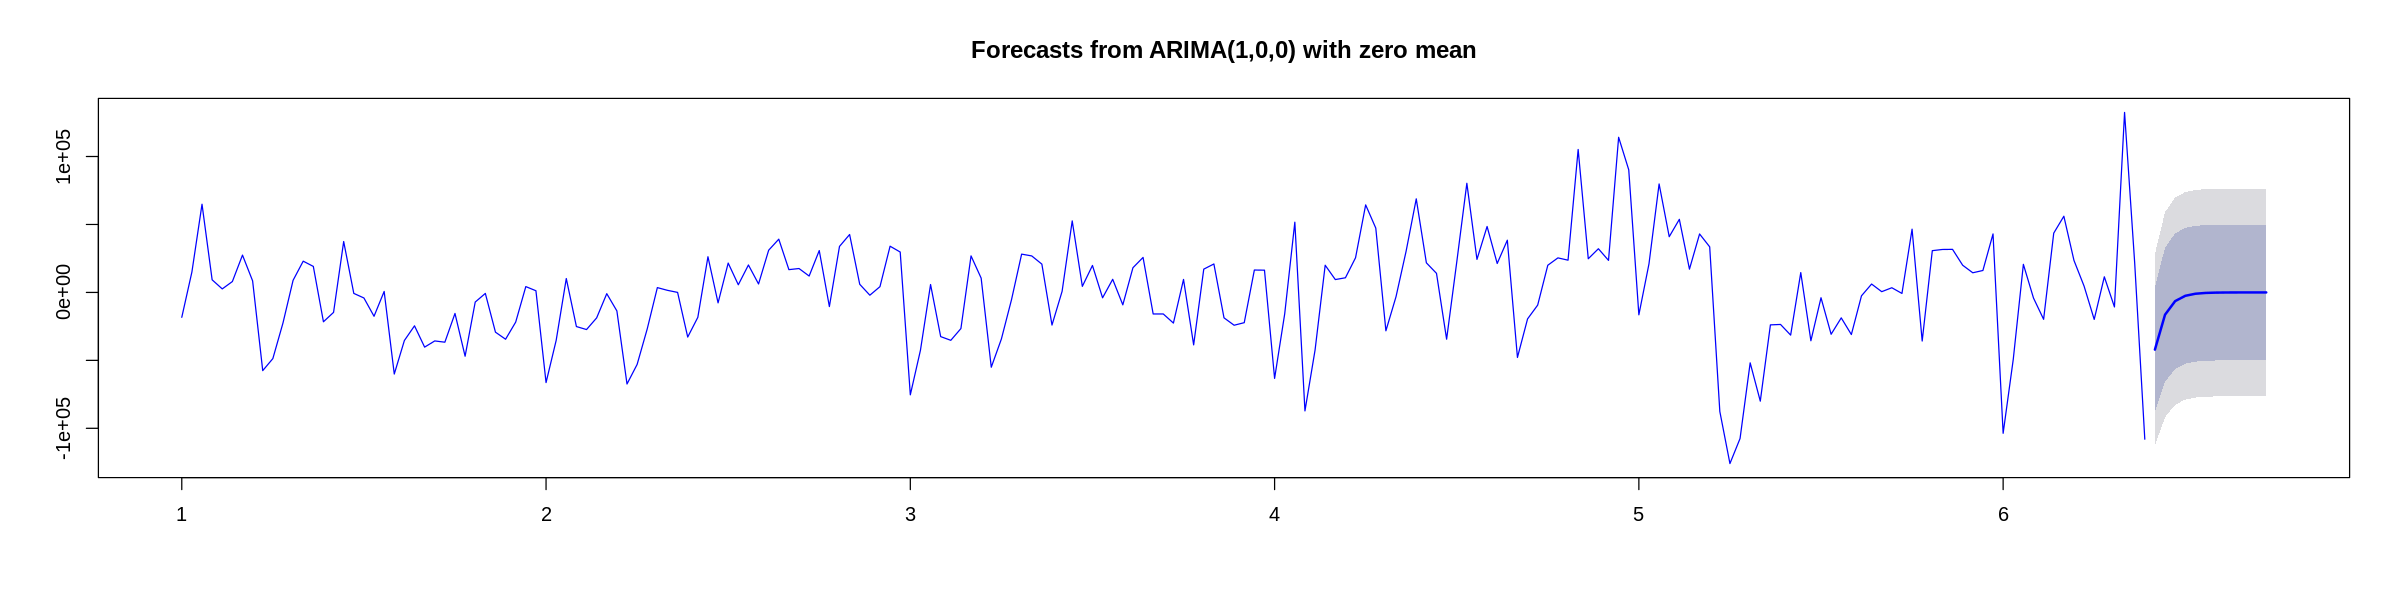

In [54]:
pred10 = forecast(fit_Arima10, h = 12)
#pred
plot(pred10, col = 4)


	Ljung-Box test

data:  Residuals from ARIMA(1,0,0) with zero mean
Q* = 78.752, df = 38, p-value = 0.0001142

Model df: 1.   Total lags used: 39



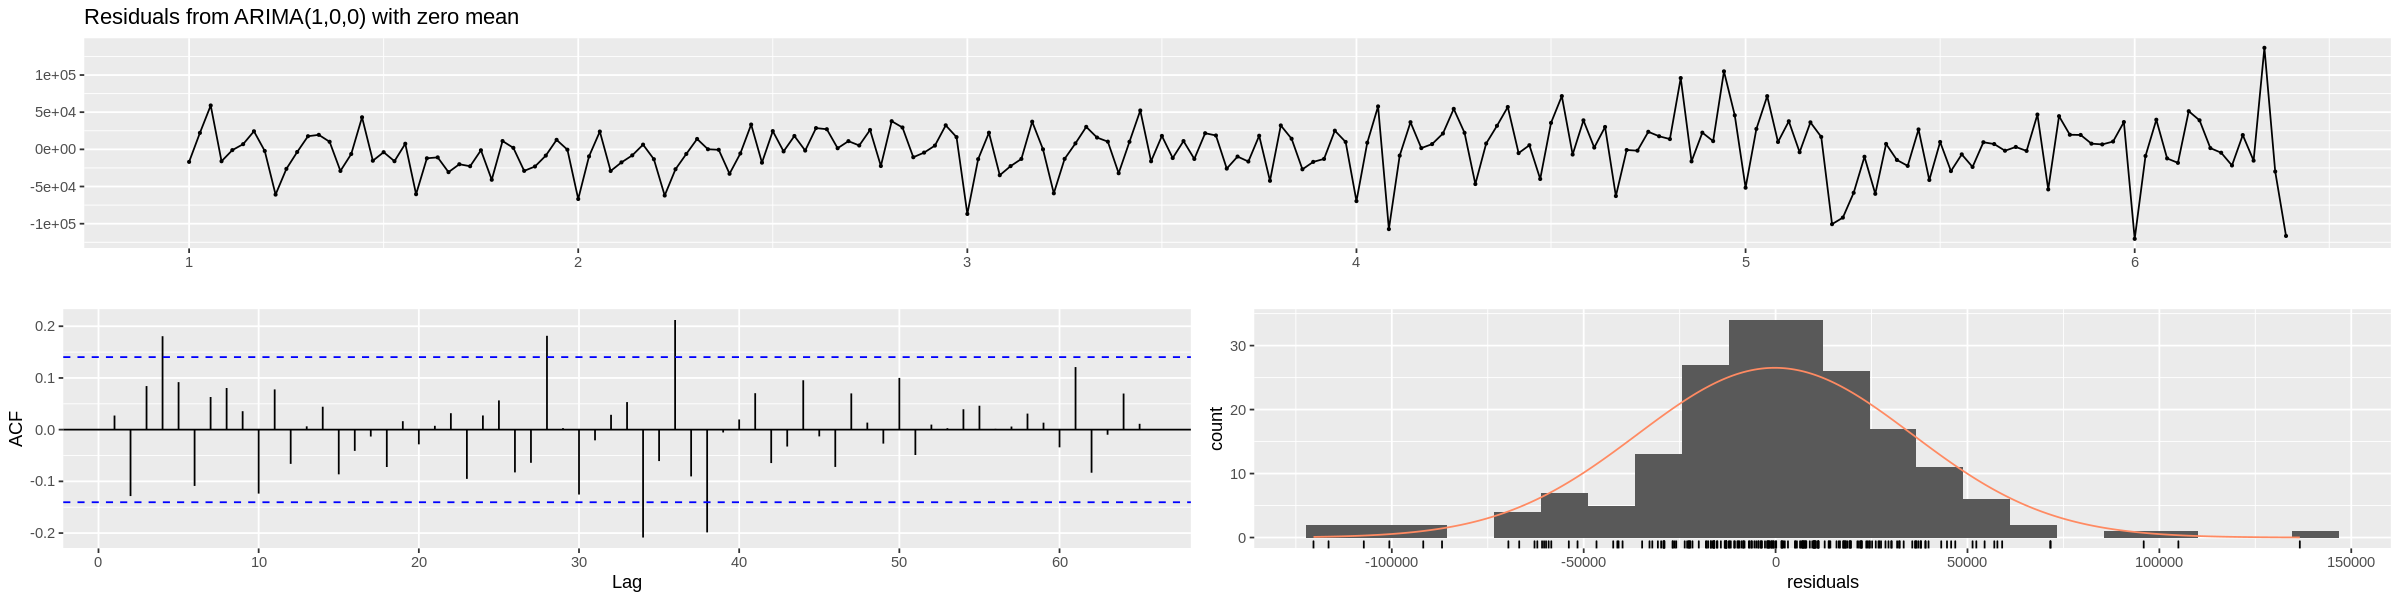

In [55]:
checkresiduals(fit_Arima10)

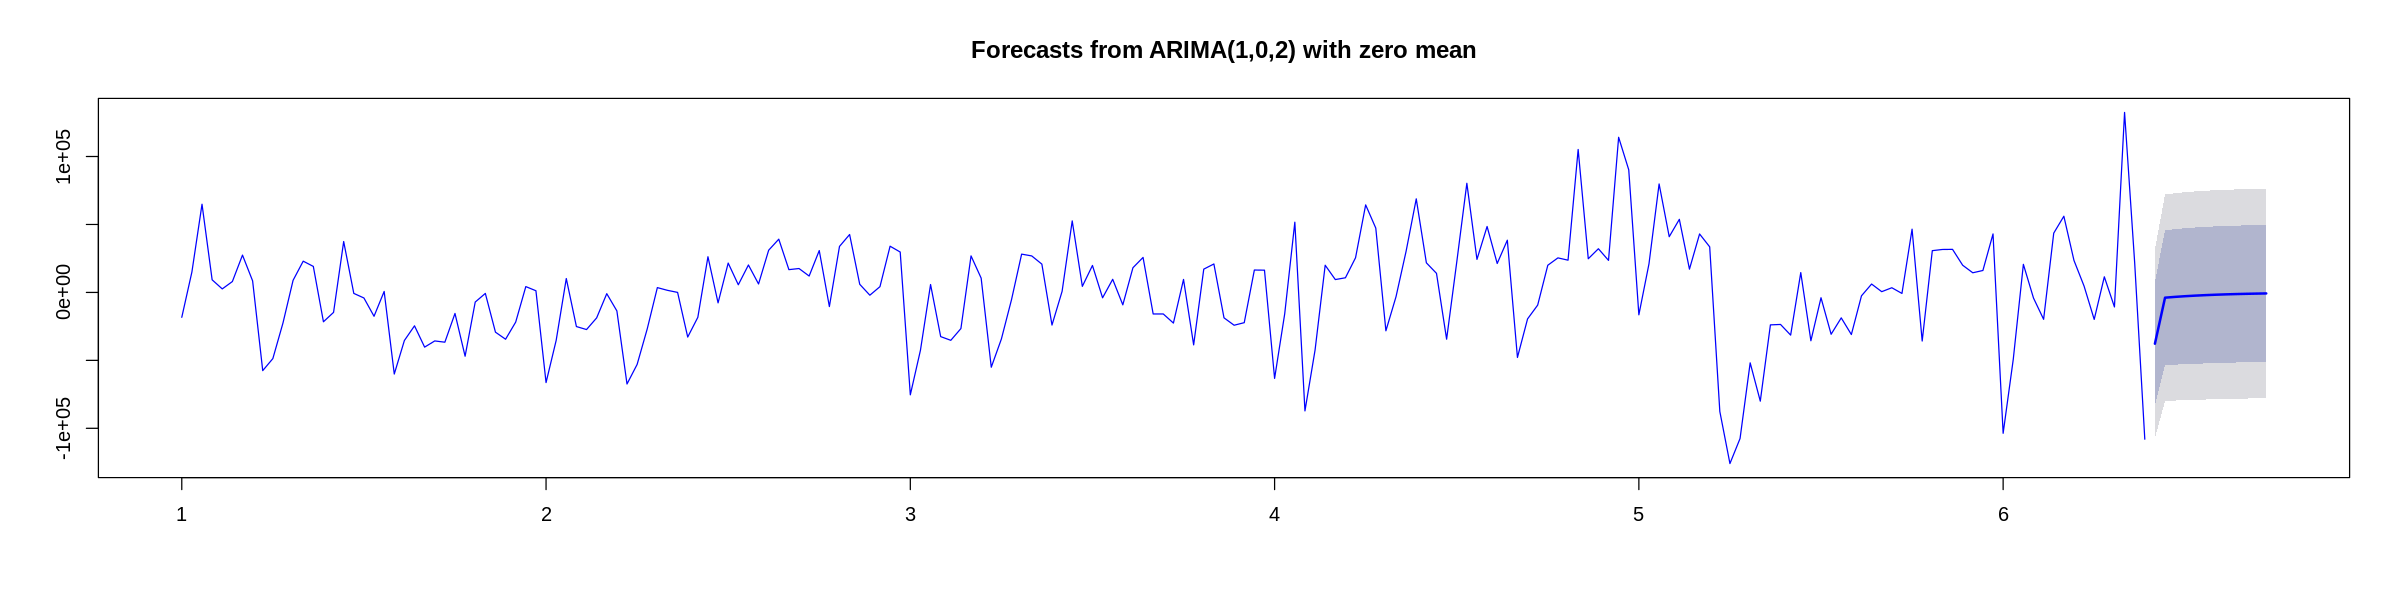

In [56]:
pred12 = forecast(fit_Arima12, h = 12)
#pred
plot(pred12, col = 4)


	Ljung-Box test

data:  Residuals from ARIMA(1,0,2) with zero mean
Q* = 66.059, df = 36, p-value = 0.001647

Model df: 3.   Total lags used: 39



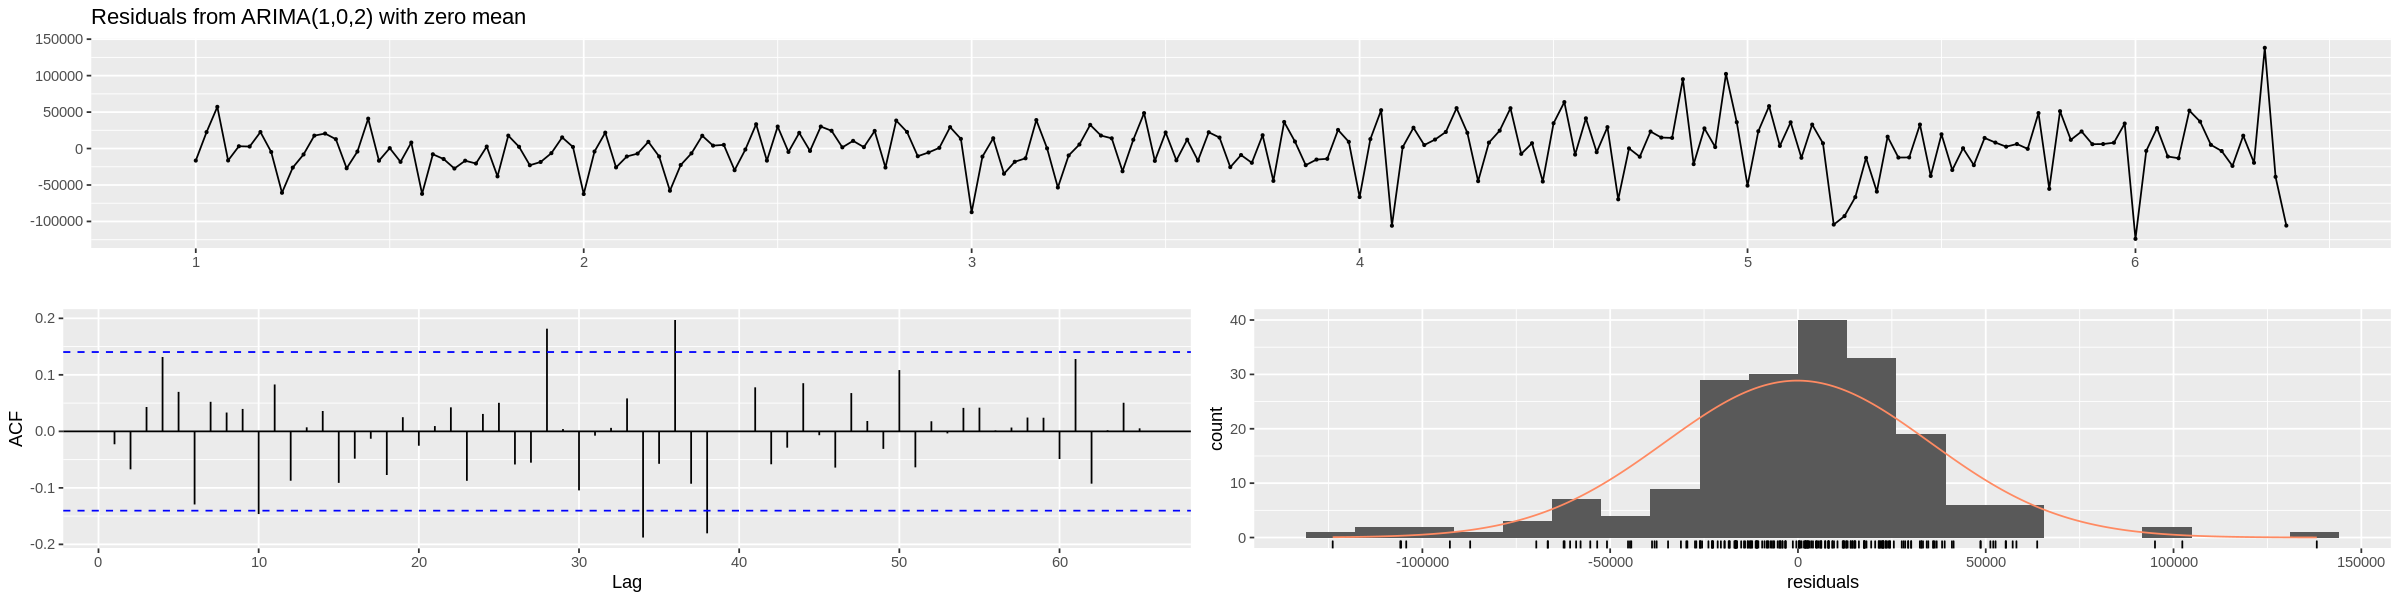

In [57]:
checkresiduals(fit_Arima12)

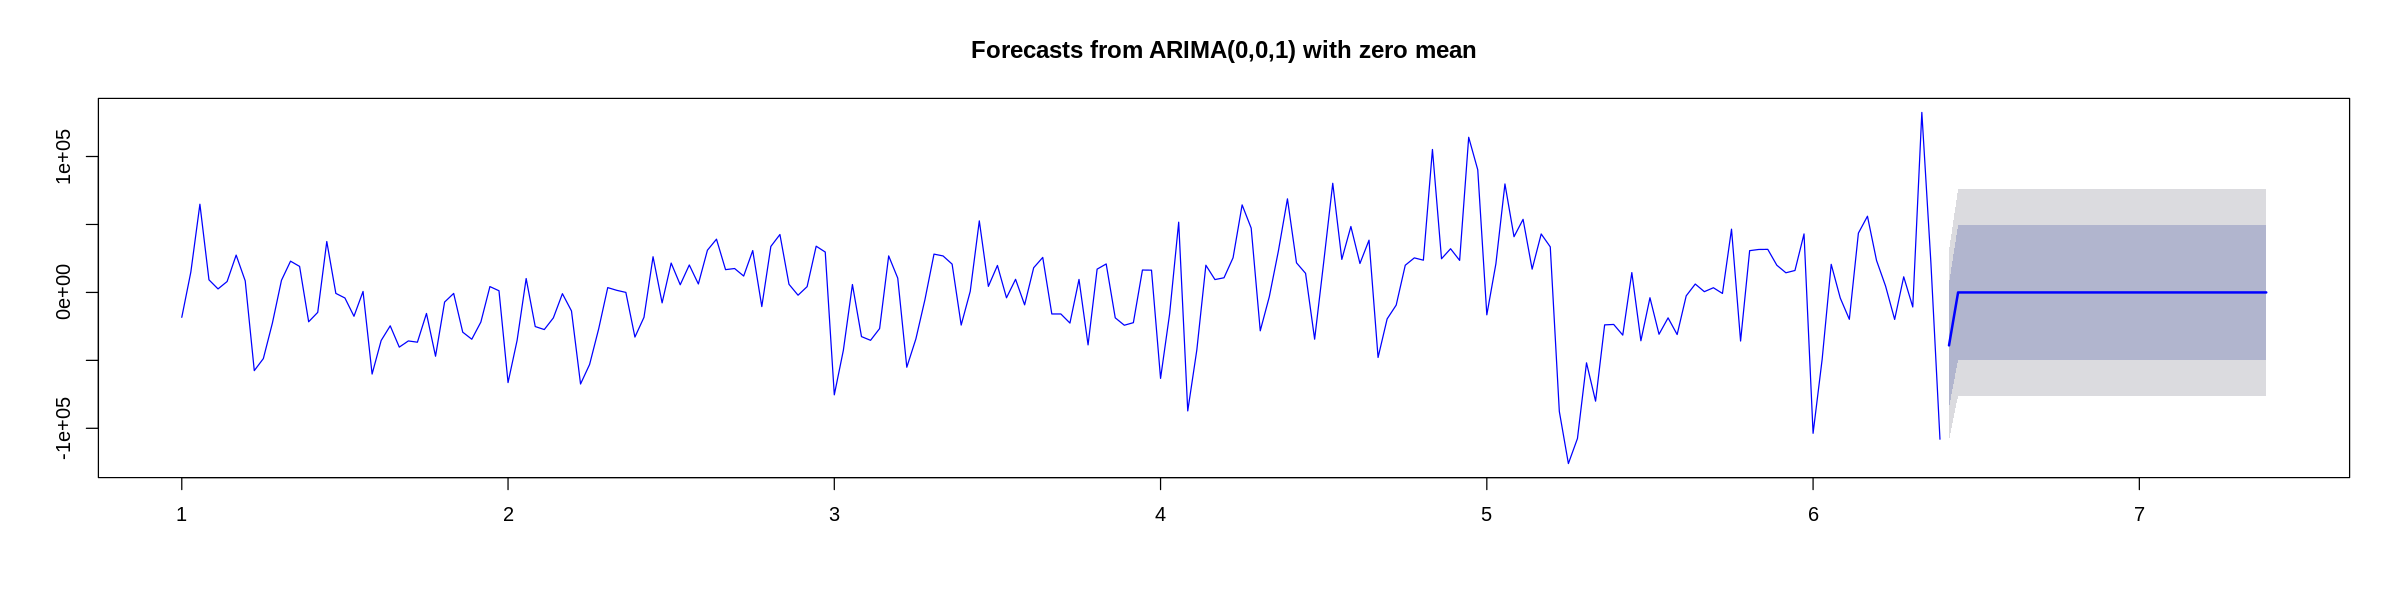

In [58]:
pred01 = forecast(fit_Arima01, h = 36)
#pred
plot(pred01, col = 4)


	Ljung-Box test

data:  Residuals from ARIMA(0,0,1) with zero mean
Q* = 64.464, df = 38, p-value = 0.004677

Model df: 1.   Total lags used: 39



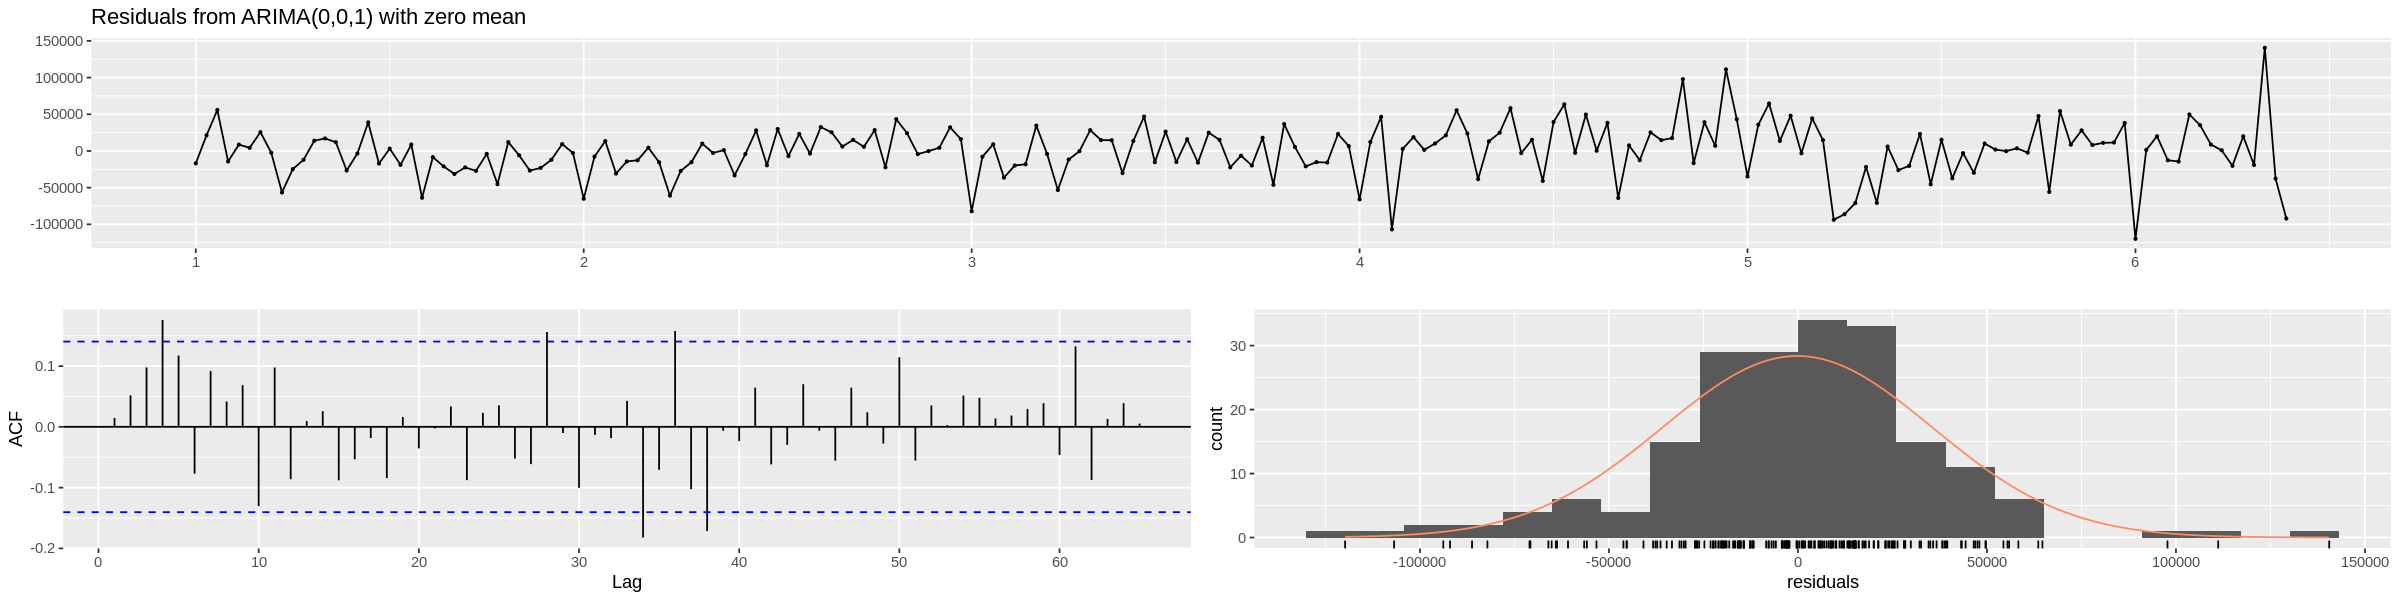

In [59]:
checkresiduals(fit_Arima01)

In [60]:
## Construimos los nuevos datos a evaluar el modelo

#Agregamos tiempos para 10 muestras en el futuro
new_t = seq(6.39,7.37,by=1/36)

#Lo convierto en serie temporal
new_t = ts(new_t,start=6.39, freq=36)

#Predigo sobre los nuevos datos.
new_data = data.frame(t=new_t)
prediccion= predict(fit3, new_data)

#Convierto el resultado en time series
prediccion = ts(prediccion,start = 6.39, frequency = 36)


###### Realizamos una prediccion completa con los modelos elegidos

In [61]:
pred_mean = prediccion + pred01$mean
pred_lower = prediccion + pred01$lower[,2] #Intervalo de confianza inferior al 95%
pred_upper = prediccion + pred01$upper[,2] #Intervalo de confianza superior al 95%

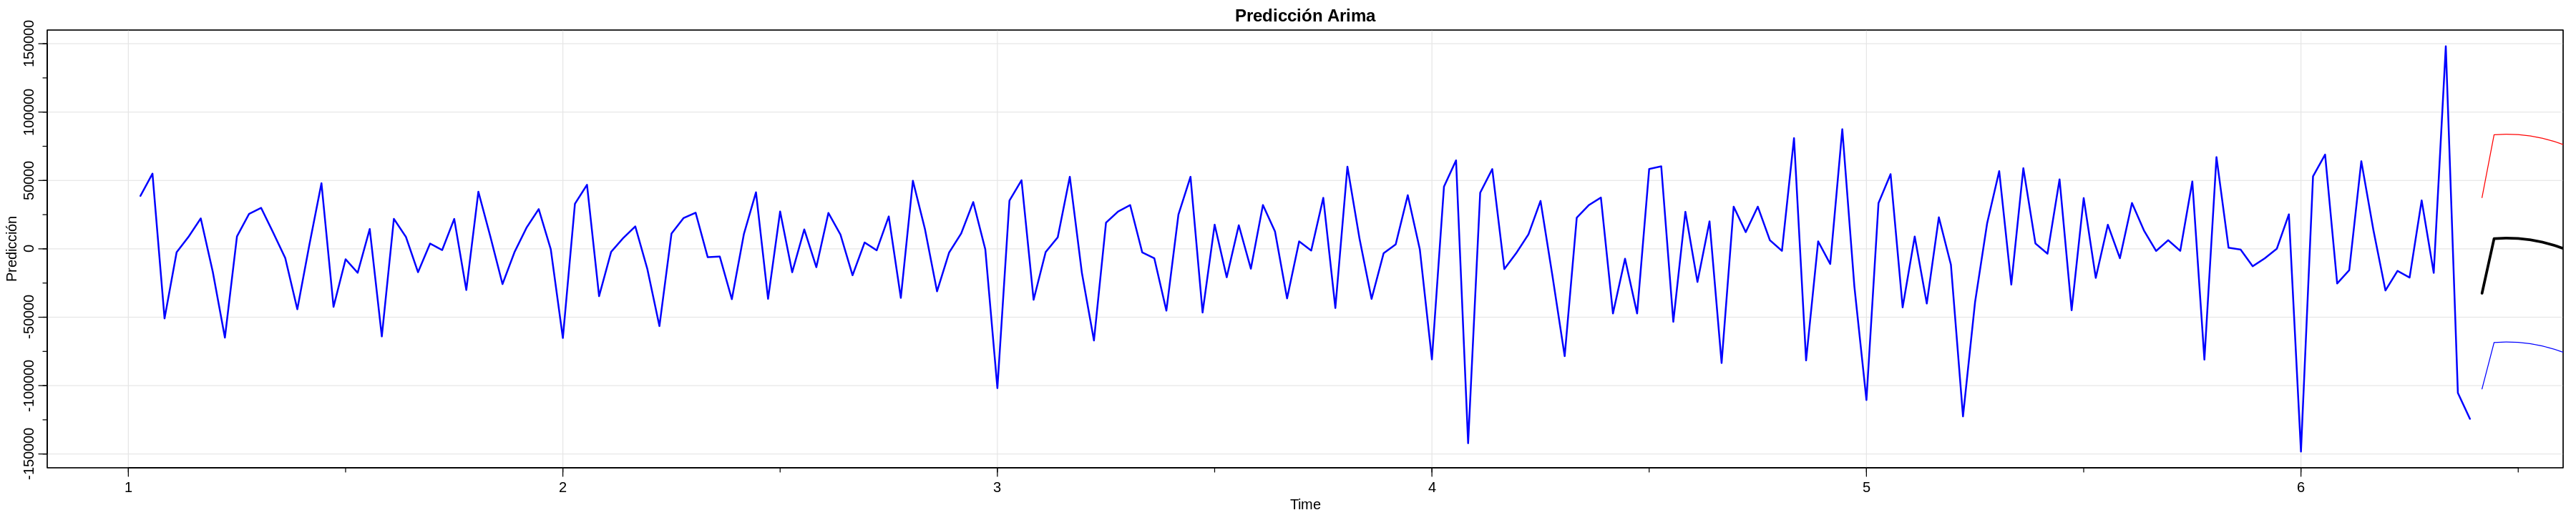

In [62]:
#Ploteo las predicciones completas(ajuste + Arima)
options(repr.plot.width=30, repr.plot.height=6)

tsplot(diff(datos_st),  col = 4, lwd = 2,ylab='Predicción', main='Predicción Arima')
lines(pred_mean, col = 1, lwd = 3)
lines(pred_lower, col = 4)
lines(pred_upper, col = 2)

## Local level model

* Ecuación de estado: 

$$ x_{t+1} = \Phi x_t + w_t.$$

* Ecuación de observación:

$$ y_t = A x_t + v_t,$$

Para este caso: 
$x_t\in \mathbb{R}$,  $y_t\in \mathbb{R}$,  $\Phi=1$,   $Q=\sigma_v^2>0$,  $R=\sigma_v^2>0$,  $A=1$

Se asume además que los ruidos $w_t$ y $v_t$ son independientes, y que el estado inicial $x_0$ tiene una distribución $N(\mu_0,\Sigma_0)$ conocida. Siendo $\mu_0=336414$ y $\Sigma_0=10000$

In [63]:
num=length(datos_st) #largo de observaciones
A=1           #matriz de observación
Phi=1         #matriz de transición

#condición inicial
mu0=336414    #valor cercano al primer valor de la serie
Sigma0=10000  

In [64]:
# Función que evalúa la verosimilitud para los parámetros libres

#Dados los parámetros, se usa Kfilter0 para aplicar filtro de Kalman sin entrada y se computa la verosimilitud.

LikelihoodFunction = function(para){
    cQ = para[1]      # sigma_w
    cR = para[2]      #sigma_v
   
    kf = Kfilter0(num,datos_st,A,mu0,Sigma0,Phi,cQ,cR)
    return(kf$like) 
 }

In [65]:
# Ajuste por maxima verosimilitud:
init.par = c(10000,10000)  # Valores iniciales de los parámetros (varianzas)
est = optim(init.par, LikelihoodFunction, NULL, method="BFGS", hessian=TRUE, control=list(trace=1)) ##optimizador de R
SE = sqrt(diag(solve(est$hessian))) 

# Summary of estimation  
estimate = est$par; u = cbind(estimate, SE)
rownames(u)=c("sigw", "sigv"); u  

initial  value 2476.473676 
final  value 2169.053739 
converged


estimate SE      
sigw 17134.90 988.6069
sigv 21745.23 772.8296

In [66]:
sQ=abs(u["sigw","estimate"])
sR=abs(u["sigv","estimate"])

In [67]:
#Se hace suavizado de Kalman para hallar el estimado
kf = Ksmooth0(num,datos_st,A,mu0,Sigma0,Phi,sQ,sR)

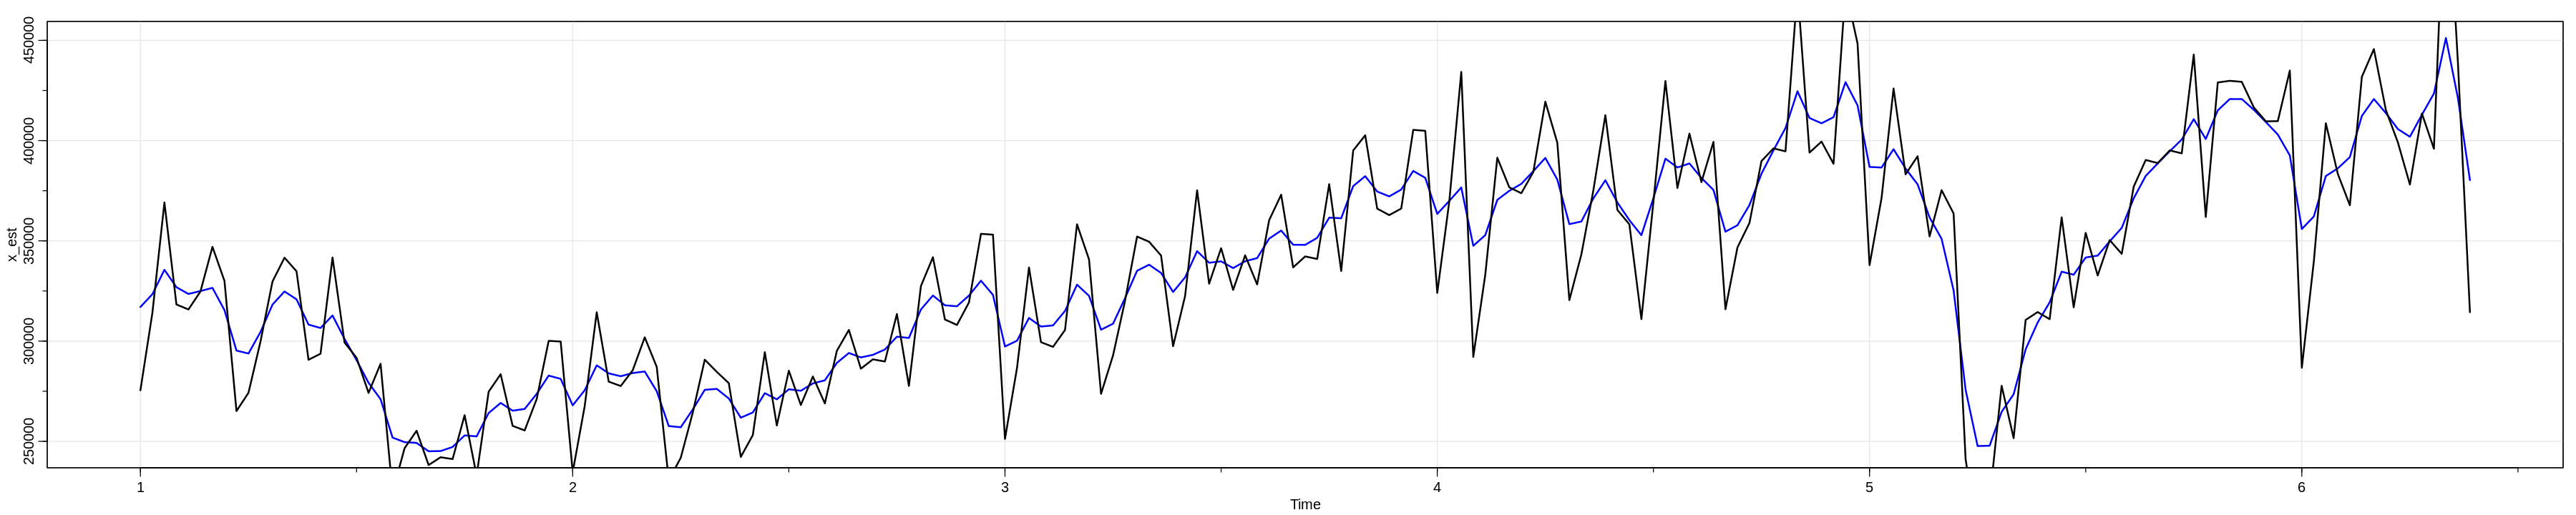

In [68]:
x_est=ts(as.numeric(kf$xs), start=1, frequency=36)
tsplot(x_est, col=4, lwd = 2) #trayectoria de estado para el modelo que mejor explica la serie observada
lines(datos_st, col=1, lwd = 2) #lo que observo

[1] 22091

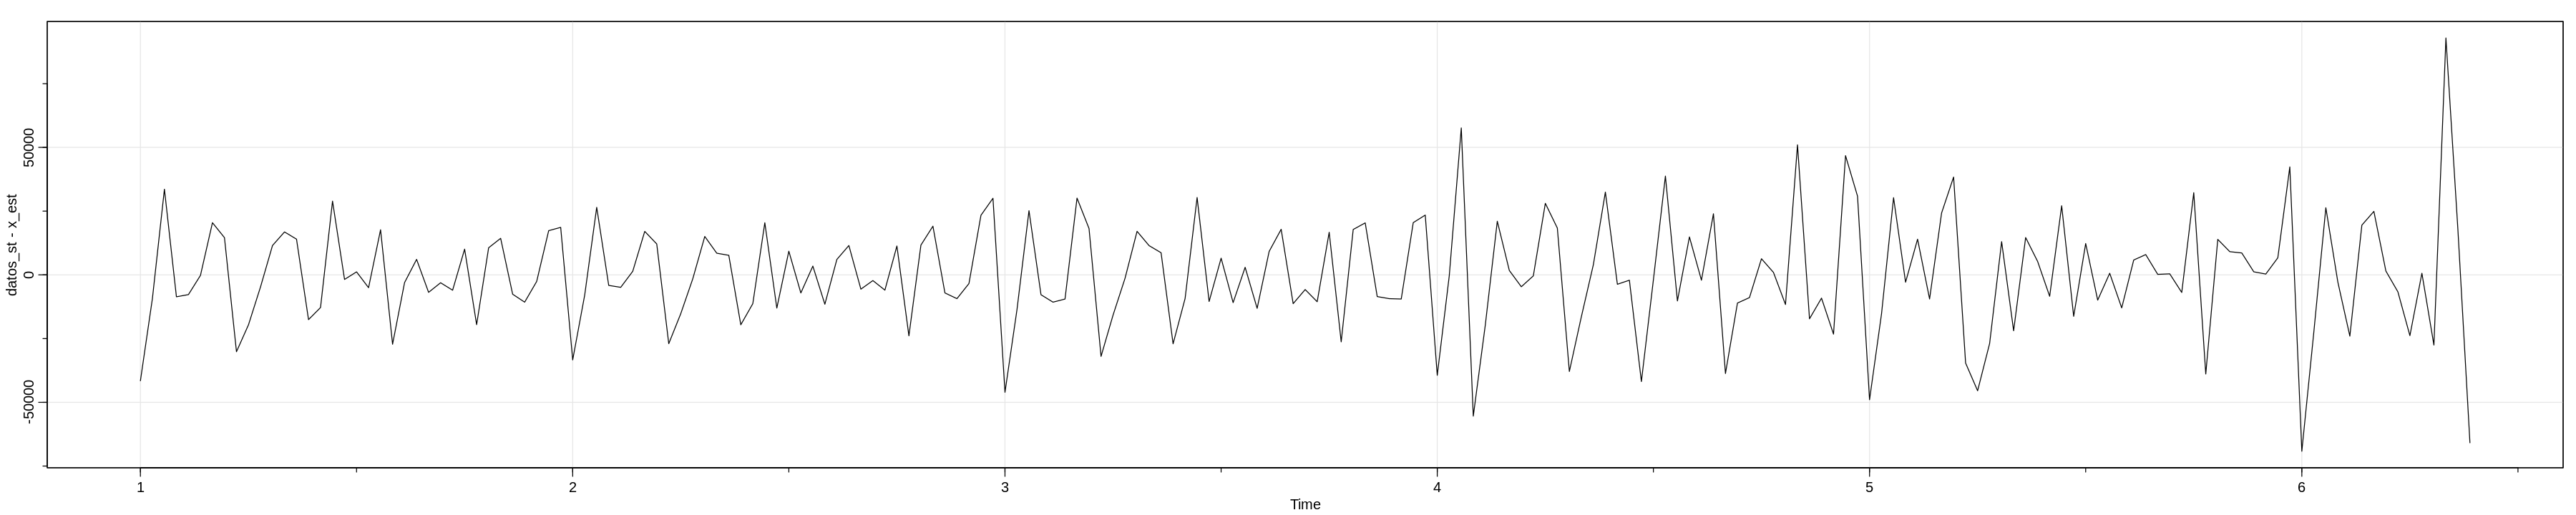

In [69]:
tsplot(datos_st-x_est)
sd(datos_st-x_est)

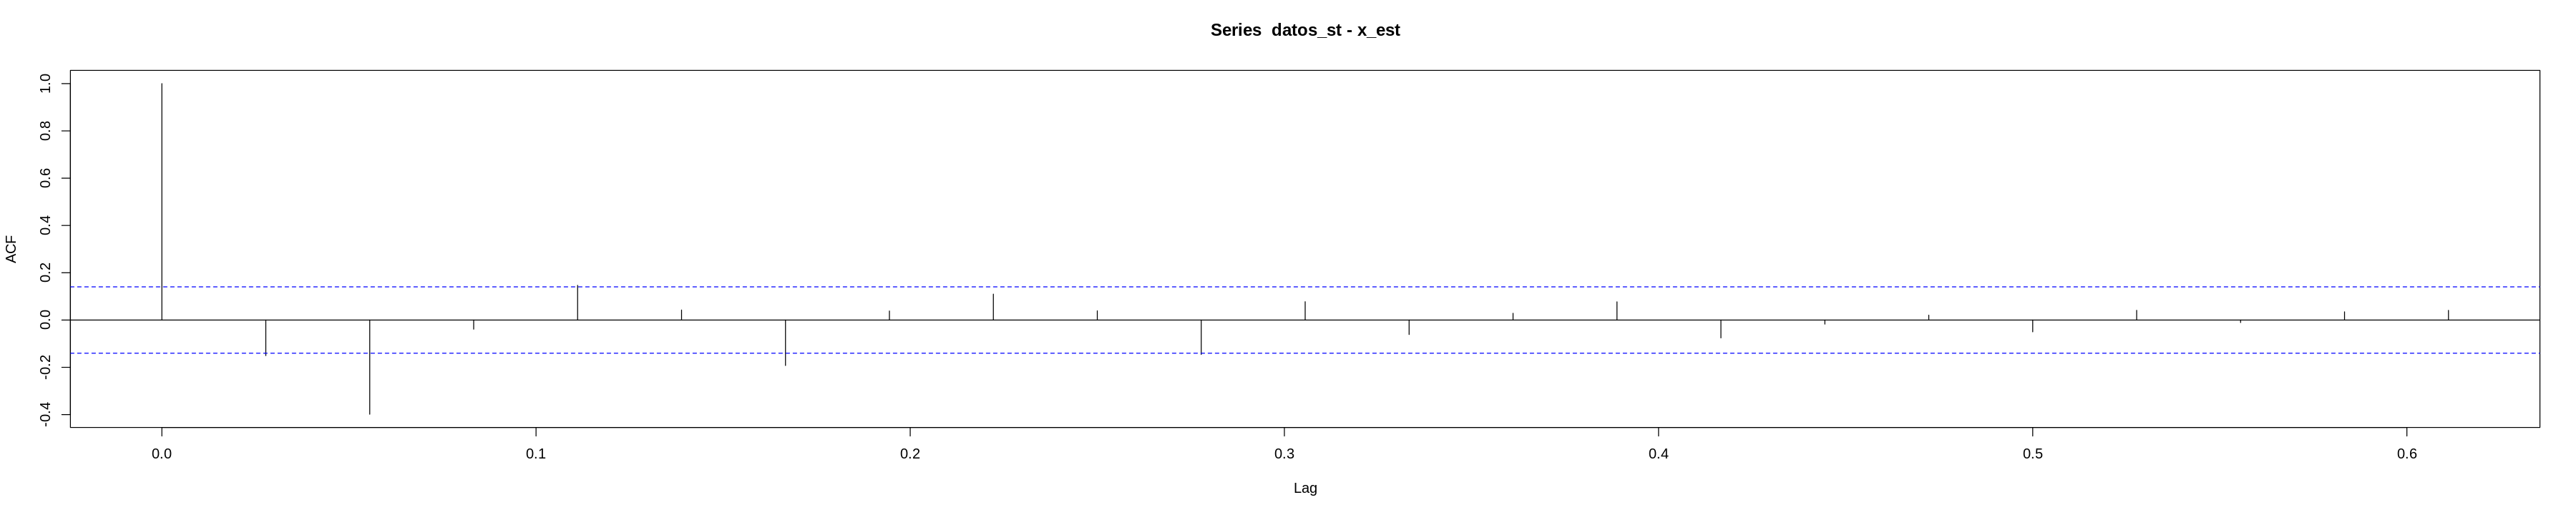

In [70]:
acf(datos_st-x_est)

A partir de la acf del residuo y su varianza, podemos deducir que es un bueno modelo para esta serie.


## Modelo estructural con trend y season

Se intenta mejorar el modelo anterior suponiendo que el desempleo observado verifica:

$$y_t = T_t + S_t + v_t$$

Se supone además que $T_t$ la tendencia sigue un local-level model:

$$T_t = T_{t-1} + w_{1t}$$

Pero se agrega la componente estacional $S_t$ que verifica:

$$S_t+S_{t-1}+S_{t-2} = w_{2t}$$

Siendo  $v_t=\sigma_v^2$,  $w_{1t}=\sigma_{w1}^2$,  $w_{2t}=\sigma_{w2}^2$ y se asumen independientes.

Se define: 
$$x_t = \begin{pmatrix} T_1 \\ S_t \\ S_{t-1} \end{pmatrix}$$

Se tiene el modelo de forma matricial:
$$x_t = \begin{pmatrix} T_1 \\ S_t \\ S_{t-1} \end{pmatrix} = \begin{pmatrix} 1 & 0 & 0 \\ 0 & -1 & -1 \\ 0 & 1 & 0\end{pmatrix} \begin{pmatrix} T_{t-1} \\ S_{t-1} \\ S_{t-2} \end{pmatrix} + \begin{pmatrix} w_{1t} \\ w_{2t} \\ 0 \end{pmatrix}$$

$$y_t = \begin{pmatrix} 1 & 1 & 0 \end{pmatrix}x_t + v_t$$

Por lo tanto:

$\Phi = \begin{pmatrix} 1 & 0 & 0 \\ 0 & -1 & -1 \\ 0 & 1 & 0  \end{pmatrix}$

$A = \begin{pmatrix} 1 & 1 & 0 \end{pmatrix}$

In [71]:
num = length(datos_st)

A = matrix(c(1,1,0), nrow=1, ncol=3)
Phi = matrix(c(1,0,0,0,-1,1,0,-1,0), nrow=3, ncol=3)
mu0 = c(336414,0,0) #condiciones iniciales
Sigma0 = diag(c(15000,15000,15000))

A
Phi
mu0
Sigma0

[,1] [,2] [,3]
[1,] 1    1    0

[,1] [,2] [,3]
[1,] 1     0    0  
[2,] 0    -1   -1  
[3,] 0     1    0

[1] 336414      0      0

[,1]  [,2]  [,3] 
[1,] 15000     0     0
[2,]     0 15000     0
[3,]     0     0 15000

Las incógnitas que se tiene son las varianzas de los tres ruidos.

In [72]:
# Función que evalúa la verosimilitud para los parámetros libres

#Dados los parámetros, se usa Kfilter0 para aplicar filtro de Kalman sin entrada y se computa la verosimilitud.

LikelihoodFunction = function(para){
    cQ1 = para[1]      # Q tiene los ruidos sigma_w en la diagonal
    cQ2 = para[2]      
    cQ = matrix(c(cQ1,0,0,0,cQ2,0,0,0,0),3)
    cR = para[3]     #sigma_v
   
    kf = Kfilter0(num,datos_st,A,mu0,Sigma0,Phi,cQ,cR)
    return(kf$like) 
 }

In [73]:
# Ajuste por maxima verosimilitud:
init.par = c(4000,4000, 4000)  # Valores iniciales de los parámetros (varianzas)
est = optim(init.par, LikelihoodFunction, NULL, method="BFGS", hessian=TRUE, control=list(trace=1)) ##optimizador de R
SE = sqrt(diag(solve(est$hessian))) 

# Summary of estimation  
estimate = est$par; u = cbind(estimate, SE)


initial  value 3816.109840 
iter  10 value 2194.001906
final  value 2186.243917 
converged


In [74]:
rownames(u)=c("sigw1", "sigw2", "sigv"); u  

estimate SE       
sigw1 19817.07 1221.7376
sigw2 14743.86  531.9856
sigv  20213.67 1332.5357

In [75]:
sigmaw1=abs(u["sigw1","estimate"])
sigmaw2=abs(u["sigw2","estimate"])
sigmav=abs(u["sigv","estimate"])

cQ1 = sigmaw1
cQ2 = sigmaw2
cQ = matrix(c(cQ1,0,0,0,cQ2,0,0,0,0),3)
cR = sigmav

kf = Ksmooth0(num,datos_st,A,mu0,Sigma0,Phi,cQ,cR)
Tt = kf$xs[1,1,]
St = kf$xs[2,1,]

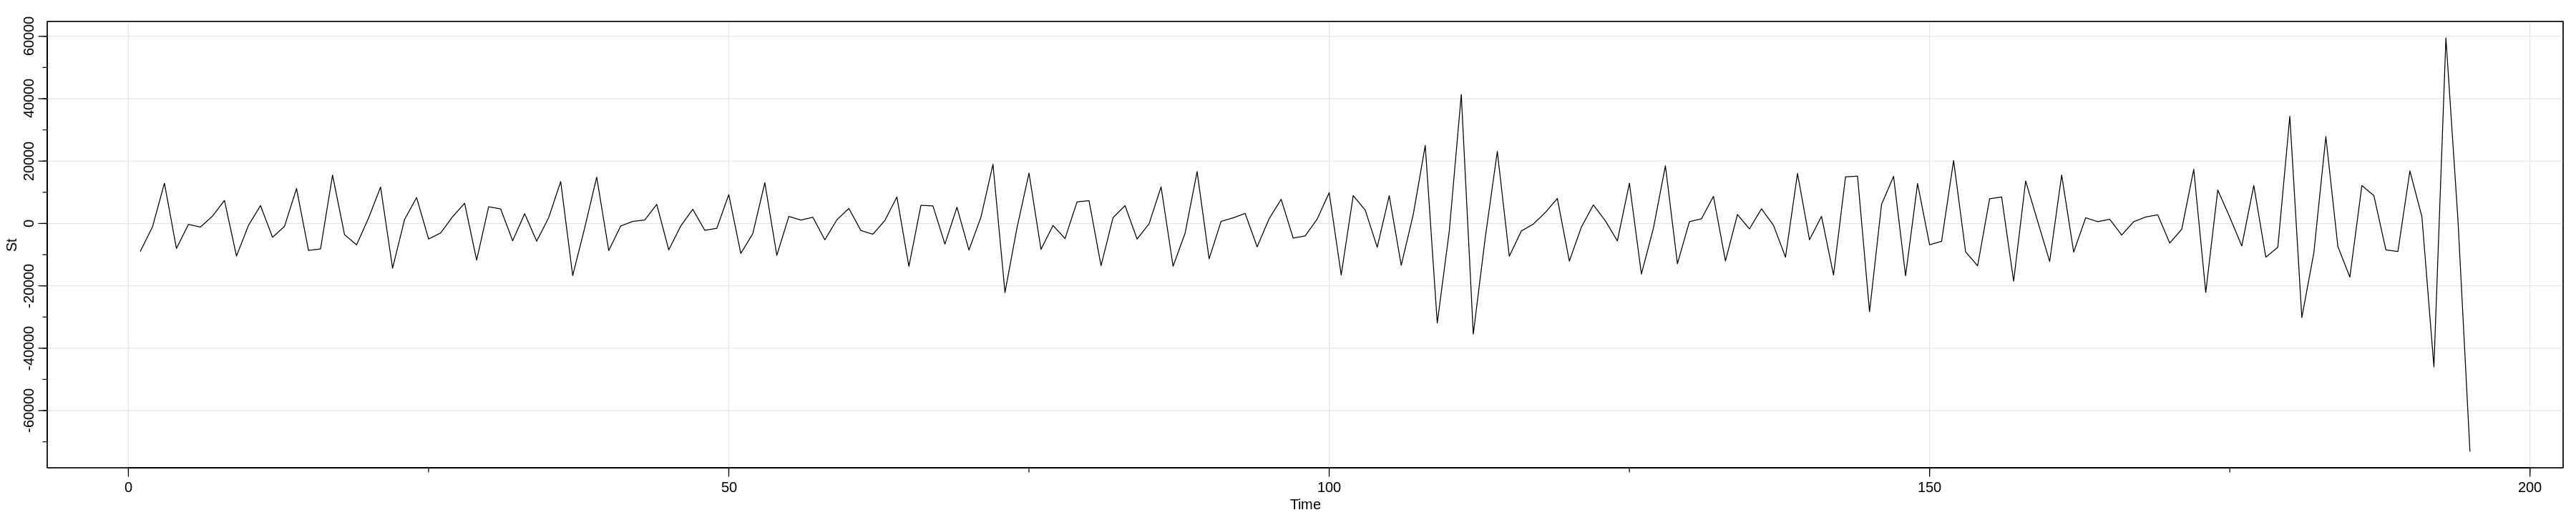

In [76]:
tsplot(St)

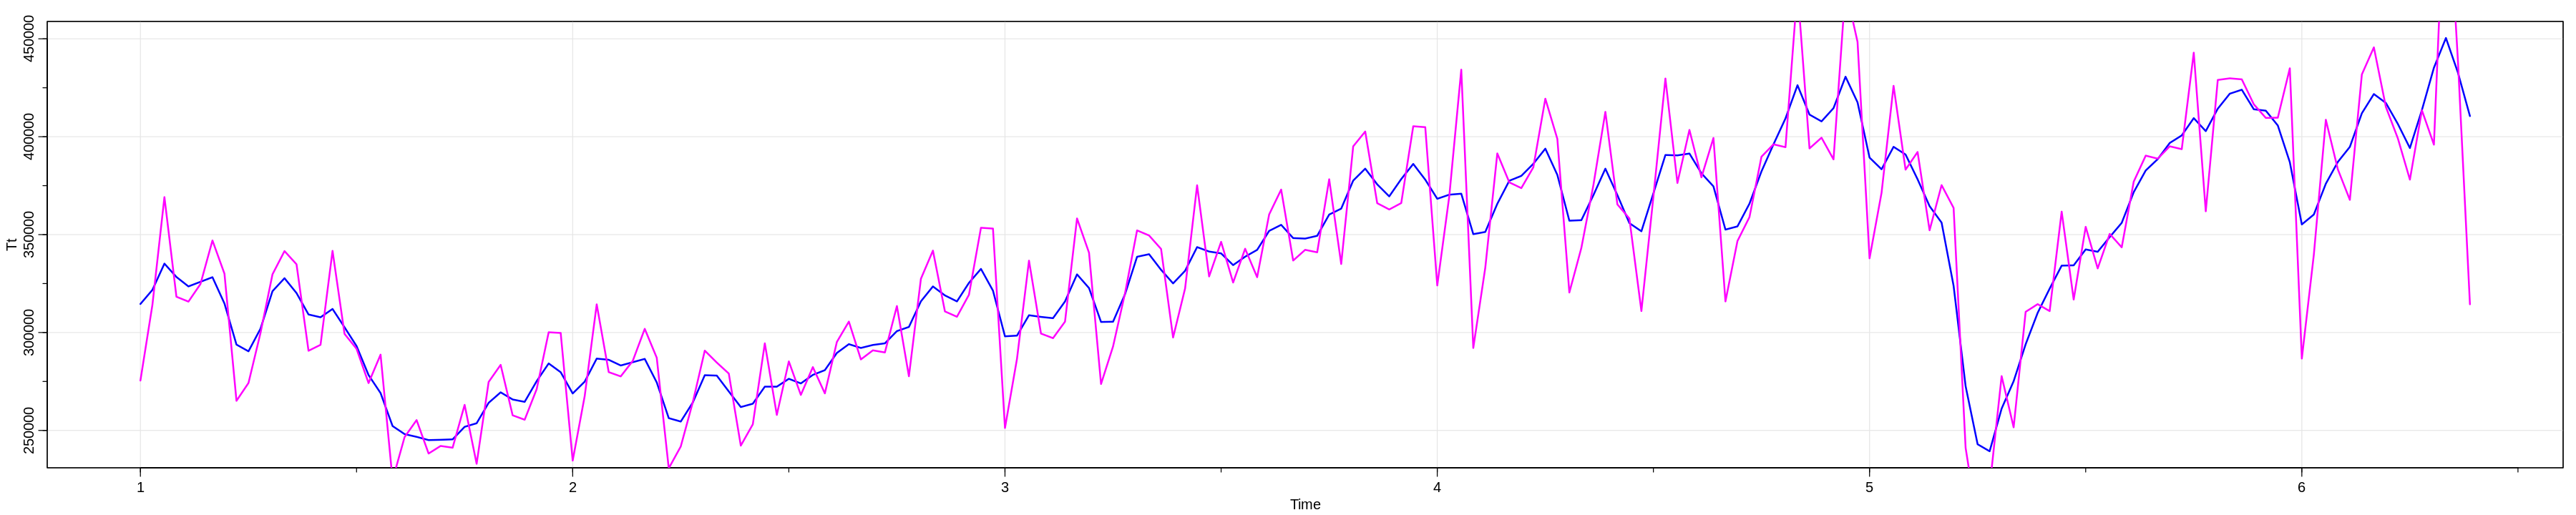

In [77]:
Tt = ts(Tt, start=1, frequency= 36)
St = ts(St, start=1, frequency= 36)

tsplot(Tt,col=4, lwd = 2)
lines(datos_st,col=6, lwd = 2)

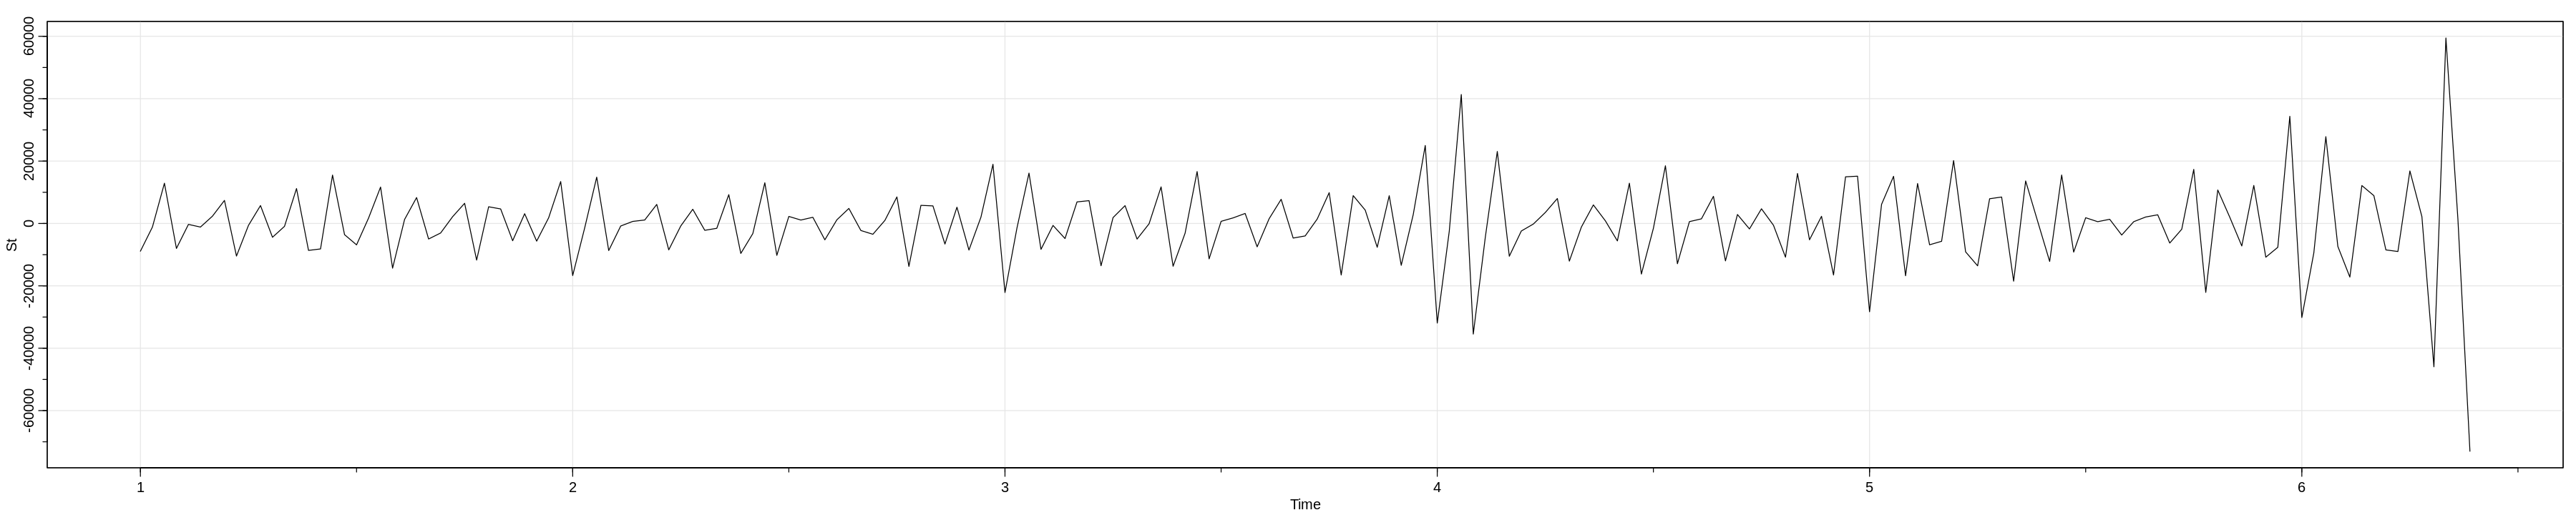

In [78]:
tsplot(St)  #componente estacional

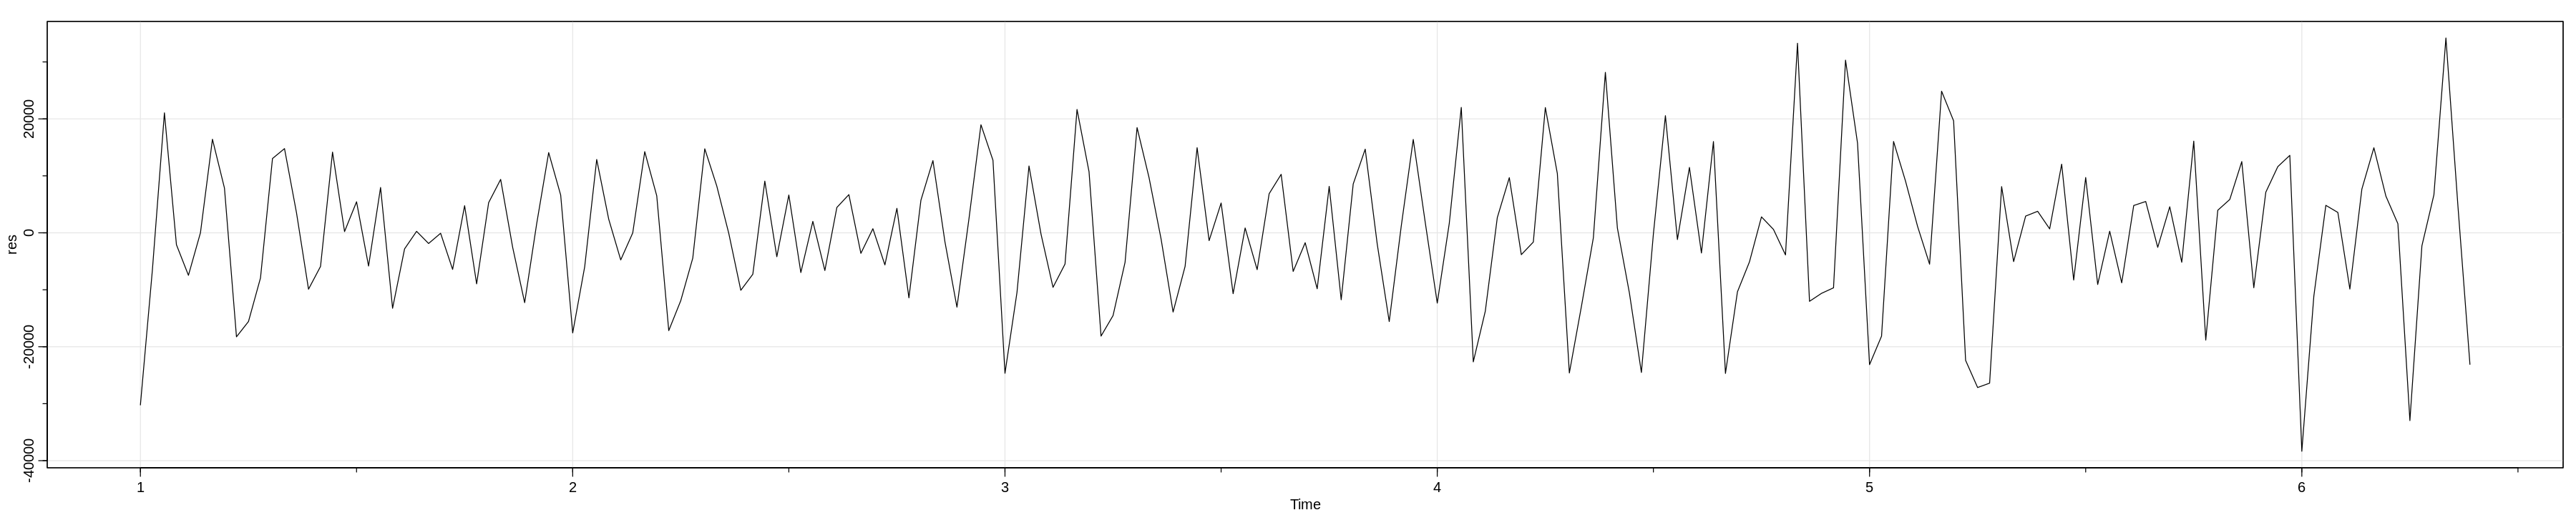

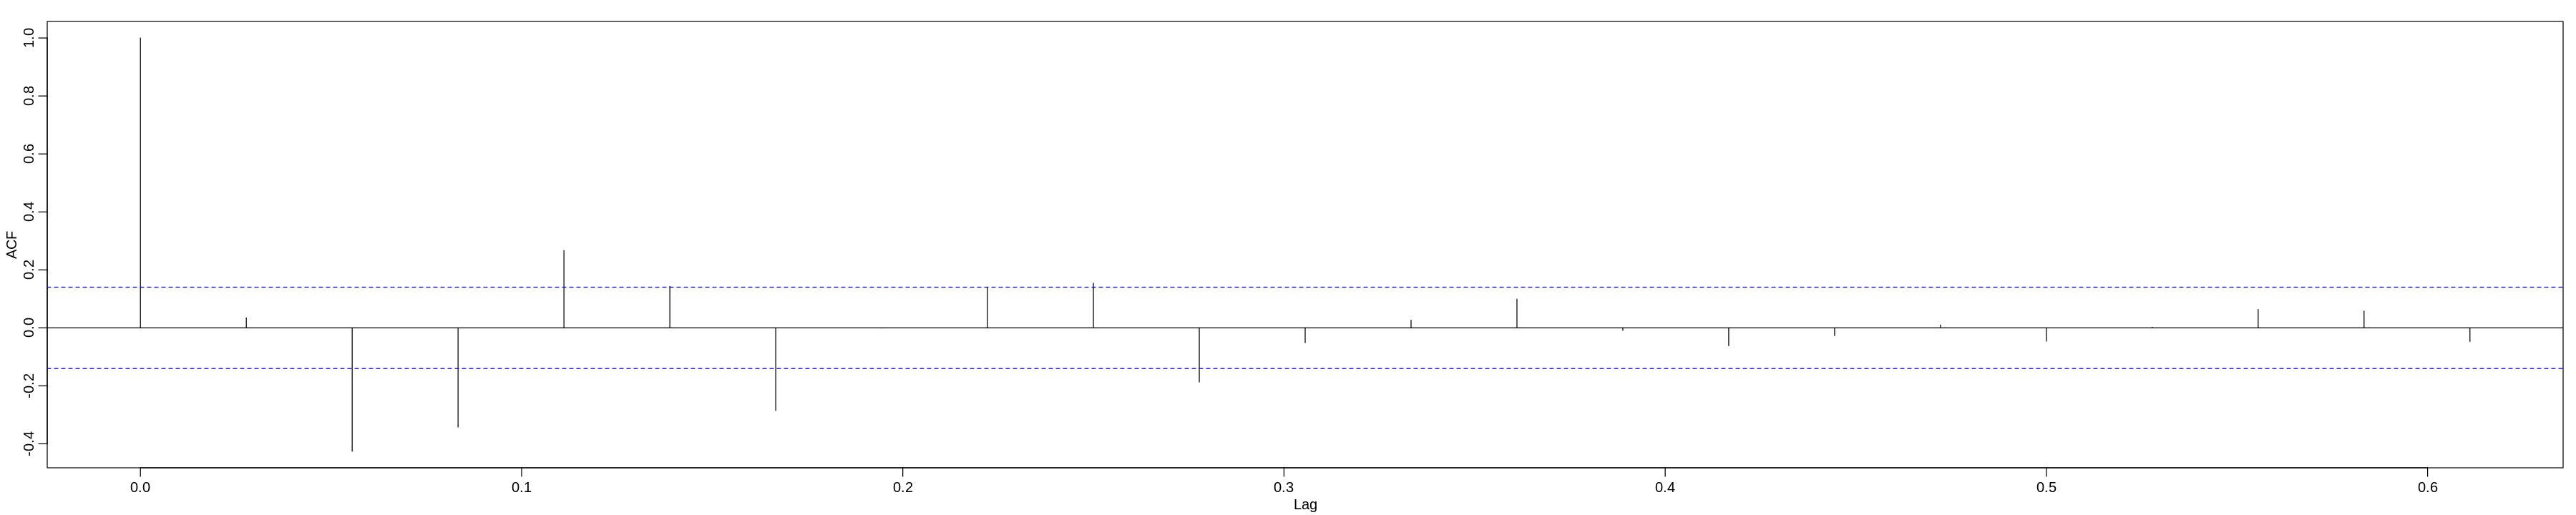

In [79]:
res = datos_st - Tt - St
tsplot(res)
acf(res)

#### Se observa que las graficas de predicciones de este modelo y el anterior son similares, por lo tanto no se logra encontrar la componente estacional

## Conclusiones finales

##### Previo al analisis, teniamos como hipotesis enocntrar una tendencia en alguna de las franjas dentro del mes, por ejemplo supusimos que al inicio de mes podriamos encontrar una estacionalidad debido a los consumos relacionados a los debitos automaticos. Esta hipotesis no se cumple ya que no encontramos ninguna estacionalidad.
